https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
import os
import pickle
import pathlib

import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.python.platform import gfile

import input_data

import IPython.display as ipd
from scipy.io import wavfile

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
sns.set()

# spec augment

In [4]:
been = "../frequent_words/en/clips/been/common_voice_en_10005.wav"

In [5]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, [been], bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE


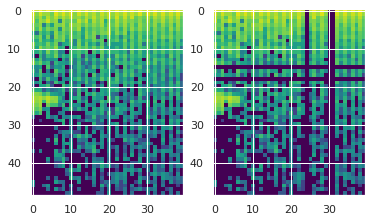

In [6]:
spec = a.file2spec(been,add_bg=True)

fig,ax=plt.subplots(ncols=2)

aug_spec = a.spec_augment(spec)
ax[0].imshow(spec.numpy(), cmap='viridis')
ax[1].imshow(aug_spec.numpy(), cmap='viridis');

# spectrogram inquiry

In [266]:
been = "../frequent_words/en/clips/been/common_voice_en_10005.wav"
sr,been = wavfile.read(been)

In [268]:
been.shape

(16000,)

In [6]:
sr

16000

In [ ]:
plt.plot(been);

In [5]:
foreground_audio = "../frequent_words/en/clips/appeared/common_voice_en_131143.wav"
sr,foreground_audio = wavfile.read(foreground_audio)

In [286]:
play(foreground_audio)

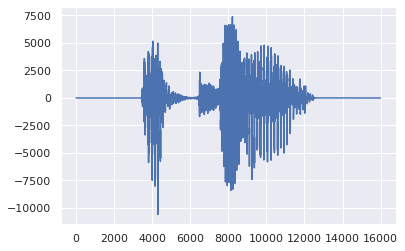

In [9]:
plt.plot(foreground_audio);

In [10]:
# caution, int16 will overflow from square:
foreground_rms = np.sqrt(np.mean(np.square(foreground_audio.astype(np.float32))))
foreground_rms

1266.727

In [11]:
#background_noise = np.random.normal(0,1000,16000)
sr,background_audio = wavfile.read("../speech_commands/_background_noise_/white_noise.wav")
print(sr, background_audio.shape)

16000 (960000,)


In [12]:
start = np.random.randint(background_audio.shape[0] - 16000)
background_noise = background_audio[start:start+16000]

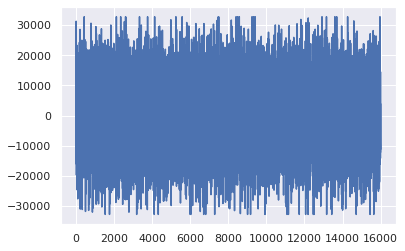

In [13]:
plt.plot(background_noise);

In [16]:
play(background_noise)

In [17]:
# caution, int16 will overflow from square:
background_rms = np.sqrt(np.mean(np.square(background_noise.astype(np.float32))))
background_rms

10997.086

In [18]:
foreground_rms/background_rms

0.11518752

In [19]:
background_rms/foreground_rms

8.681496

In [21]:
# caution, int16 will overflow from square:
foreground_rms = np.sqrt(np.mean(np.square(foreground_audio.astype(np.float32))))
foreground_rms

1266.727

In [345]:
scaled_background_noise = ((0.1) * (foreground_rms/background_rms) * background_noise)
scaled_rms = np.sqrt(np.mean(np.square(scaled_background_noise.astype(np.float32))))
scaled_rms

126.6727

In [343]:
background_noise.dtype, foreground_audio.dtype

(dtype('int16'), dtype('int16'))

(1271.5115, dtype('float64'))

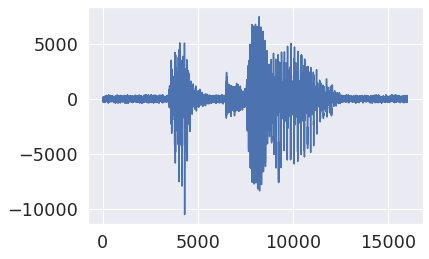

In [346]:
combined = foreground_audio + scaled_background_noise
plt.plot(combined);
final_rms = np.sqrt(np.mean(np.square(combined.astype(np.float32))))
final_rms, combined.dtype

In [347]:
play(combined)

In [57]:
sliced_been = been[5000:11000]

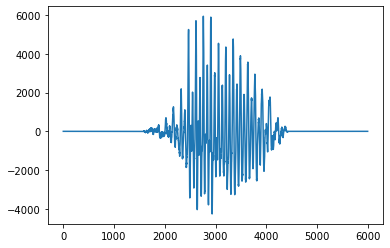

In [59]:
plt.plot(sliced_been)

In [58]:
play(sliced_been)

(49, 40)


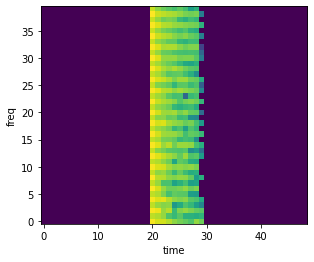

In [36]:
view(been)

In [67]:
copied_been = np.concatenate([np.zeros(300), sliced_been, np.zeros(2000), sliced_been, np.zeros(1700)])
copied_been.shape

(16000,)

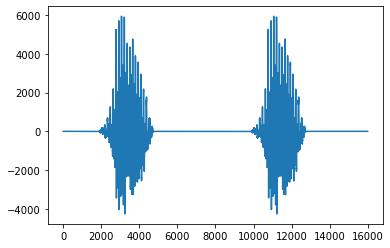

In [68]:
plt.plot(copied_been)

In [69]:
play(copied_been)

(49, 40)


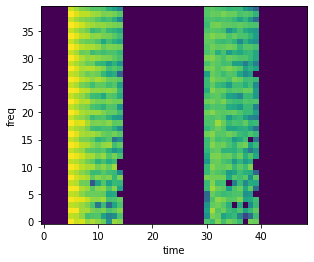

In [70]:
view(copied_been)

In [37]:
# continued = "../frequent_words/en/clips/continued/common_voice_en_129228.wav"
# sr,continued = wavfile.read(continued)

In [73]:
continued = "../frequent_words/en/clips/continued/common_voice_en_135254.wav"
sr,continued = wavfile.read(continued)

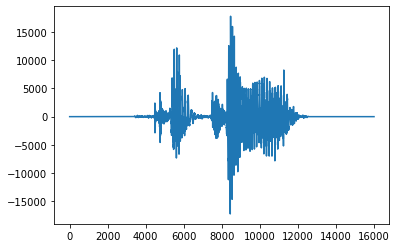

In [74]:
plt.plot(continued)

(49, 40)


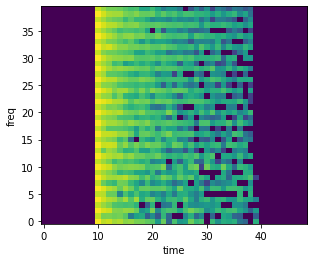

In [75]:
view(continued)

In [76]:
play(continued)

In [47]:
everything = "../frequent_words/en/clips/everything/common_voice_en_115026.wav"
sr,everything = wavfile.read(everything)

(49, 40)


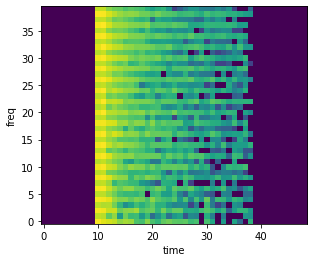

In [49]:
view(everything)

In [48]:
play(everything)

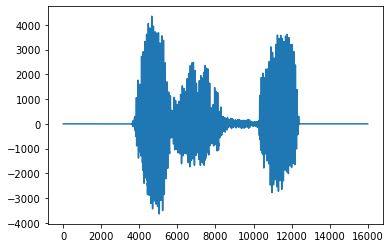

In [72]:
plt.plot(everything)

In [9]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
model_settings

{'desired_samples': 16000,
 'window_size_samples': 480,
 'window_stride_samples': 320,
 'spectrogram_length': 49,
 'fingerprint_width': 40,
 'fingerprint_size': 1960,
 'label_count': 100,
 'sample_rate': 16000,
 'preprocess': 'micro',
 'average_window_width': -1}

In [26]:
from tensorflow.lite.experimental.microfrontend.python.ops import (
    audio_microfrontend_op as frontend_op,
)
def to_micro_spectrogram(audio):
    sample_rate = model_settings["sample_rate"]
    window_size_ms = (
        model_settings["window_size_samples"] * 1000
    ) / sample_rate
    window_step_ms = (
        model_settings["window_stride_samples"] * 1000
    ) / sample_rate
    int16_input = tf.cast(tf.multiply(audio, 32768), tf.int16)
    # https://git.io/Jkuux
    micro_frontend = frontend_op.audio_microfrontend(
        int16_input,
        sample_rate=sample_rate,
        window_size=window_size_ms,
        window_step=window_step_ms,
        num_channels=model_settings["fingerprint_width"],
        out_scale=1,
        out_type=tf.float32,
    )
    output = tf.multiply(micro_frontend, (10.0 / 256.0))
    return output

In [5]:
sr = 16000 # sample rate
T = 1.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*440*t) 

In [6]:
ipd.Audio(x, rate=sr)

In [15]:
def play(audio):
    return ipd.Audio(audio,rate=16000)

In [28]:
def view(audio):
    s = to_micro_spectrogram(audio)
    s=s.numpy()
    fig,ax = plt.subplots()
    ax.imshow(s.T,origin='lower')
    ax.set_xlabel("time")
    ax.set_ylabel("freq")
    print(s.shape)

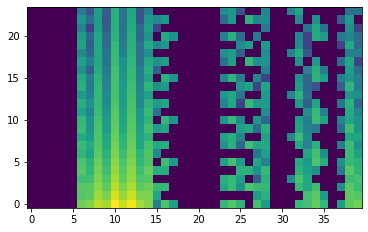

In [31]:
view(q)

In [32]:
s = to_micro_spectrogram(x)
s.shape

TensorShape([24, 40])

In [35]:
q.shape

(16000,)

In [33]:
q[:10]

array([0.        , 0.0294354 , 0.0587687 , 0.08789814, 0.11672268,
       0.14514234, 0.17305853, 0.20037442, 0.22699525, 0.25282869])

In [77]:
def gen(hz, T=0.5,a=0.5):
    sr = 16000 # sample rate
    t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
    return a*np.sin(2*np.pi*hz*t) 

In [15]:
sr = 16000 # sample rate
T = 0.5    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*880*t) 

In [22]:
play(q)

(49, 40)


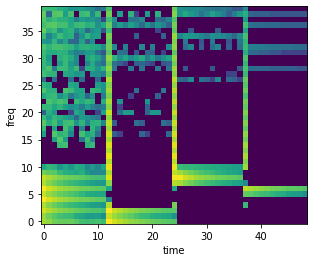

In [78]:
q = np.concatenate([gen(440,T=0.25),gen(220,T=0.25),gen(660,T=0.25),gen(500,T=0.25)])
view(q)

(49, 40)


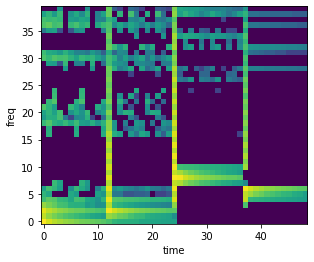

In [40]:
q = np.concatenate([gen(140,T=0.25),gen(220,T=0.25),gen(660,T=0.25),gen(500,T=0.25)])
view(q)

In [83]:
def hamgen(hz, T=0.25):
    wav = gen(hz,T)
    return np.hamming(wav.shape[0]) * np.hamming(wav.shape[0]) * wav

(49, 40)


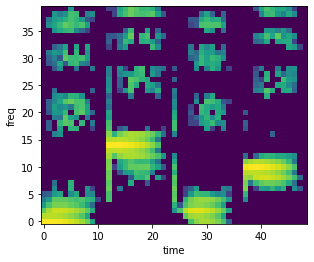

In [84]:
q = np.concatenate([hamgen(140,T=0.25),hamgen(1200,T=0.25),hamgen(200,T=0.25),hamgen(800,T=0.25)])
view(q)

In [46]:
play(q)

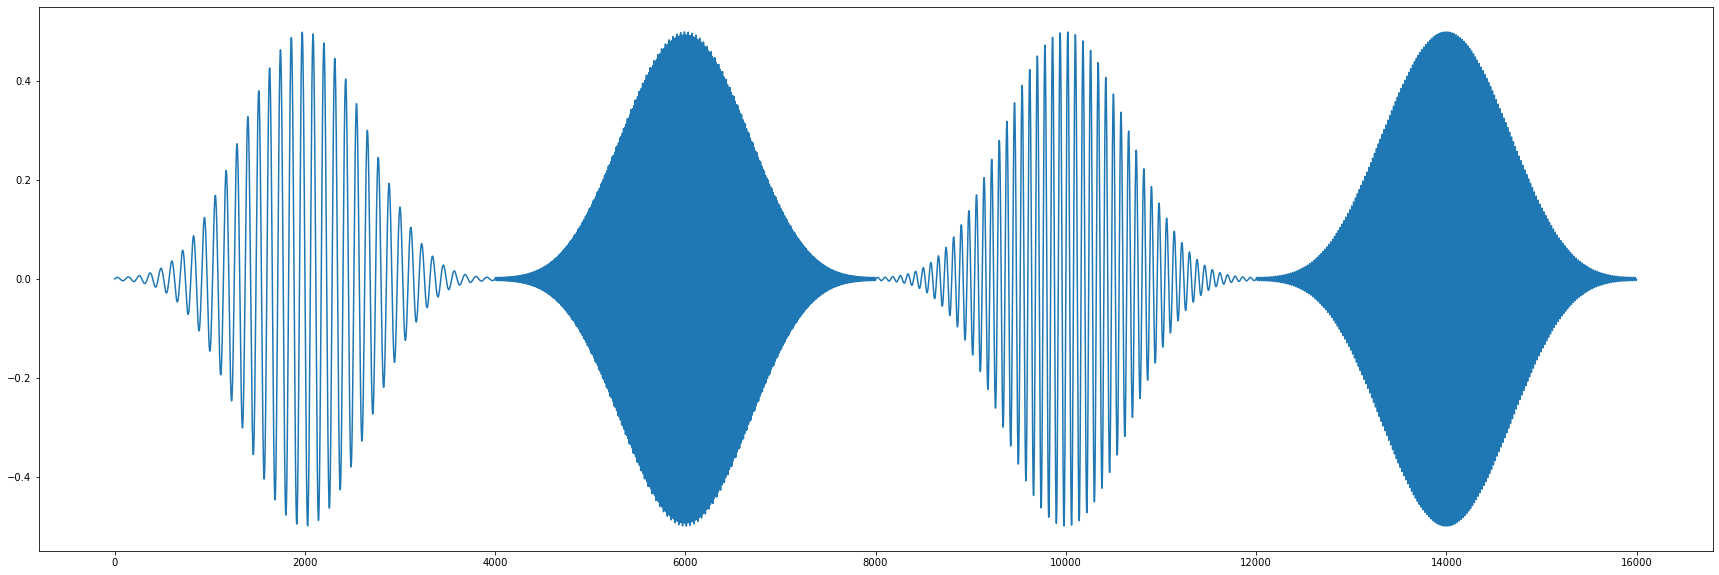

In [85]:
plt.plot(q)
plt.gcf().set_size_inches(30,10)

# select words

In [4]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"

In [5]:
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")

In [92]:
words = os.listdir(data_dir)
words = [w for w in words if w != "_background_noise_"]
words.sort()
words[:5]

['about', 'after', 'again', 'air', 'album']

In [93]:
np.random.seed(8675309)

In [94]:
commands = np.random.choice(words, 100, replace=False)

In [95]:
commands

array(['night', 'only', 'say', 'take', 'blue', 'how', 'ever', 'mind',
       'morning', 'family', 'than', 'please', 'nothing', 'next',
       'different', 'up', 'went', 'good', 'main', 'station', 'little',
       'might', 'right', 'hand', 'eyes', 'film', 'black', 'use', 'book',
       'air', 'never', 'district', 'know', 'gold', 'already', 'girl',
       'party', 'yes', 'better', 'some', 'game', 'through', 'way', 'born',
       'those', 'them', 'three', 'saw', 'four', 'heard', 'one', 'king',
       'father', 'men', 'something', 'boy', 'each', 'school', 'park',
       'during', 'go', 'things', 'first', 'seen', 'road', 'again',
       'second', 'should', 'number', 'love', 'time', 'off', 'red', 'done',
       'now', 'thought', 'read', 'told', 'which', 'played', 'company',
       'old', 'like', 'world', 'answered', 'been', 'music', 'year',
       'fire', 'found', 'seven', 'away', 'everything', 'here', 'more',
       'town', 'put', 'both', 'who', 'often'], dtype='<U10')

In [96]:
assert(len(set(commands))==len(commands))

In [97]:
# note: this cell is not idempotent, uses seed state
NUM_SAMPLES = 2000

files = []
for c in commands:
    wavs = glob.glob(data_dir + c + "/*.wav")
    wavs.sort()
    wavs = np.random.choice(wavs, 2000, replace=False)
    assert(len(wavs) == NUM_SAMPLES)
    files.extend(wavs)

In [98]:
# note: this cell is not idempotent, uses seed state
files.sort()
np.random.shuffle(files)

In [99]:
files[:10]

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/black/common_voice_en_22093056.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/yes/common_voice_en_18546627.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/go/common_voice_en_527798.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/know/common_voice_en_534724.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/second/common_voice_en_22370992.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/different/common_voice_en_20105594.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/next/common_voice_en_17279499.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/fire/common_voice_en_622767.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/town/common_voice_en_20027291.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/film/common_voice_en_22272423.wav']

In [ ]:
raise ValueError("caution: overwrites current training list")
with open("wordlist.txt", 'w') as fh:
    for c in commands:
        fh.write(f"{c}\n")
with open("files.txt", 'w') as fh:
    for f in files:
        fh.write(f"{f}\n")

# load words

In [4]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")

In [5]:
with open("wordlist.txt", "r") as fh:
    commands = fh.read().splitlines()
with open("files.txt", "r") as fh:
    files = fh.read().splitlines()    

In [6]:
files[:10]

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/black/common_voice_en_22093056.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/yes/common_voice_en_18546627.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/go/common_voice_en_527798.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/know/common_voice_en_534724.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/second/common_voice_en_22370992.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/different/common_voice_en_20105594.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/next/common_voice_en_17279499.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/fire/common_voice_en_622767.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/town/common_voice_en_20027291.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/film/common_voice_en_22272423.wav']

# training w frontend

In [7]:
ten_pct = int(0.1 * len(files))
train_split = ten_pct * 8 
val_split = train_split + ten_pct

train_files = files[:train_split]
val_files = files[train_split:val_split]
test_files = files[val_split:]

print(len(train_files), len(val_files), len(test_files))

160000 20000 20000


In [8]:
assert len(set(train_files).intersection(set(val_files))) == 0
assert len(set(val_files).intersection(set(test_files))) == 0
assert len(set(train_files).intersection(set(test_files))) == 0

In [9]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [10]:
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)

In [11]:
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [135]:
input_shape = (49,40,1)
num_labels=len(a.commands) # will include silence/unknown
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    #layers.Dense(128, activation='tanh'),
    #layers.Dense(128, activation='relu'),
    layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'),
    # must use alpha-dropout if dropout is desired with selu
    layers.Dense(num_labels),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=0.001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 38, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 36, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25344)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6488320   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [12]:
# mobilenet/resnet
input_shape = (49,40,1)
num_labels=len(a.commands) # will include silence/unknown

base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights=None, #"imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None
    #classes=1000,
    #classifier_activation="softmax",
)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
#layers.Dropout(0.5)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(128, kernel_initializer='lecun_normal', activation='selu')(x)
# must use alpha-dropout if dropout is desired with selu
logits = layers.Dense(num_labels)(x)

model = models.Model(inputs=base_model.input, outputs=logits)

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=0.001
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 55, 46, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 20, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 27, 22, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [13]:
EPOCHS = 50

checkpoint_filepath="hundredword_resnet_2k_selu_specaug.{epoch:02d}-{val_accuracy:.2f}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback]
    # callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
    #            tf.keras.callbacks.LearningRateScheduler(scheduler)],
)

Epoch 1/50
2500/2500 [==============================] - ETA: 0s - loss: 2.2979 - accuracy: 0.3978WARNING:tensorflow:From /home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: hundredword_resnet_2k_selu_specaug.01-0.42/assets
2500/2500 [==============================] - 239s 96ms/step - loss: 2.2979 - accuracy: 0.3978 - val_loss: 2.2910 - val_accuracy: 0.4205
Epoch 2/50
2500/2500 [==============================] - 241s 97ms/step - loss: 1.2999 - accuracy: 0.6393 - val_loss: 1.4630 - val_accuracy: 0.6051
Epoch 3/50
2500/2500 [==============

In [10]:
model = tf.keras.models.load_model("./hundredword_2k_selu.39-0.81")

In [137]:
model = tf.keras.models.load_model("./hundredword_64wide_2k_selu.44-0.79")

In [64]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu.48-0.87")

In [19]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu_specaug.44-0.87")

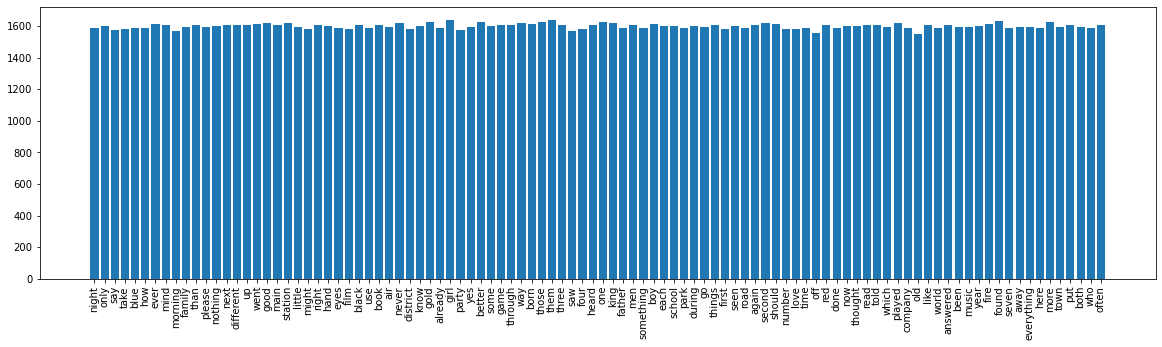

In [118]:
counts = {c:0 for c in commands}
for f in train_files:
    word = f.split(os.path.sep)[-2]
    counts[word] += 1   
plt.bar(list(counts.keys()), counts.values())
plt.xticks(rotation=90);
plt.gcf().set_size_inches(20,5)    

In [13]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 2000 == 0:
        print(ix)
    #if ix > 8000:
    #    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
Test set accuracy: 86%


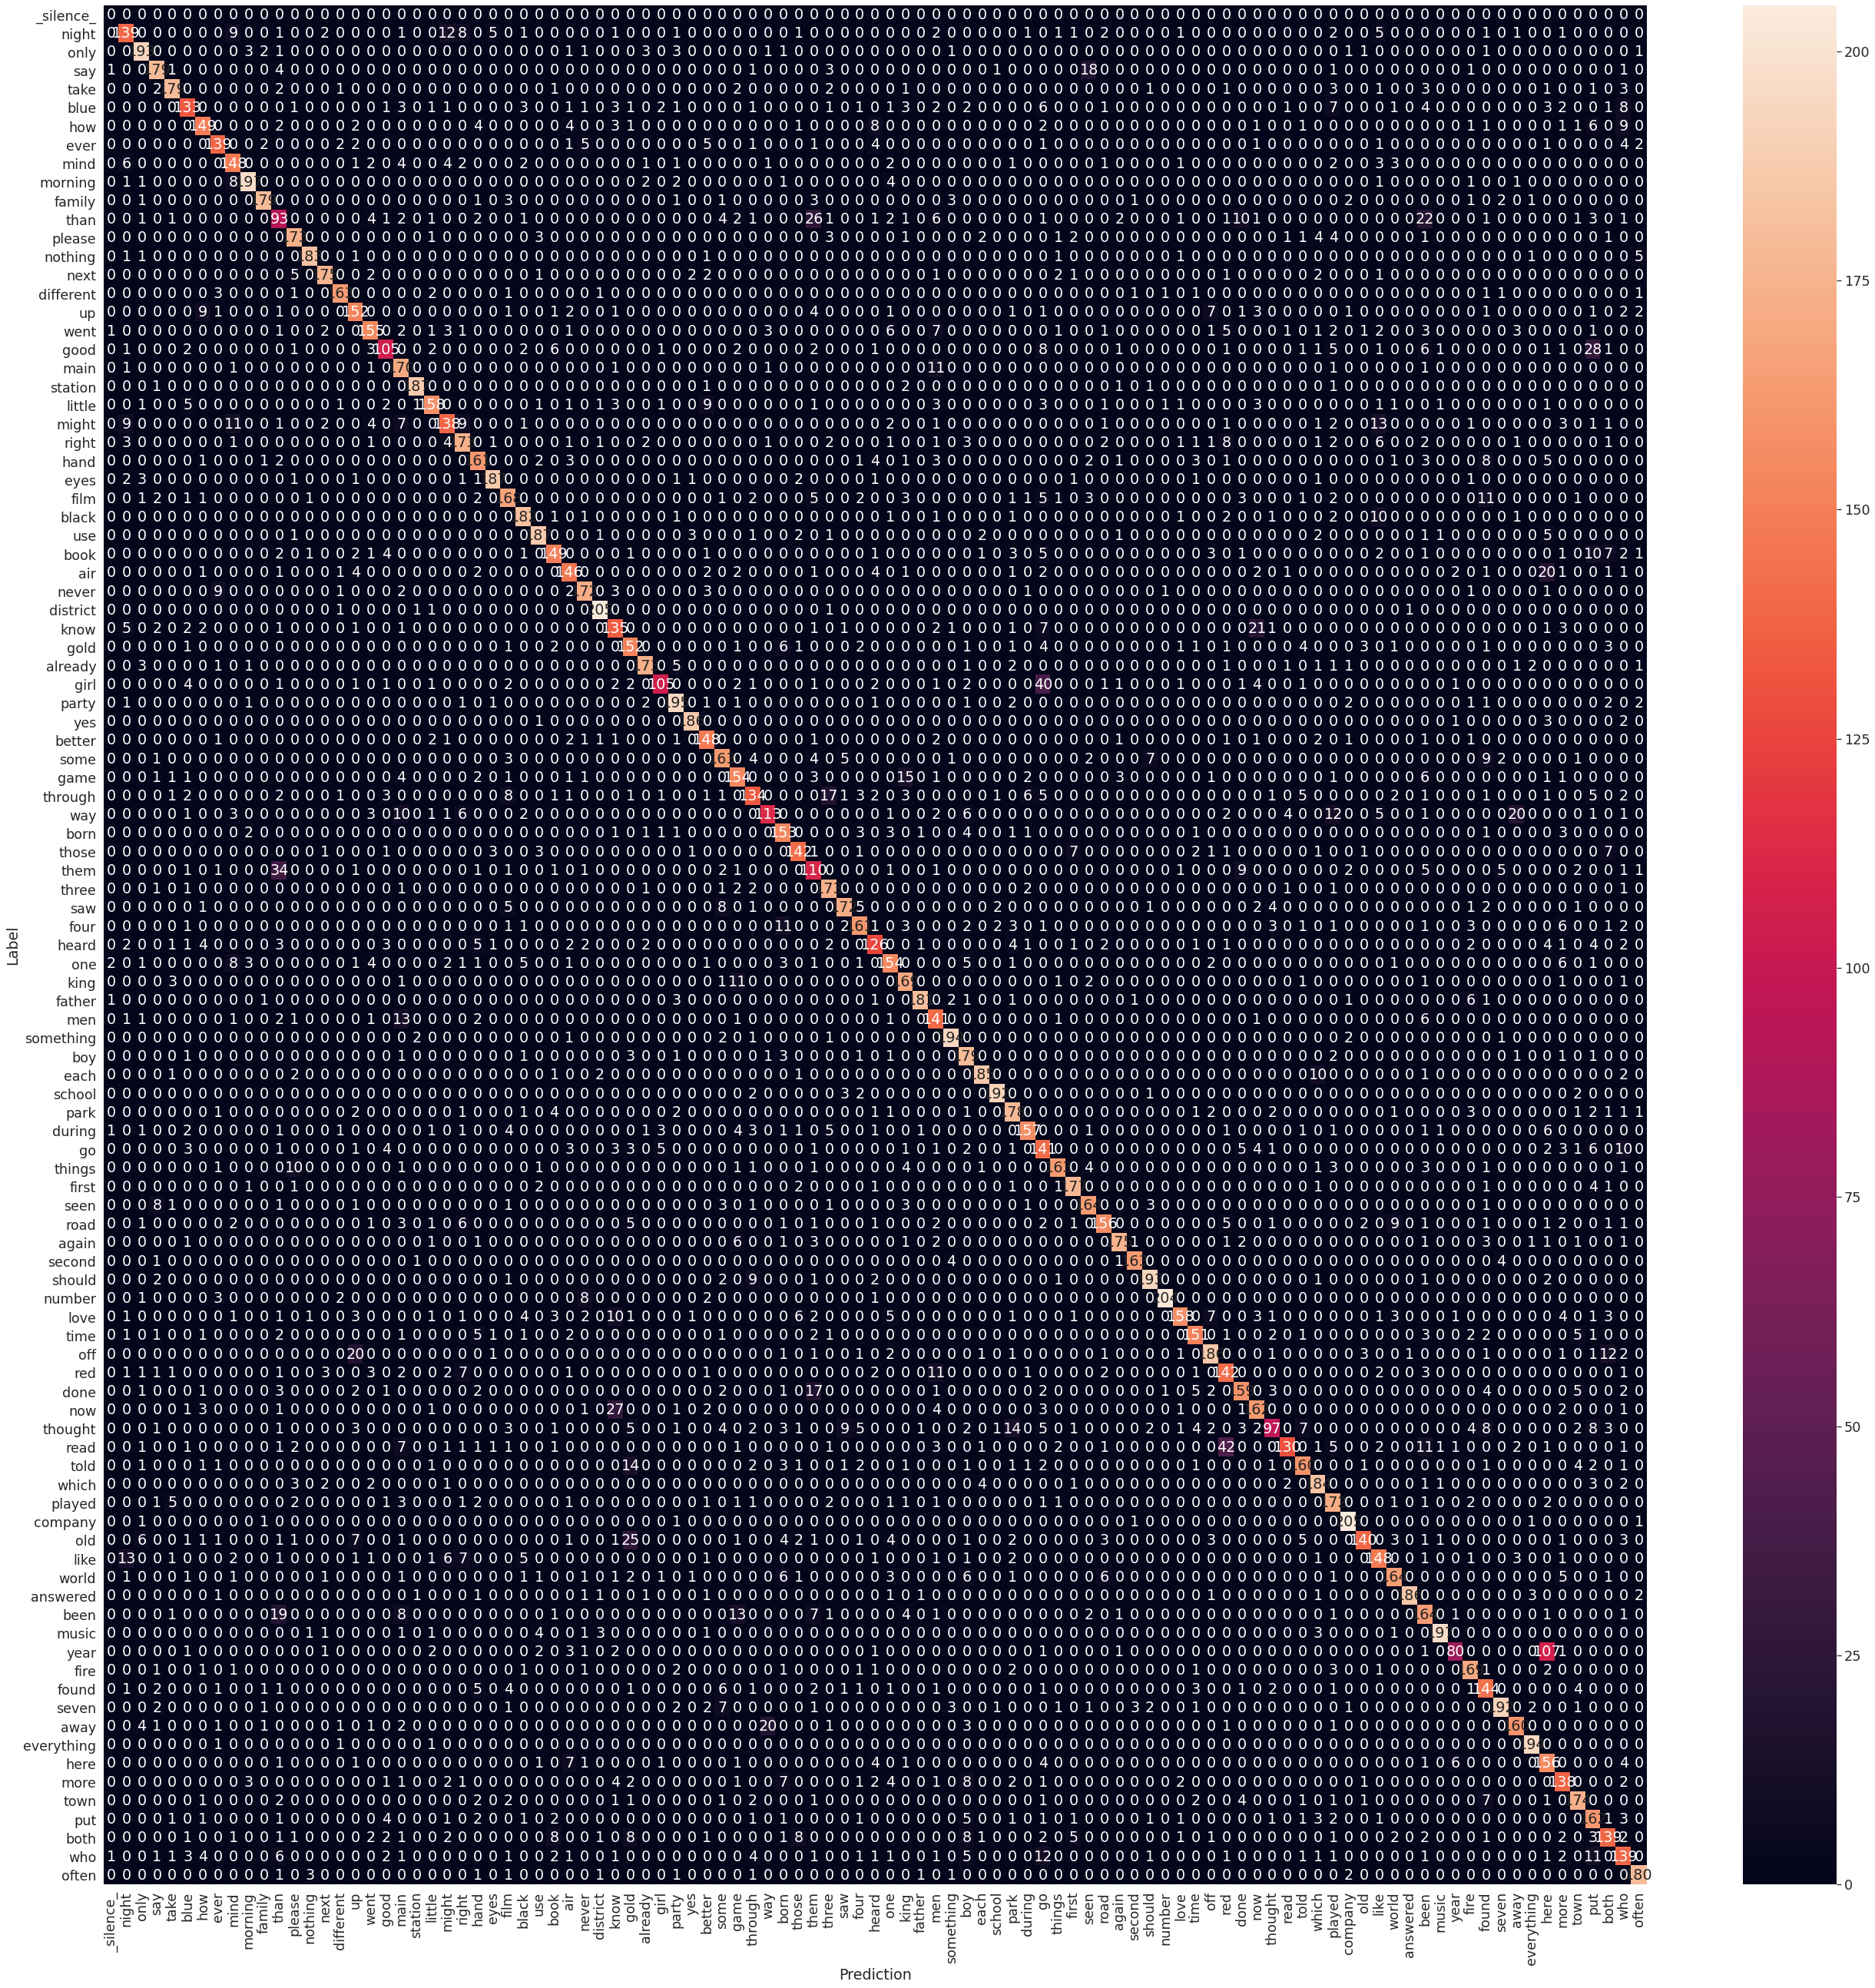

In [211]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
cmds = [c.numpy().decode('utf-8') for c in a.commands]
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=cmds, yticklabels=cmds, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.gcf().set_size_inches(45,45)

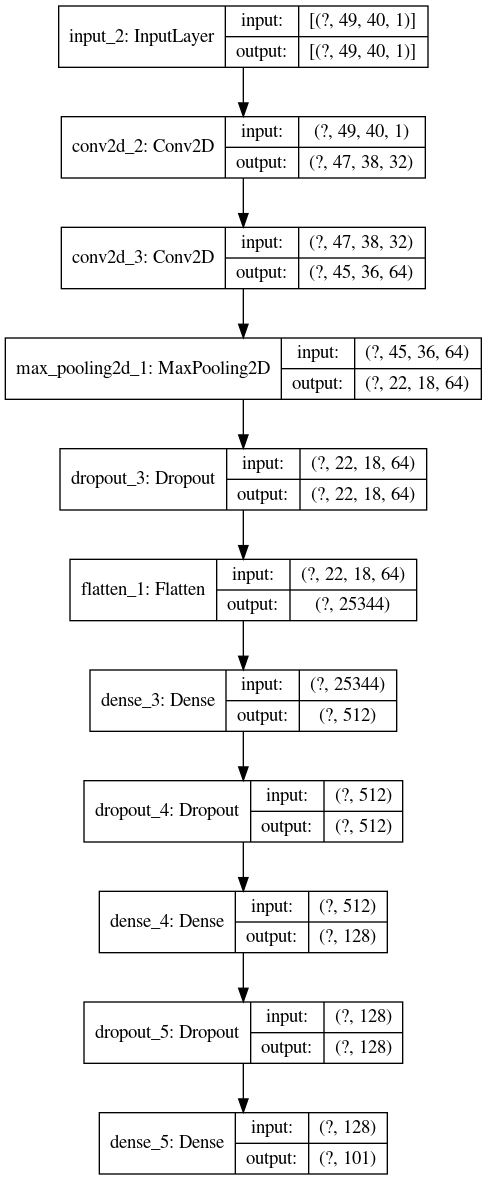

In [8]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    #show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

# listen + view

`/home/mark/tinyspeech_harvard/frequent_words/en/clips/book/common_voice_en_21548475.wav` is `book` but sounds like `put`

/home/mark/tinyspeech_harvard/frequent_words/en/clips/family/common_voice_en_20445461.wav
groundtruth family
prediction family


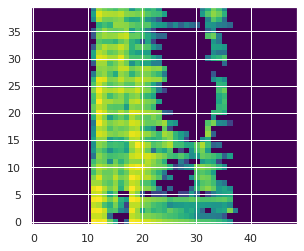

In [31]:
ix = np.random.randint(len(test_files))
f = test_files[ix]
print(f)

s = a.file2spec(f)
print("groundtruth", f.split("/")[-2])
plt.imshow(s.numpy().T, origin="lower", cmap="viridis");

pred = model.predict(s.numpy().reshape(1,49,40,1))
p = np.argmax(pred)
print("prediction", a.commands[p].numpy().decode('utf8'))

_,wav = wavfile.read(f)
ipd.Audio(wav,rate=16000)

# enrollment

In [63]:
"/home/mark/tinyspeech_harvard/frequent_words/en/clips/"

'/home/mark/tinyspeech_harvard/frequent_words/en/clips/'

In [13]:
other_words = [w for w in os.listdir(data_dir) if w != "_background_noise_" and w not in commands]
other_words.sort()
print(len(other_words))
assert(len(set(other_words).intersection(commands))==0)

165


In [14]:
other_words[:10]

['about',
 'after',
 'album',
 'alchemist',
 'also',
 'always',
 'another',
 'anything',
 'appeared',
 'area']

In [34]:
candidate_word_ix = np.random.randint(len(other_words))
candidate_word = other_words[candidate_word_ix]
print(candidate_word)
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
example = np.random.choice(candidates)
print(example)
_,wav = wavfile.read(example)
ipd.Audio(wav,rate=16000)

public
/home/mark/tinyspeech_harvard/frequent_words/en/clips/public/common_voice_en_21740761.wav


```
/home/mark/tinyspeech_harvard/frequent_words/en/clips/national/common_voice_en_22251317.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/national/common_voice_en_19009678.wav
```

In [35]:
another = np.random.choice(candidates)
print(another)
_,wav = wavfile.read(another)
ipd.Audio(wav,rate=16000)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/public/common_voice_en_20961207__3.wav


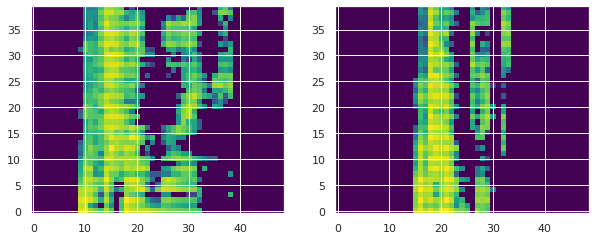

In [37]:
fig,ax = plt.subplots(ncols=2)
for i,e in enumerate([example, another]):
    s = a.file2spec(e)
    ax[i].imshow(s.numpy().T, origin="lower", cmap="viridis")
fig.set_size_inches(10,5);

In [65]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 49, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 55, 46, 1)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 20, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 27, 22, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [20]:
#https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_16").output)

In [139]:
#https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_1").output)

In [66]:
#https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_21").output)

In [21]:
#https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction
penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_2").output)

In [67]:
def to_embedding(file_path):
    spectrogram = a.file2spec(file_path, add_bg=False)
    spectrogram = spectrogram.numpy().reshape(1,49,40,1)
    embedding = penultimate.predict(spectrogram)
    return np.squeeze(embedding)

In [68]:
e = to_embedding("/home/mark/tinyspeech_harvard/frequent_words/en/clips/national/common_voice_en_22251317.wav")
f = to_embedding("/home/mark/tinyspeech_harvard/frequent_words/en/clips/national/common_voice_en_19009678.wav")
print(e.shape, f.shape)

(128,) (128,)


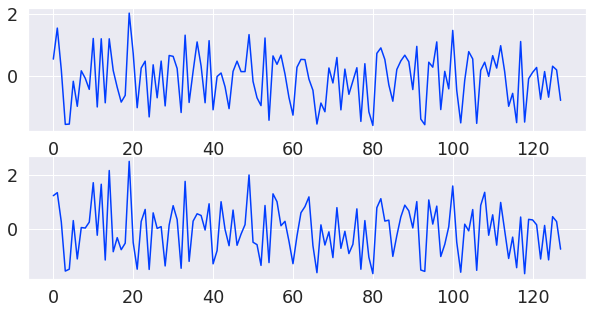

In [69]:
fig,ax=plt.subplots(nrows=2)
ax[0].plot(e)
ax[1].plot(f)
fig.set_size_inches(10,5);

In [221]:
e

array([-0.97676545, -1.758098  , -1.7202184 , -0.73166895, -1.73016   ,
       -1.1023821 ,  0.31681103, -1.7518913 ,  3.2024488 ,  1.07414   ,
       -1.7580963 ,  4.1420283 , -1.7548404 ,  0.7700236 ,  2.877599  ,
       -1.7563505 ,  0.27390334, -1.4983441 , -1.6036078 , -1.3608425 ,
       -1.7382127 ,  1.453898  , -1.7575921 , -1.7580605 ,  1.413953  ,
       -1.3224772 , -1.7388465 , -1.7563862 , -1.7562909 , -1.0675308 ,
       -1.7580453 ,  0.30064404, -1.7486025 , -1.7563193 , -1.7236079 ,
       -1.7432922 , -1.745595  , -0.8716746 , -1.6508166 ,  0.9618455 ,
       -1.6875422 , -1.3486011 , -1.7580867 ,  0.26731598,  2.8887365 ,
        1.4851081 , -1.014017  , -1.649356  ,  2.7148795 ,  7.007488  ,
       -1.753435  , -1.757144  ,  2.0613422 , -1.3694075 , -1.7578002 ,
       -1.734113  , -1.7552801 ,  1.1153773 ,  5.018991  ,  0.7237116 ,
       -1.7375107 , -1.7232975 , -1.5899738 , -1.7580817 ,  2.568042  ,
        2.4720829 , -1.7019889 , -1.7384622 , -1.6154773 , -1.75

In [222]:
np.linalg.norm(e-f)

14.657355

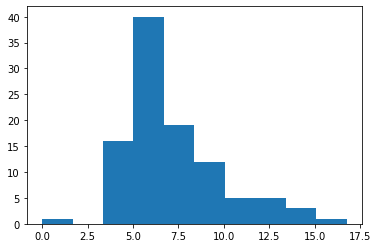

In [115]:
distances = []
for ix,cw in enumerate(candidates):
    embedding = to_embedding(cw)
    d = np.linalg.norm(e-embedding)
    distances.append(d)
    if ix > 100:
        break
plt.hist(distances);

system


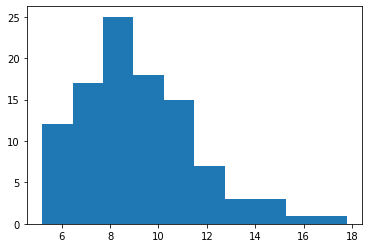

In [120]:
rand_ix = np.random.randint(len(other_words))
different_word = other_words[rand_ix]
print(different_word)

distances=[]
for ix,cw in enumerate(glob.glob(f"{data_dir}{different_word}/*.wav")):
    embedding = to_embedding(cw)
    d = np.linalg.norm(e-embedding)
    distances.append(d)
    if ix > 100:
        break
plt.hist(distances);        

In [145]:
candidate_word_ix = np.random.randint(len(other_words))
candidate_word = other_words[candidate_word_ix]
print(candidate_word)
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
target = np.random.choice(candidates)

In [78]:
candidate_word="appeared"
target = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav"

In [157]:
print("example path", example)
_,wav = wavfile.read(example)
ipd.Audio(wav,rate=16000)

example path /home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav


appeared /home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav


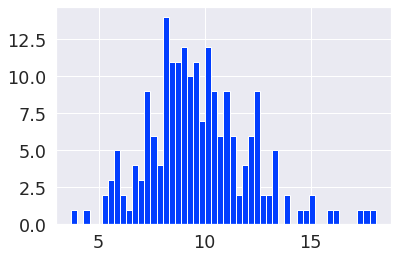

In [79]:
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
print(candidate_word, target)
NUM_SAMPLES=200
samples = np.random.choice(candidates, NUM_SAMPLES, replace=False)
samples = [s for s in samples if s != target]

distances_to_target=[]
target_embedding = to_embedding(target)
for ix,w in enumerate(samples):
    e = to_embedding(w)
    d = np.linalg.norm(target_embedding - e)
    distances_to_target.append(d)

plt.hist(distances_to_target,bins=50);    

In [238]:
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
print(candidate_word, target)
NUM_SAMPLES=200
samples = np.random.choice(candidates, NUM_SAMPLES, replace=False)
samples = [s for s in samples if s != target]
target_embedding = to_embedding(target)
for ix,w in enumerate(samples):
    e = to_embedding(w)
    d = np.linalg.norm(target_embedding-e)
    if d > 30:
        print(w)
        print(d)
        break
_,wav = wavfile.read(w)
ipd.Audio(wav,rate=16000)

appeared /home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_565635.wav
30.570553


In [28]:
sns.set(font_scale=1.6)
sns.set_palette("bright")

part


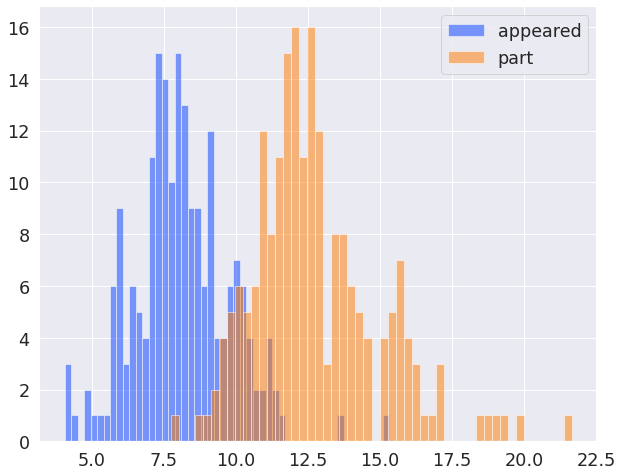

In [29]:
another_word = np.random.choice(other_words)
print(another_word)
another_wavs = glob.glob(f"{data_dir}{another_word}/*.wav")
another_samples = np.random.choice(another_wavs, NUM_SAMPLES, replace=False)

distances_to_another = []
for ix,w in enumerate(another_samples):
    e = to_embedding(w)
    d = np.linalg.norm(target_embedding - e)
    distances_to_another.append(d)
    
plt.hist(distances_to_target,bins=50, alpha=0.5, label=candidate_word, color=sns.color_palette("bright")[0]);    
plt.hist(distances_to_another,bins=50, alpha=0.5, label=another_word, color=sns.color_palette("bright")[1]);
plt.legend(loc='upper right');
plt.gcf().set_size_inches(10,8);

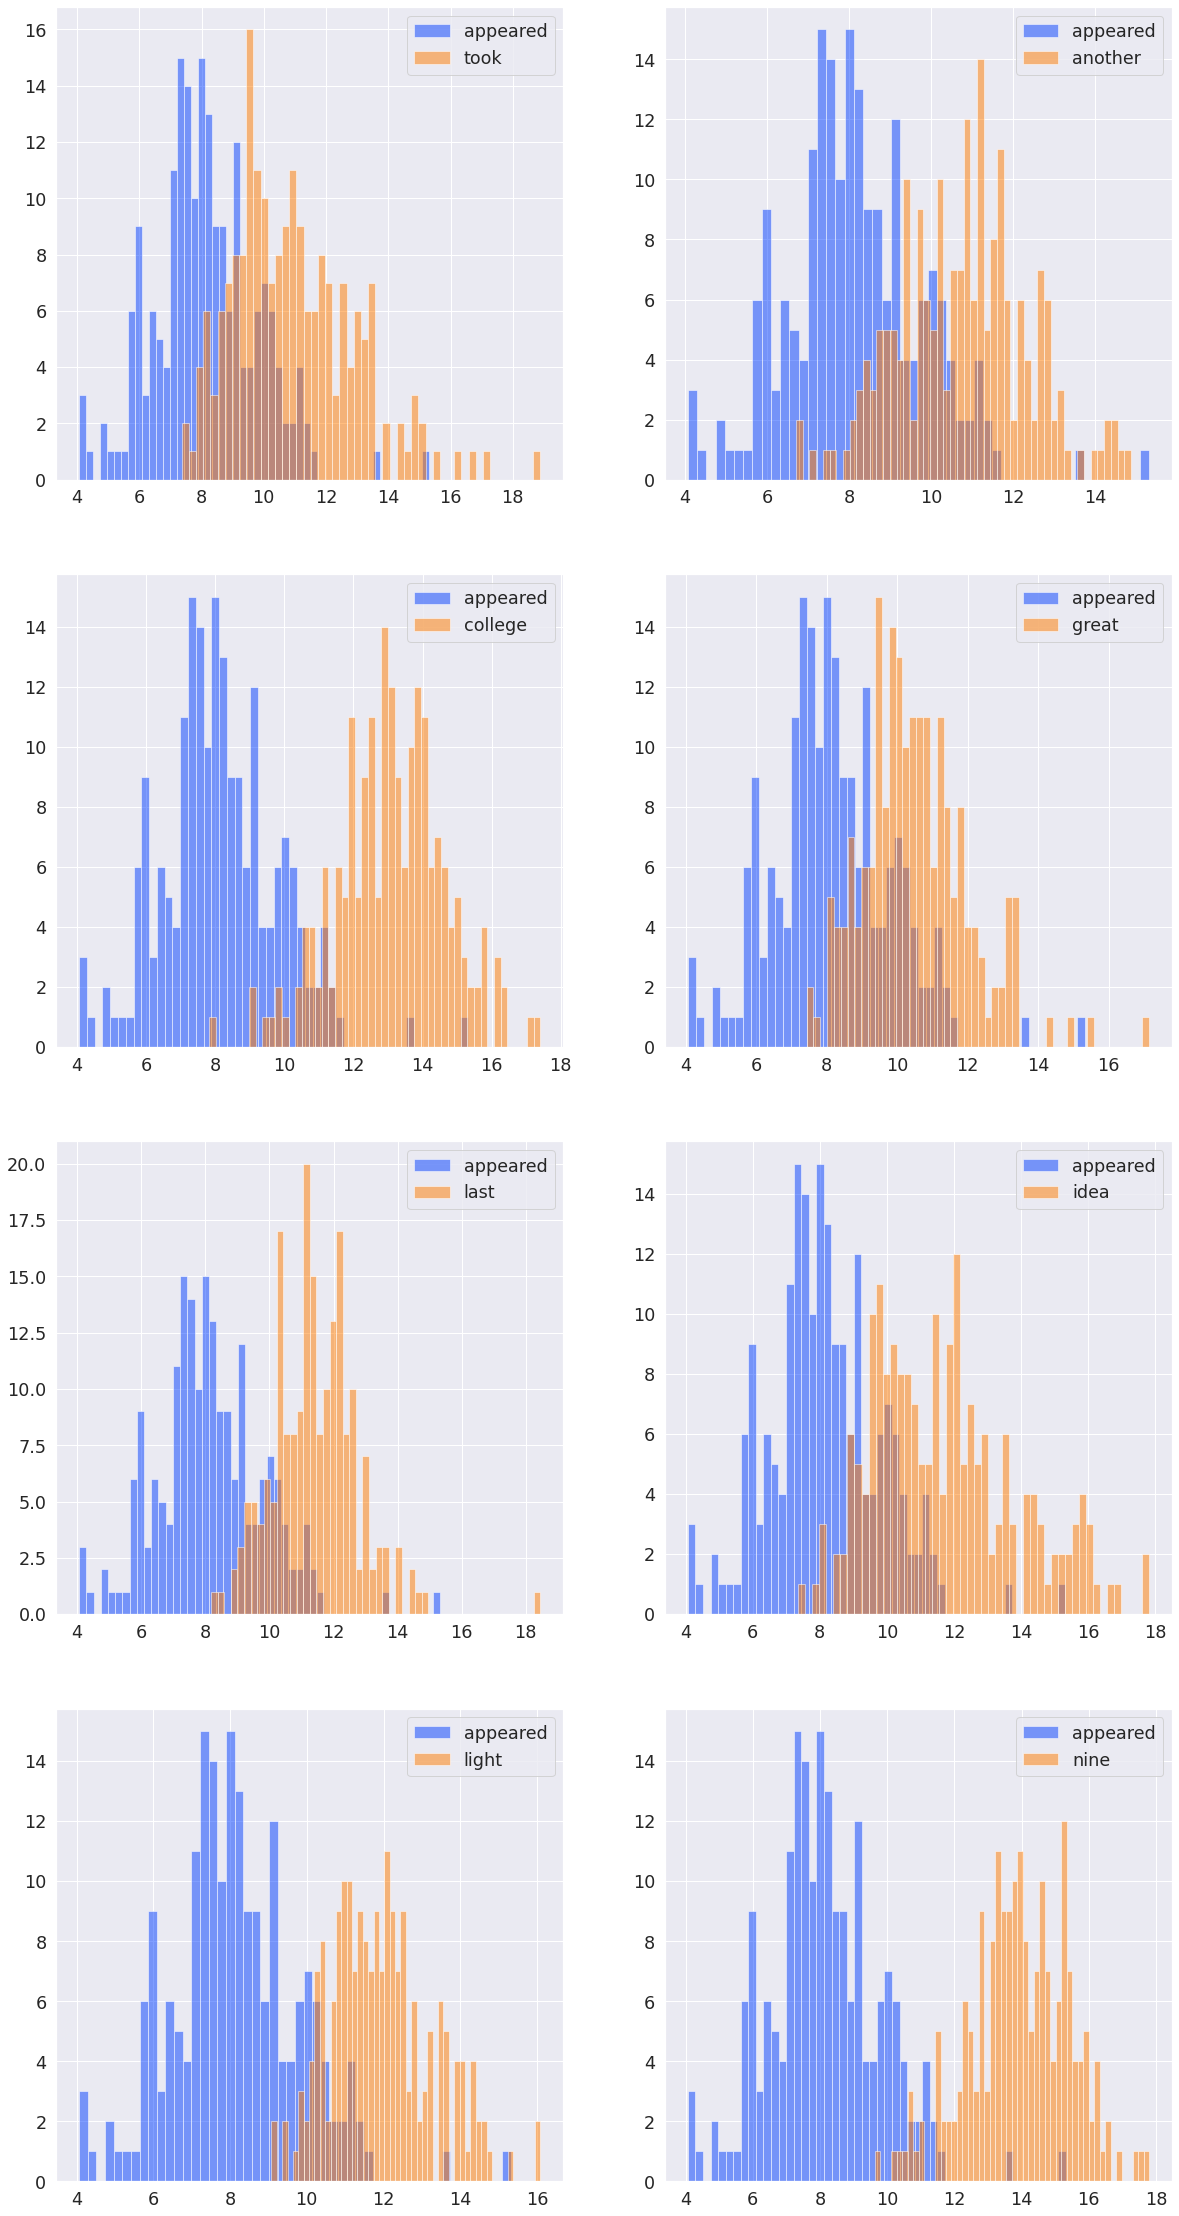

In [30]:
vsrelu = ["took", "another", "college", "great", "last", "idea", "light", "nine",]
fig,axes = plt.subplots(nrows=4,ncols=2)
for ix,another_word in enumerate(vsrelu):
    
    another_wavs = glob.glob(f"{data_dir}{another_word}/*.wav")
    another_samples = np.random.choice(another_wavs, NUM_SAMPLES, replace=False)

    distances_to_another = []
    for w in another_samples:
        e = to_embedding(w)
        d = np.linalg.norm(target_embedding - e)
        distances_to_another.append(d)
    
    axc = ix % 2
    axr = ix // 2
    ax = axes[axr][axc]
    ax.hist(distances_to_target,bins=50, alpha=0.5, label=candidate_word, color=sns.color_palette("bright")[0]);    
    ax.hist(distances_to_another,bins=50, alpha=0.5, label=another_word, color=sns.color_palette("bright")[1]);
    ax.legend(loc='upper right');
fig.set_size_inches(20,40);

# zero-shot and few-shot analysis

In [4]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")
with open("wordlist.txt", "r") as fh:
    commands = fh.read().splitlines()
with open("files.txt", "r") as fh:
    files = fh.read().splitlines()    
    
ten_pct = int(0.1 * len(files))
train_split = ten_pct * 8 
val_split = train_split + ten_pct

train_files = files[:train_split]
val_files = files[train_split:val_split]
test_files = files[val_split:]

print(len(train_files), len(val_files), len(test_files))    
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

160000 20000 20000


In [5]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu.48-0.87")

penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_21").output)

In [82]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 6000 == 0:
        print(ix)
    #if ix > 8000:
    #    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

0
6000
12000
18000
Test set accuracy: 87%


In [6]:
other_words = [w for w in os.listdir(data_dir) if w != "_background_noise_" and w not in commands]
other_words.sort()
print(len(other_words))
assert(len(set(other_words).intersection(commands))==0)

165


In [7]:
def to_embedding(file_path):
    spectrogram = a.file2spec(file_path, add_bg=False)
    spectrogram = spectrogram.numpy().reshape(1,49,40,1)
    embedding = penultimate.predict(spectrogram)
    return np.squeeze(embedding)

In [29]:
sns.set(font_scale=1)
sns.set_palette("bright")

In [9]:
candidate_word="appeared"
target = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav"

appeared /home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20522625.wav


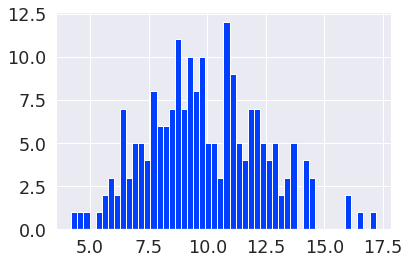

In [15]:
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
print(candidate_word, target)
NUM_SAMPLES=200
samples = np.random.choice(candidates, NUM_SAMPLES, replace=False)
samples = [s for s in samples if s != target]

distances_to_target=[]
target_embedding = to_embedding(target)
for ix,w in enumerate(samples):
    e = to_embedding(w)
    d = np.linalg.norm(target_embedding - e)
    distances_to_target.append(d)

values, bins, _ = plt.hist(distances_to_target,bins=50);    

In [11]:
from sklearn import metrics
# https://stackoverflow.com/a/26399395 How to get the area under a histogram in python

In [19]:
bins.shape, values.shape

((51,), (50,))

In [22]:
area = sum(np.diff(bins)*values)
area

51.97827863693237

In [92]:
mean = np.mean(distances_to_target)
sigma = np.std(distances_to_target)
print(mean, sigma, "thresh", 2 * sigma + mean)

9.810324 2.7558787 thresh 15.322081089019775


In [94]:
np.percentile(distances_to_target, 80)

11.985921478271484

In [95]:
np.quantile(distances_to_target, .8)

11.985921478271484

In [101]:
sns.set(font_scale=1)

In [111]:
non_target_words = np.random.choice(other_words, 5 + 1, replace=False)
non_target_words = [w for w in non_target_words if w != candidate_word]
len(non_target_words[:5])

5

In [114]:

ntd = np.array(non_target_distances)
print(ntd.shape)
print(threshold)
print(ntd[ntd>threshold].shape)

pct_correct_rejected = ntd[ntd>threshold].shape[0] / NUM_SAMPLES
print(pct_correct_rejected)

(200,)
11.850415802001953
(196,)
0.98


# target words selected blindly

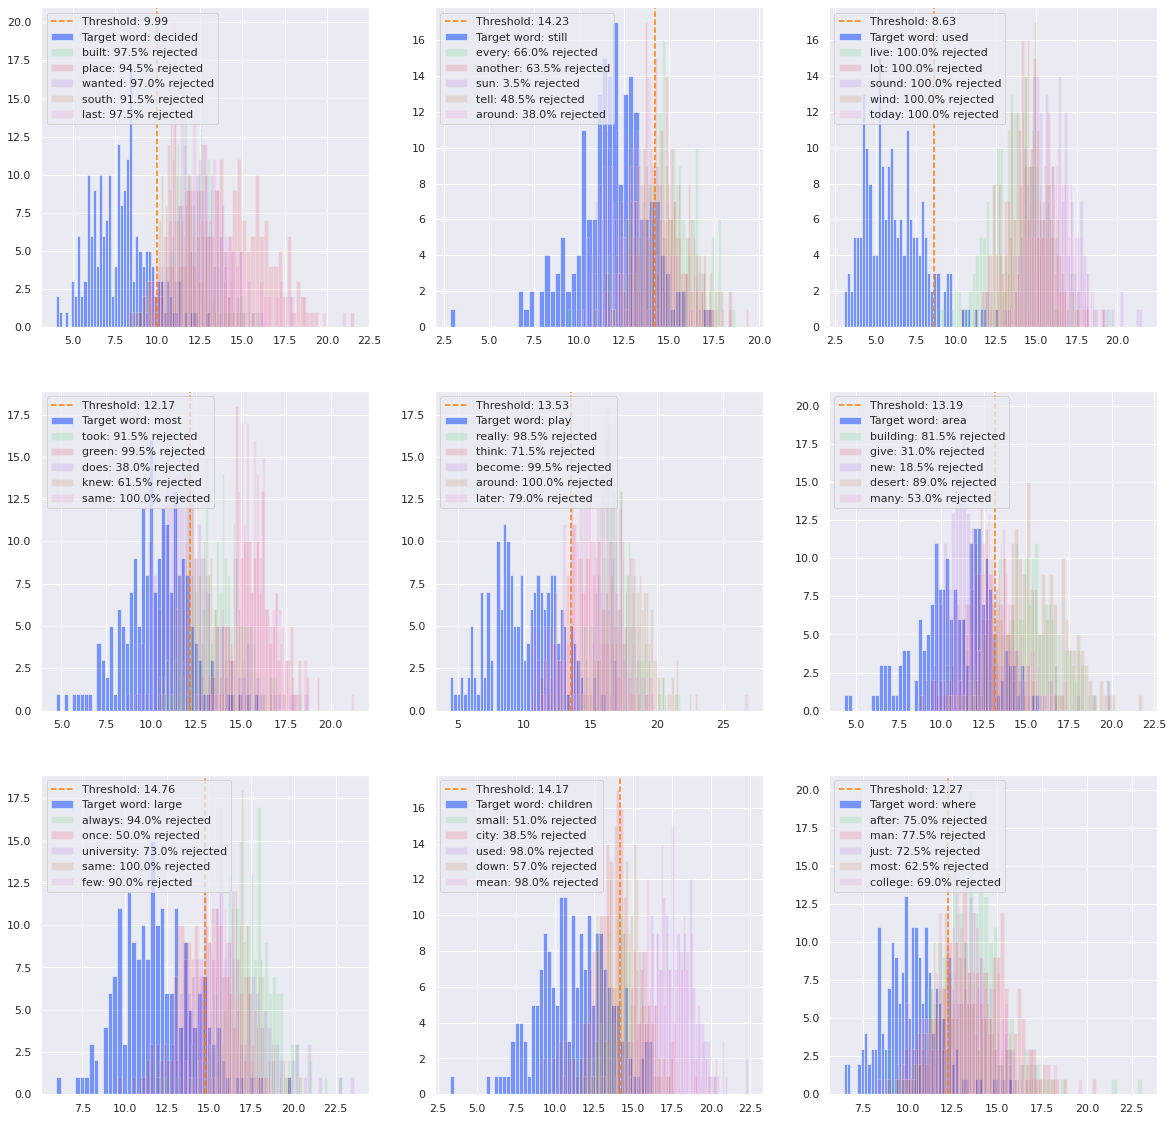

In [119]:
NUM_SAMPLES=200
THRESH = 0.9
NON_TARGET_WORDS = 5

NUM_WORDS =9
nrows,ncols = 3,3
fig,axes= plt.subplots(nrows=nrows,ncols=ncols)
assert nrows * ncols == NUM_WORDS

candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
for ix,candidate_word in enumerate(candidate_words):
    row = ix // nrows
    col = ix % ncols
    ax = axes[row][col]
    
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + 1, replace=False)

    target = samples[0]
    additional_samples = samples[1:]

    target_embedding = to_embedding(target)
    distances = [np.linalg.norm(target_embedding - to_embedding(f)) for f in additional_samples]
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    # target distance distribution
    ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
    # target threshold
    ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = np.array([np.linalg.norm(target_embedding - to_embedding(f)) for f in non_target_samples])
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
   
    ax.legend(loc='upper left');    
fig.set_size_inches(20,20);

# few-shot target words selected blindly

many
wanted
called
high
eight
street
think
long
could


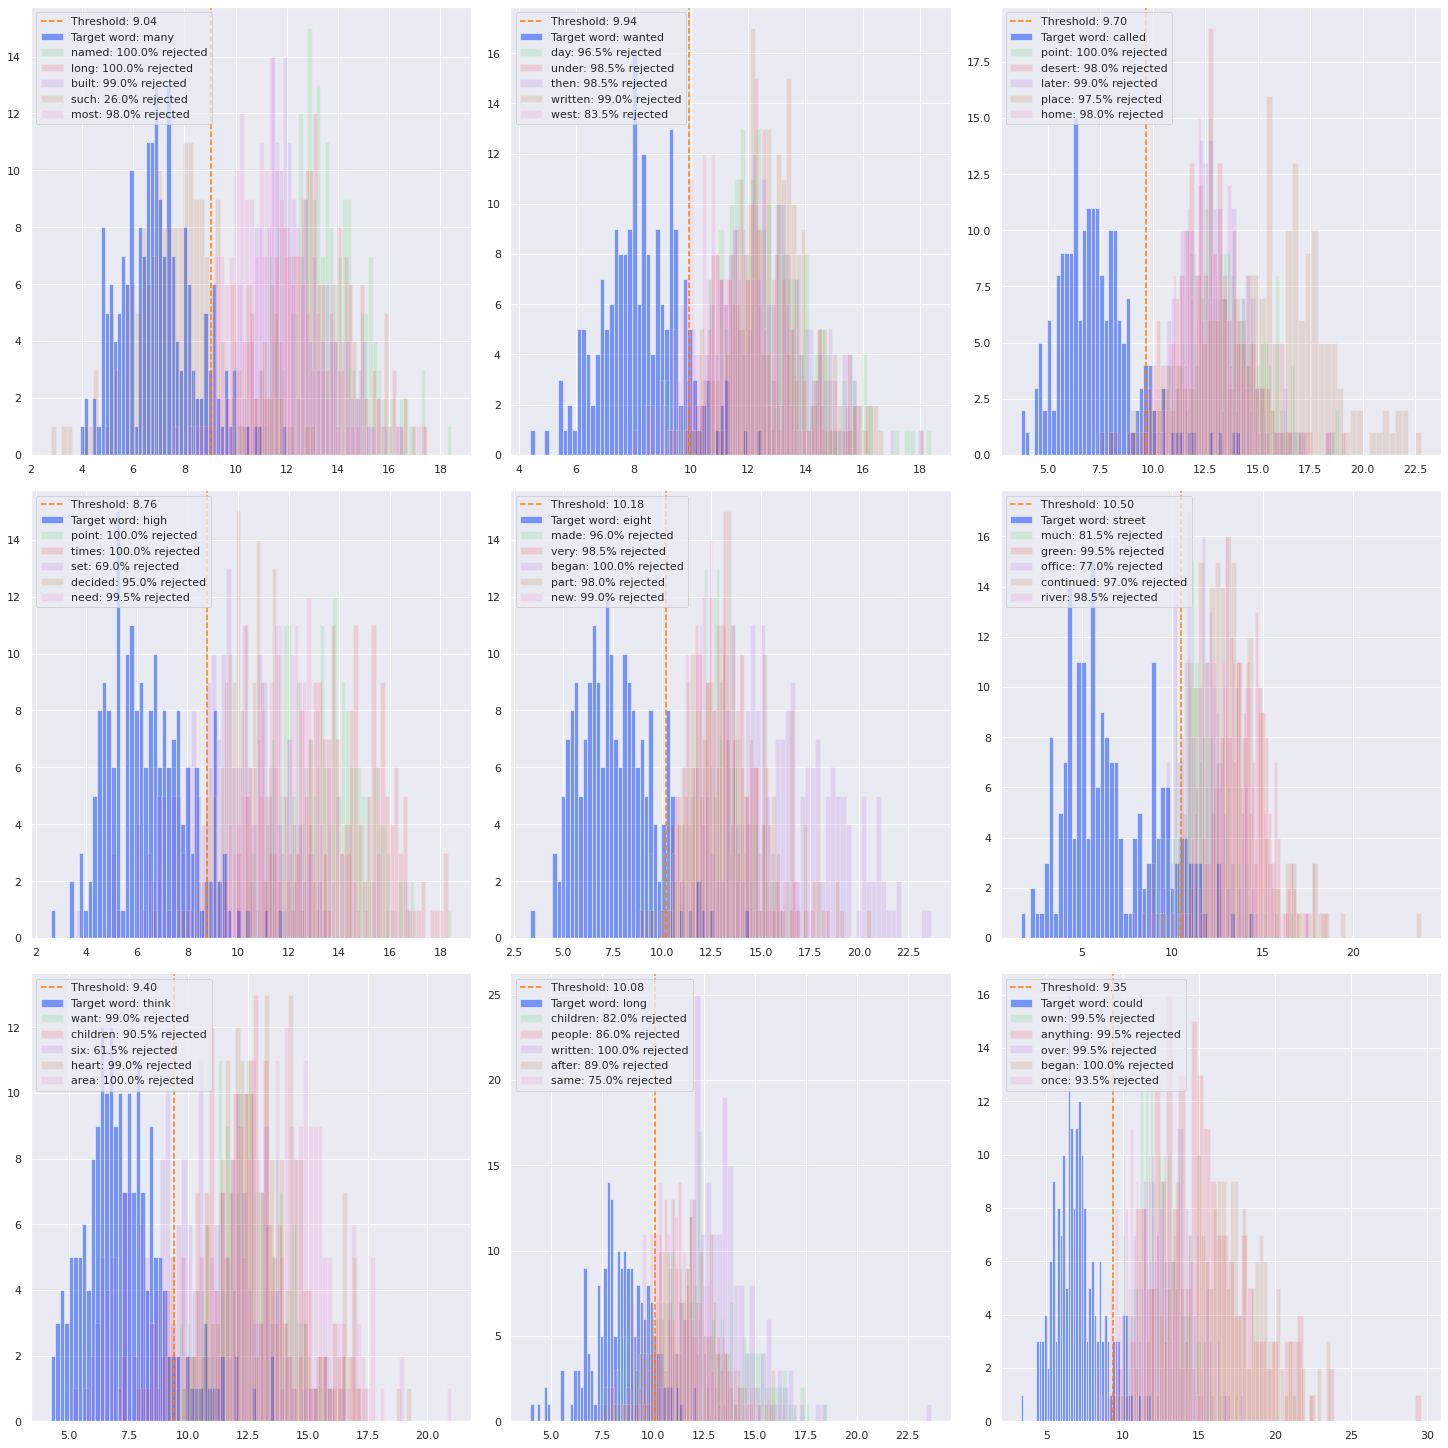

In [33]:
NUM_SAMPLES=200
THRESH = 0.9
NON_TARGET_WORDS = 5
FEW_SHOT = 5

NUM_WORDS =9
nrows,ncols = 3,3
fig,axes= plt.subplots(nrows=nrows,ncols=ncols,constrained_layout=True)
assert nrows * ncols == NUM_WORDS

def min_distance_to_embeddings(target_embeddings, file_path):
    e = to_embedding(file_path)
    distances = np.linalg.norm(target_embeddings - e, axis=1)
    return np.amin(distances)

candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
for ix,candidate_word in enumerate(candidate_words):
    row = ix // nrows
    col = ix % ncols
    ax = axes[row][col]
    print(candidate_word)
    
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + FEW_SHOT, replace=False)

    targets = samples[:FEW_SHOT]
    additional_samples = samples[FEW_SHOT:]

    target_embeddings = np.array([to_embedding(t) for t in targets])
    distances = [min_distance_to_embeddings(target_embeddings, f) for f in additional_samples]
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    # target distance distribution
    ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
    # target threshold
    ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = np.array([np.linalg.norm(target_embedding - to_embedding(f)) for f in non_target_samples])
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
   
    ax.legend(loc='upper left');    
fig.set_size_inches(20,20);

# zero-shot, but first listening to each target keyword

In [132]:
NUM_WORDS =9
candidate_words = np.random.choice(other_words, NUM_WORDS, replace=False)
print(candidate_words)

['building' 'river' 'find' 'several' 'most' 'high' 'looking' 'around'
 'such']


In [133]:
candidate_targets = [None for _ in range(NUM_WORDS)]

In [255]:
ix = 7
candidates = glob.glob(f"{data_dir}{candidate_words[ix]}/*.wav")
target = np.random.choice(candidates)
print(target)
ipd.Audio(target, autoplay=True)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav


In [256]:
candidate_targets[ix] = target
candidate_targets

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/building/common_voice_en_22037116.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/river/common_voice_en_18834695.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/find/common_voice_en_18473991.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/several/common_voice_en_19010622.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/most/common_voice_en_20582597.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/high/common_voice_en_21475412.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/looking/common_voice_en_492603.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/such/common_voice_en_19737650.wav']

In [257]:
raise ValueError("caution:overwrites")
with open("candidate_targets_9.txt",'w') as fh:
    fh.write("\n".join(candidate_targets))

In [25]:
with open("candidate_targets_9.txt", 'r') as fh:
    candidate_targets = fh.read().splitlines()

In [26]:
candidate_targets

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/building/common_voice_en_22037116.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/river/common_voice_en_18834695.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/find/common_voice_en_18473991.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/several/common_voice_en_19010622.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/most/common_voice_en_20582597.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/high/common_voice_en_21475412.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/looking/common_voice_en_492603.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/around/common_voice_en_18355828.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/such/common_voice_en_19737650.wav']

In [258]:
ix=7
ipd.Audio(candidate_targets[ix], autoplay=True)

building
river
find
several
most
high
looking
around
such


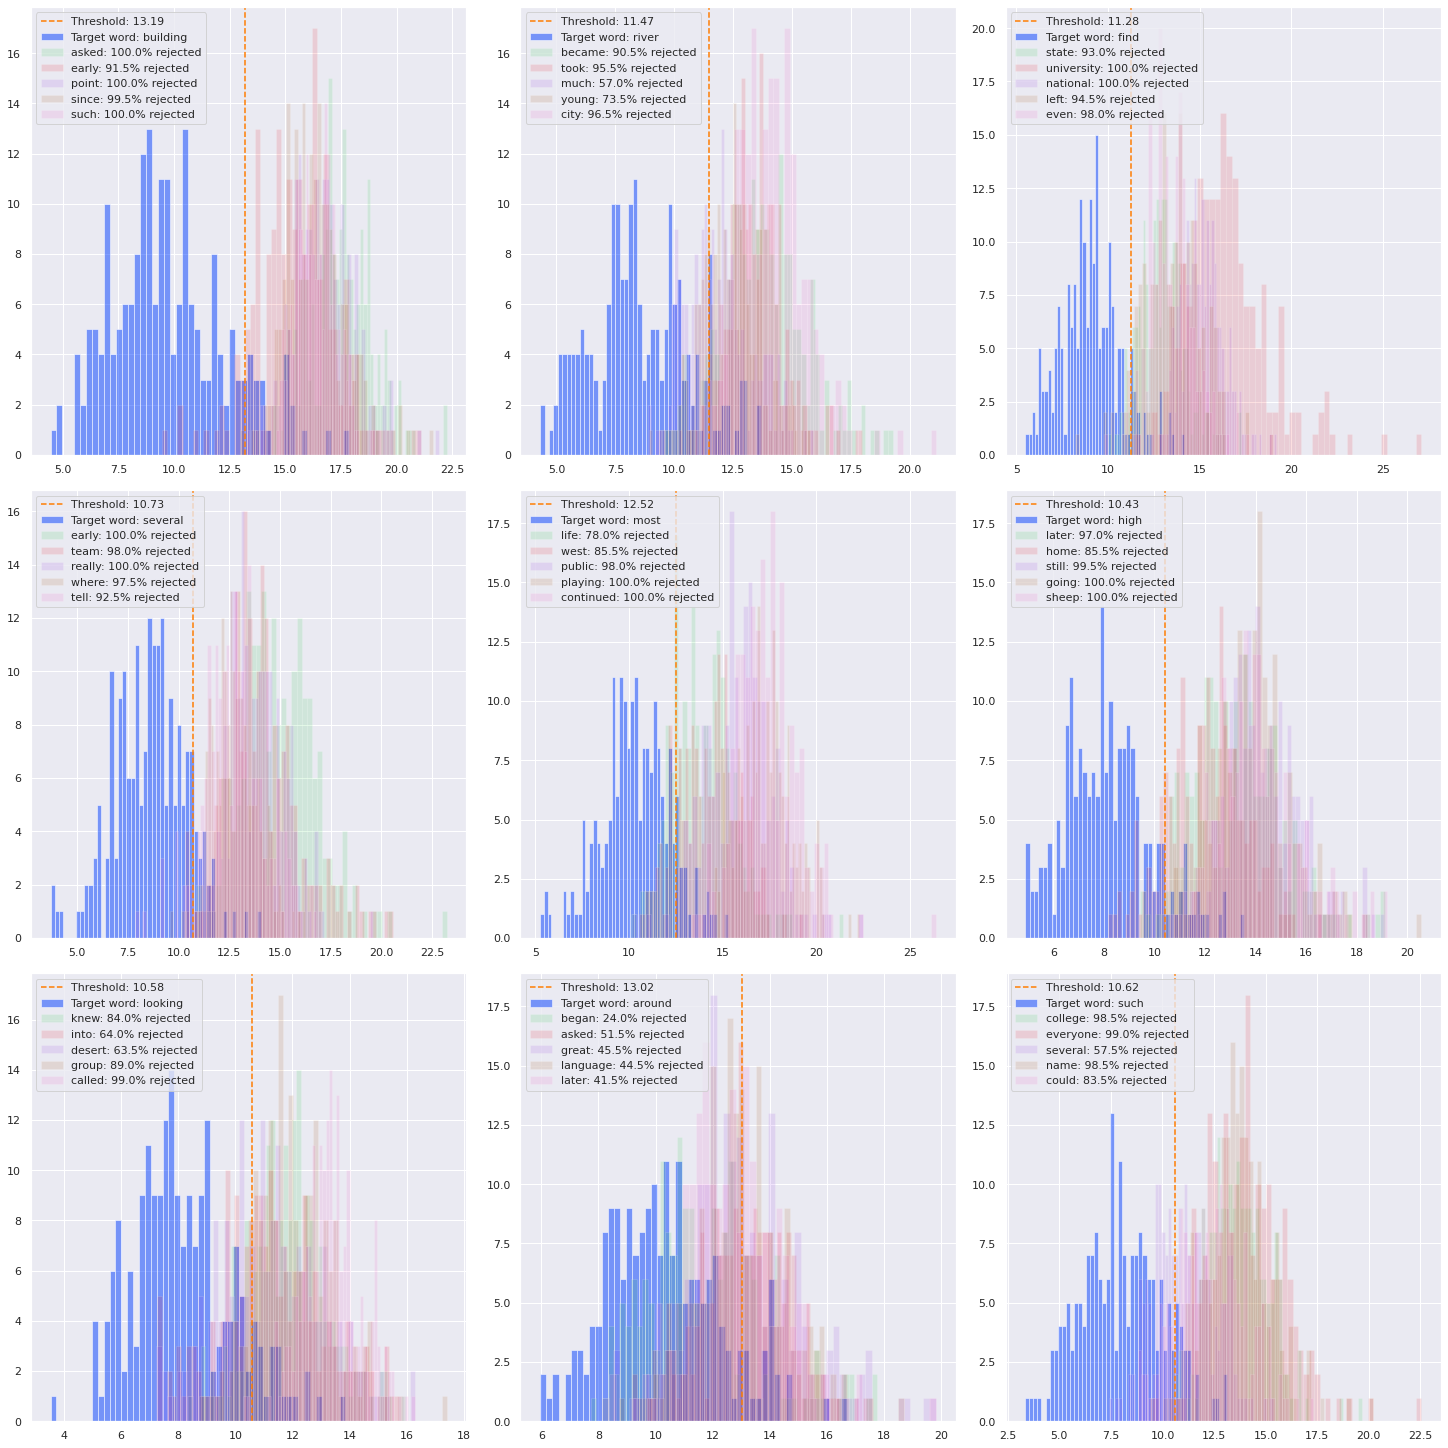

In [32]:
NUM_SAMPLES=200
THRESH = 0.90
NON_TARGET_WORDS = 5

NUM_WORDS =len(candidate_targets)
nrows,ncols = 3,3
#fig,axes= plt.subplots(nrows=nrows,ncols=ncols, gridspec_kw = {'wspace':0, 'hspace':0})
fig,axes= plt.subplots(nrows=nrows,ncols=ncols, constrained_layout=True)
assert nrows * ncols == NUM_WORDS

for ix,candidate_target in enumerate(candidate_targets):
    row = ix // nrows
    col = ix % ncols
    ax = axes[row][col]
    
    candidate_word = candidate_target.split("/")[-2]
    print(candidate_word)
    candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
    samples = np.random.choice(candidates, NUM_SAMPLES + 1, replace=False)
    samples = [w for w in samples if w != candidate_target][:NUM_SAMPLES]

    target_embedding = to_embedding(candidate_target)
    distances = [np.linalg.norm(target_embedding - to_embedding(f)) for f in samples]
    
    threshold = np.quantile(distances, THRESH)
    
    non_target_words = np.random.choice(other_words, NON_TARGET_WORDS + 1, replace=False)
    non_target_words = [w for w in non_target_words if w != candidate_word][:NON_TARGET_WORDS]
    
    # target distance distribution
    ax.hist(distances, bins=50, alpha=0.5, label=f"Target word: {candidate_word}", color=sns.color_palette("bright")[0]);
    # target threshold
    ax.axvline(x=threshold, label=f"Threshold: {threshold:.2f}", linestyle="--", color=sns.color_palette("bright")[1])
    
    for jx, w in enumerate(non_target_words):
        non_target_candidates = glob.glob(f"{data_dir}{w}/*.wav")
        non_target_samples = np.random.choice(non_target_candidates, NUM_SAMPLES, replace=False)
        non_target_distances = np.array([np.linalg.norm(target_embedding - to_embedding(f)) for f in non_target_samples])
        
        correct_rejected_pct = (non_target_distances[non_target_distances > threshold].shape[0] / NUM_SAMPLES) * 100
        
        ax.hist(non_target_distances, bins=50, alpha=0.125, label=f"{w}: {correct_rejected_pct:.1f}% rejected", color=sns.color_palette("bright")[jx + 2]);        
   
    ax.legend(loc='upper left');

fig.set_size_inches(20,20);

# transfer learning experiments 

In [269]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"
os.chdir("/home/mark/tinyspeech_harvard/train_100_augment/")
with open("wordlist.txt", "r") as fh:
    commands = fh.read().splitlines()
with open("files.txt", "r") as fh:
    files = fh.read().splitlines()    
    
ten_pct = int(0.1 * len(files))
train_split = ten_pct * 8 
val_split = train_split + ten_pct

train_files = files[:train_split]
val_files = files[train_split:val_split]
test_files = files[val_split:]

print(len(train_files), len(val_files), len(test_files))    
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

160000 20000 20000


In [270]:
model = tf.keras.models.load_model("./hundredword_resnet_2k_selu.48-0.87")

#penultimate = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer("dense_21").output)

In [271]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 6000 == 0:
        print(ix)
    #if ix > 8000:
    #    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

0
6000
12000
18000
Test set accuracy: 87%


In [272]:
other_words = [w for w in os.listdir(data_dir) if w != "_background_noise_" and w not in commands]
other_words.sort()
print(len(other_words))
assert(len(set(other_words).intersection(commands))==0)

165


In [273]:
" ".join(commands)

'night only say take blue how ever mind morning family than please nothing next different up went good main station little might right hand eyes film black use book air never district know gold already girl party yes better some game through way born those them three saw four heard one king father men something boy each school park during go things first seen road again second should number love time off red done now thought read told which played company old like world answered been music year fire found seven away everything here more town put both who often'

In [274]:
" " .join(other_words)

'about after album alchemist also always another anything appeared area around asked back based became because become before began being best between building built called children city college continued could county day days decided desert does down early earth east eight end englishman even every everyone few find five friend get give going great green group heart help high home house however idea include into just knew known language large last later left life light live local located long look looked looking lot made make man many matter mean money most much must name named national near need new nine north office once other over own part people place play playing point public really river same see served set several sheep show since six small son sound south state still street such sun system team tell then these thing think times today took under united university used very want wanted war water well west when where will wind without woman work would written years young'

In [275]:
np.random.choice(other_words, 5, replace=False)

array(['street', 'idea', 'lot', 'being', 'before'], dtype='<U10')

In [276]:
fiveword_xfer = ['street', 'idea', 'lot', 'being', 'before']

In [277]:
for w in fiveword_xfer:
    print(w in commands)

False
False
False
False
False


In [278]:
for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    print(len(wavs))

3220
3069
3166
4209
8583


In [279]:
mini_dataset = {}
mini_val = {}

N_UTTERANCES = 20

for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    selected = np.random.choice(wavs, 400, replace=False)
    
    mini_dataset[w] = selected[:N_UTTERANCES]
    mini_val[w] = selected[N_UTTERANCES:]

In [ ]:
model.summary()

In [303]:
# https://github.com/tensorflow/tfjs-models/blob/master/speech-commands/training/browser-fft/training_custom_audio_model_in_python.ipynb
#xfer = tf.keras.Sequential(name="TransferLearnedModel")
#for layer in model.layers[:-1]:
#    xfer.add(layer)
#xfer = tf.keras.models.clone_model(model)
#xfer.layers.pop()
#xfer.add(tf.keras.layers.Dense(units=5, activation="softmax"))   

# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
#for layer in xfer.layers[:-1]:
#    xfer.trainable = False

xfer = tf.keras.models.Model(name="TransferLearnedModel", inputs=model.inputs, outputs=model.get_layer(name="dense_21").output)
xfer.trainable = False

# dont use softmax here, since losses are from_logits
xfer = tf.keras.models.Sequential([xfer, tf.keras.layers.Dense(units=6)]) # 5 words + silence
    
xfer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [289]:
train_files = [f for d in mini_dataset.values() for f in d]
len(train_files)

100

In [290]:
val_files = [f for d in mini_val.values() for f in d]
len(val_files)

1900

In [293]:
np.random.shuffle(train_files)

In [295]:
train_files[:5]

['/home/mark/tinyspeech_harvard/frequent_words/en/clips/street/common_voice_en_549829.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/lot/common_voice_en_598232.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/being/common_voice_en_19717062.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/idea/common_voice_en_17269414.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/being/common_voice_en_589138.wav']

In [305]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, fiveword_xfer, bg_datadir, unknown_words=[], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
#test_ds = a.init(AUTOTUNE, test_files, is_training=False)
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=4000).batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [306]:
a.commands

<tf.Tensor: shape=(6,), dtype=string, numpy=
array([b'_silence_', b'street', b'idea', b'lot', b'being', b'before'],
      dtype=object)>

In [307]:
EPOCHS = 100
history = xfer.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    #callbacks=[model_checkpoint_callback]
    # callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
    #            tf.keras.callbacks.LearningRateScheduler(scheduler)],
)

Epoch 1/100
2/2 [==============================] - 1s 491ms/step - loss: 2.3147 - accuracy: 0.1400 - val_loss: 2.3448 - val_accuracy: 0.1153
Epoch 2/100
2/2 [==============================] - 0s 212ms/step - loss: 2.1056 - accuracy: 0.2100 - val_loss: 2.2087 - val_accuracy: 0.1384
Epoch 3/100
2/2 [==============================] - 0s 213ms/step - loss: 1.9715 - accuracy: 0.2900 - val_loss: 2.0780 - val_accuracy: 0.1705
Epoch 4/100
2/2 [==============================] - 0s 218ms/step - loss: 1.8832 - accuracy: 0.2900 - val_loss: 1.9515 - val_accuracy: 0.2116
Epoch 5/100
2/2 [==============================] - 0s 212ms/step - loss: 1.7800 - accuracy: 0.2700 - val_loss: 1.8307 - val_accuracy: 0.2579
Epoch 6/100
2/2 [==============================] - 0s 212ms/step - loss: 1.6745 - accuracy: 0.3700 - val_loss: 1.7141 - val_accuracy: 0.3079
Epoch 7/100
2/2 [==============================] - 0s 215ms/step - loss: 1.5576 - accuracy: 0.4100 - val_loss: 1.6027 - val_accuracy: 0.3689
Epoch 8/100
2

In [308]:
xfer.save("xfer_5word")

INFO:tensorflow:Assets written to: xfer_5word/assets


groundtruth idea /home/mark/tinyspeech_harvard/frequent_words/en/clips/idea/common_voice_en_18708296.wav
prediction idea


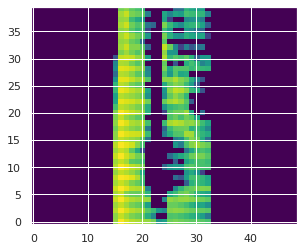

In [348]:
word = np.random.choice(fiveword_xfer)

f = np.random.choice(glob.glob(data_dir + word + "/*.wav"))

print("groundtruth", word, f)
spec = a.file2spec(f)

plt.imshow(spec.numpy().T, origin="lower", cmap="viridis");

pred = xfer.predict(spec.numpy().reshape(1,49,40,1))
p = np.argmax(pred)
print("prediction", a.commands[p].numpy().decode('utf8'))

_,wav = wavfile.read(f)
ipd.Audio(wav,rate=16000, autoplay=True)

In [349]:
len(train_files)

100

In [350]:
fiveword_xfer

['street', 'idea', 'lot', 'being', 'before']

In [351]:
len(val_files)

1900

# few-shot experiments

In [50]:
candidate_word_ix = np.random.randint(len(other_words))
candidate_word = other_words[candidate_word_ix]
print(candidate_word)

took


In [72]:
candidate_word="appeared"

In [73]:
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")

NUM_SHOTS=10
targets = np.random.choice(candidates, NUM_SHOTS, replace=False)

In [59]:
ix=np.random.choice(len(targets))
print(ix)
ipd.Audio(wavfile.read(targets[ix])[1], rate=16000)

4


In [74]:
target_embeddings = np.array([to_embedding(t) for t in targets])

In [75]:
def min_distance_to_embeddings(file_path):
    e = to_embedding(file_path)
    distances = np.linalg.norm(target_embeddings - e, axis=1)
    return np.amin(distances)

appeared ['/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_621066.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_46312.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_698480.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_19417046.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_20044995.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_19853817.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_18852298.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_59150.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_100900.wav'
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_18854184.wav']


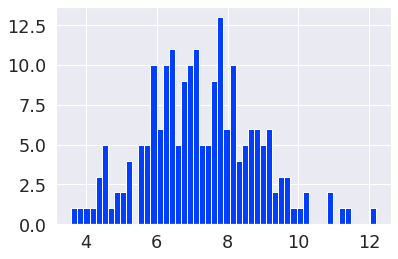

In [76]:
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
print(candidate_word, targets)
NUM_SAMPLES=200
samples = np.random.choice(candidates, NUM_SAMPLES, replace=False)
samples = [s for s in samples if s not in targets]

distances_to_target=[]

for ix,w in enumerate(samples):
    d = min_distance_to_embeddings(w)
    distances_to_target.append(d)

plt.hist(distances_to_target,bins=50);    

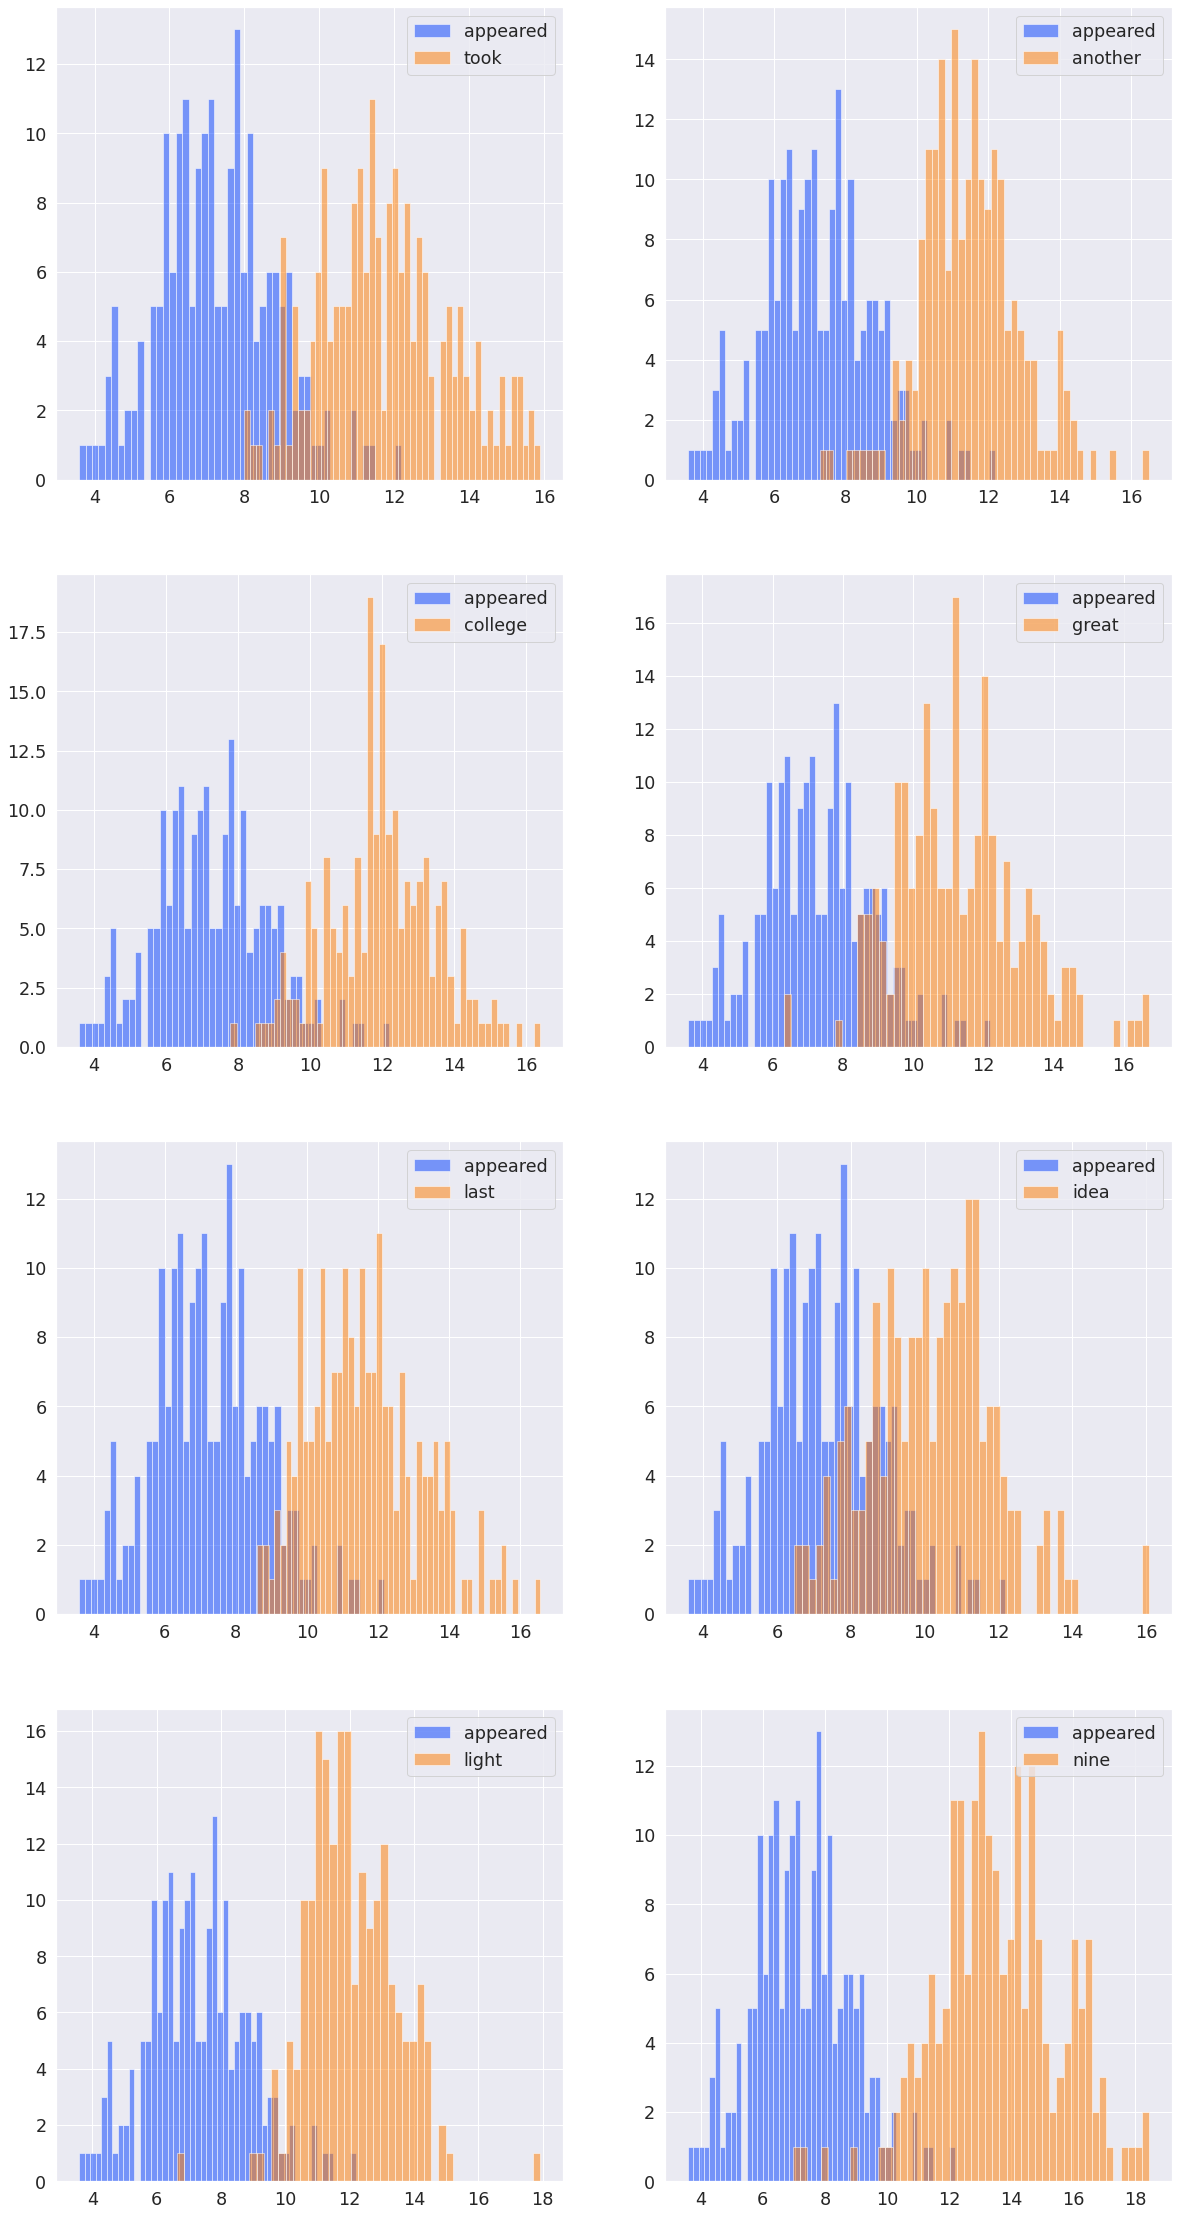

In [77]:
vsrelu = ["took", "another", "college", "great", "last", "idea", "light", "nine",]
fig,axes = plt.subplots(nrows=4,ncols=2)
for ix,another_word in enumerate(vsrelu):
    
    another_wavs = glob.glob(f"{data_dir}{another_word}/*.wav")
    another_samples = np.random.choice(another_wavs, NUM_SAMPLES, replace=False)

    distances_to_another = []
    for w in another_samples:
        
        d = min_distance_to_embeddings(w)
        distances_to_another.append(d)
    
    axc = ix % 2
    axr = ix // 2
    ax = axes[axr][axc]
    ax.hist(distances_to_target,bins=50, alpha=0.5, label=candidate_word, color=sns.color_palette("bright")[0]);    
    ax.hist(distances_to_another,bins=50, alpha=0.5, label=another_word, color=sns.color_palette("bright")[1]);
    ax.legend(loc='upper right');
fig.set_size_inches(20,40);

# double bottleneck with PCA

https://scikit-learn.org/stable/modules/decomposition.html#pca

https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [101]:
EXAMPLES_PER_WORD=600

all_wavs = []
for w in commands:
    wavs = glob.glob(f"{data_dir}{w}/*.wav")
    wavs = np.random.choice(wavs, EXAMPLES_PER_WORD, replace=False)
    all_wavs.extend(wavs)

np.random.shuffle(all_wavs)
print(len(all_wavs))
all_wavs[:10]

60000


['/home/mark/tinyspeech_harvard/frequent_words/en/clips/seven/common_voice_en_18551727.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/blue/common_voice_en_639359.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/company/common_voice_en_22149575.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/found/common_voice_en_107226.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/district/common_voice_en_19082861.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/been/common_voice_en_20636539.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/been/common_voice_en_20203466.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/something/common_voice_en_19727682.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_83259.wav',
 '/home/mark/tinyspeech_harvard/frequent_words/en/clips/often/common_voice_en_69041.wav']

In [102]:
bottleneck_data = np.zeros((len(all_wavs), 49, 40), dtype=np.float32)
for ix,wav_path in enumerate(all_wavs):
    spectrogram = a.file2spec(wav_path)
    bottleneck_data[ix] = spectrogram

In [103]:
bottleneck_predictions = penultimate.predict(np.expand_dims(bottleneck_data,-1))

In [104]:
bottleneck_predictions.shape

(60000, 128)

In [105]:
from sklearn.decomposition import PCA

In [106]:
N_COMPONENTS=32
pca = PCA(n_components=N_COMPONENTS,svd_solver='randomized',whiten=True).fit(bottleneck_predictions) #TODO(mmaz) should whiten=True or false?

In [107]:
rv = np.random.rand(128)
smallvec = pca.transform(np.expand_dims(rv,axis=0))
smallvec.shape

(1, 32)

In [108]:
def to_pca(file_path):
    embedding_128 = to_embedding(file_path)
    pca_vec = pca.transform(np.expand_dims(embedding_128,axis=0))
    return np.squeeze(pca_vec)

In [120]:
candidate_word="appeared"
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")
target = np.random.choice(candidates)
print(candidate_word, target)
ipd.Audio(target)

appeared /home/mark/tinyspeech_harvard/frequent_words/en/clips/appeared/common_voice_en_595256.wav


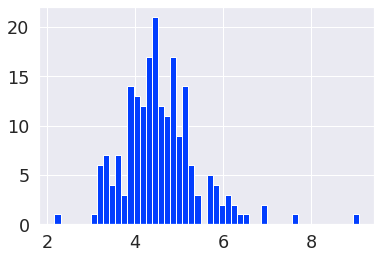

In [121]:
NUM_SAMPLES=200
samples = np.random.choice(candidates, 200, replace=False)
samples = [s for s in samples if s != target]

distances_to_target=[]
target_embedding = to_pca(target)
for ix,w in enumerate(samples):
    e = to_pca(w)
    d = np.linalg.norm(target_embedding - e)
    distances_to_target.append(d)

plt.hist(distances_to_target,bins=50);    

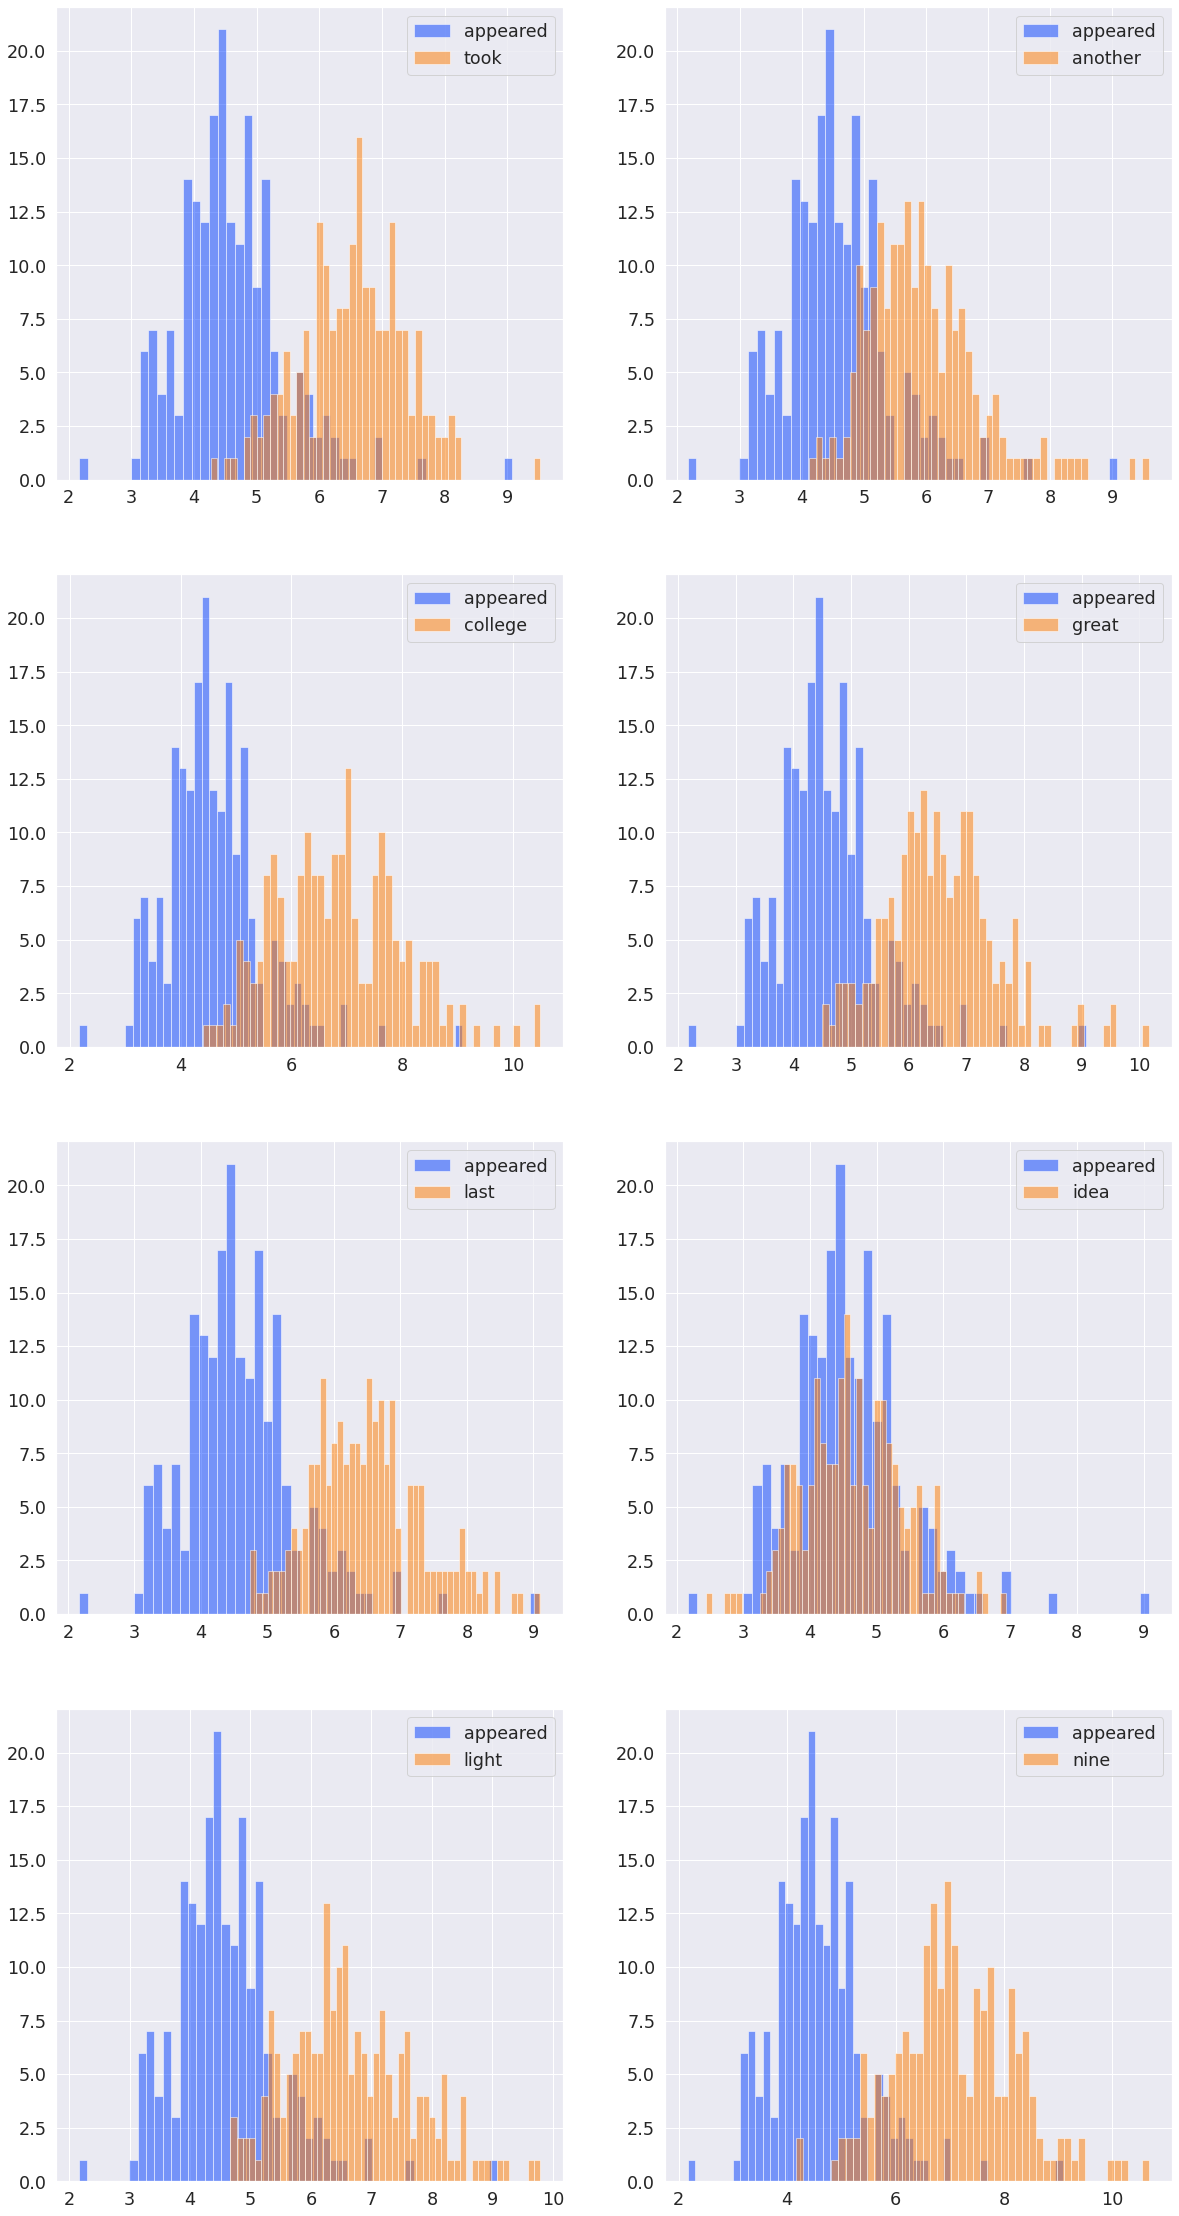

In [122]:
vsrelu = ["took", "another", "college", "great", "last", "idea", "light", "nine",]
fig,axes = plt.subplots(nrows=4,ncols=2)
for ix,another_word in enumerate(vsrelu):
    
    another_wavs = glob.glob(f"{data_dir}{another_word}/*.wav")
    another_samples = np.random.choice(another_wavs, NUM_SAMPLES, replace=False)

    distances_to_another = []
    for w in another_samples:
        e = to_pca(w)
        d = np.linalg.norm(target_embedding - e)
        distances_to_another.append(d)
    
    axc = ix % 2
    axr = ix // 2
    ax = axes[axr][axc]
    ax.hist(distances_to_target,bins=50, alpha=0.5, label=candidate_word, color=sns.color_palette("bright")[0]);    
    ax.hist(distances_to_another,bins=50, alpha=0.5, label=another_word, color=sns.color_palette("bright")[1]);
    ax.legend(loc='upper right');
fig.set_size_inches(20,40);

# double bottleneck few shot

In [125]:
# candidate_word_ix = np.random.randint(len(other_words))
# candidate_word = other_words[candidate_word_ix]
candidate_word = "appeared"
print(candidate_word)
candidates = glob.glob(f"{data_dir}{candidate_word}/*.wav")

NUM_SHOTS=10
targets = np.random.choice(candidates, NUM_SHOTS, replace=False)

appeared


In [126]:
target_pcas = np.array([to_pca(t) for t in targets])

In [133]:
def min_distance_to_pcas(file_path):
    e = to_pca(file_path)
    distances = np.linalg.norm(target_pcas - e, axis=1)
    return np.amin(distances)

In [128]:
another_word = "took"
sample = np.random.choice(glob.glob(f"{data_dir}{another_word}/*.wav"))
print(sample)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/took/common_voice_en_21678130.wav


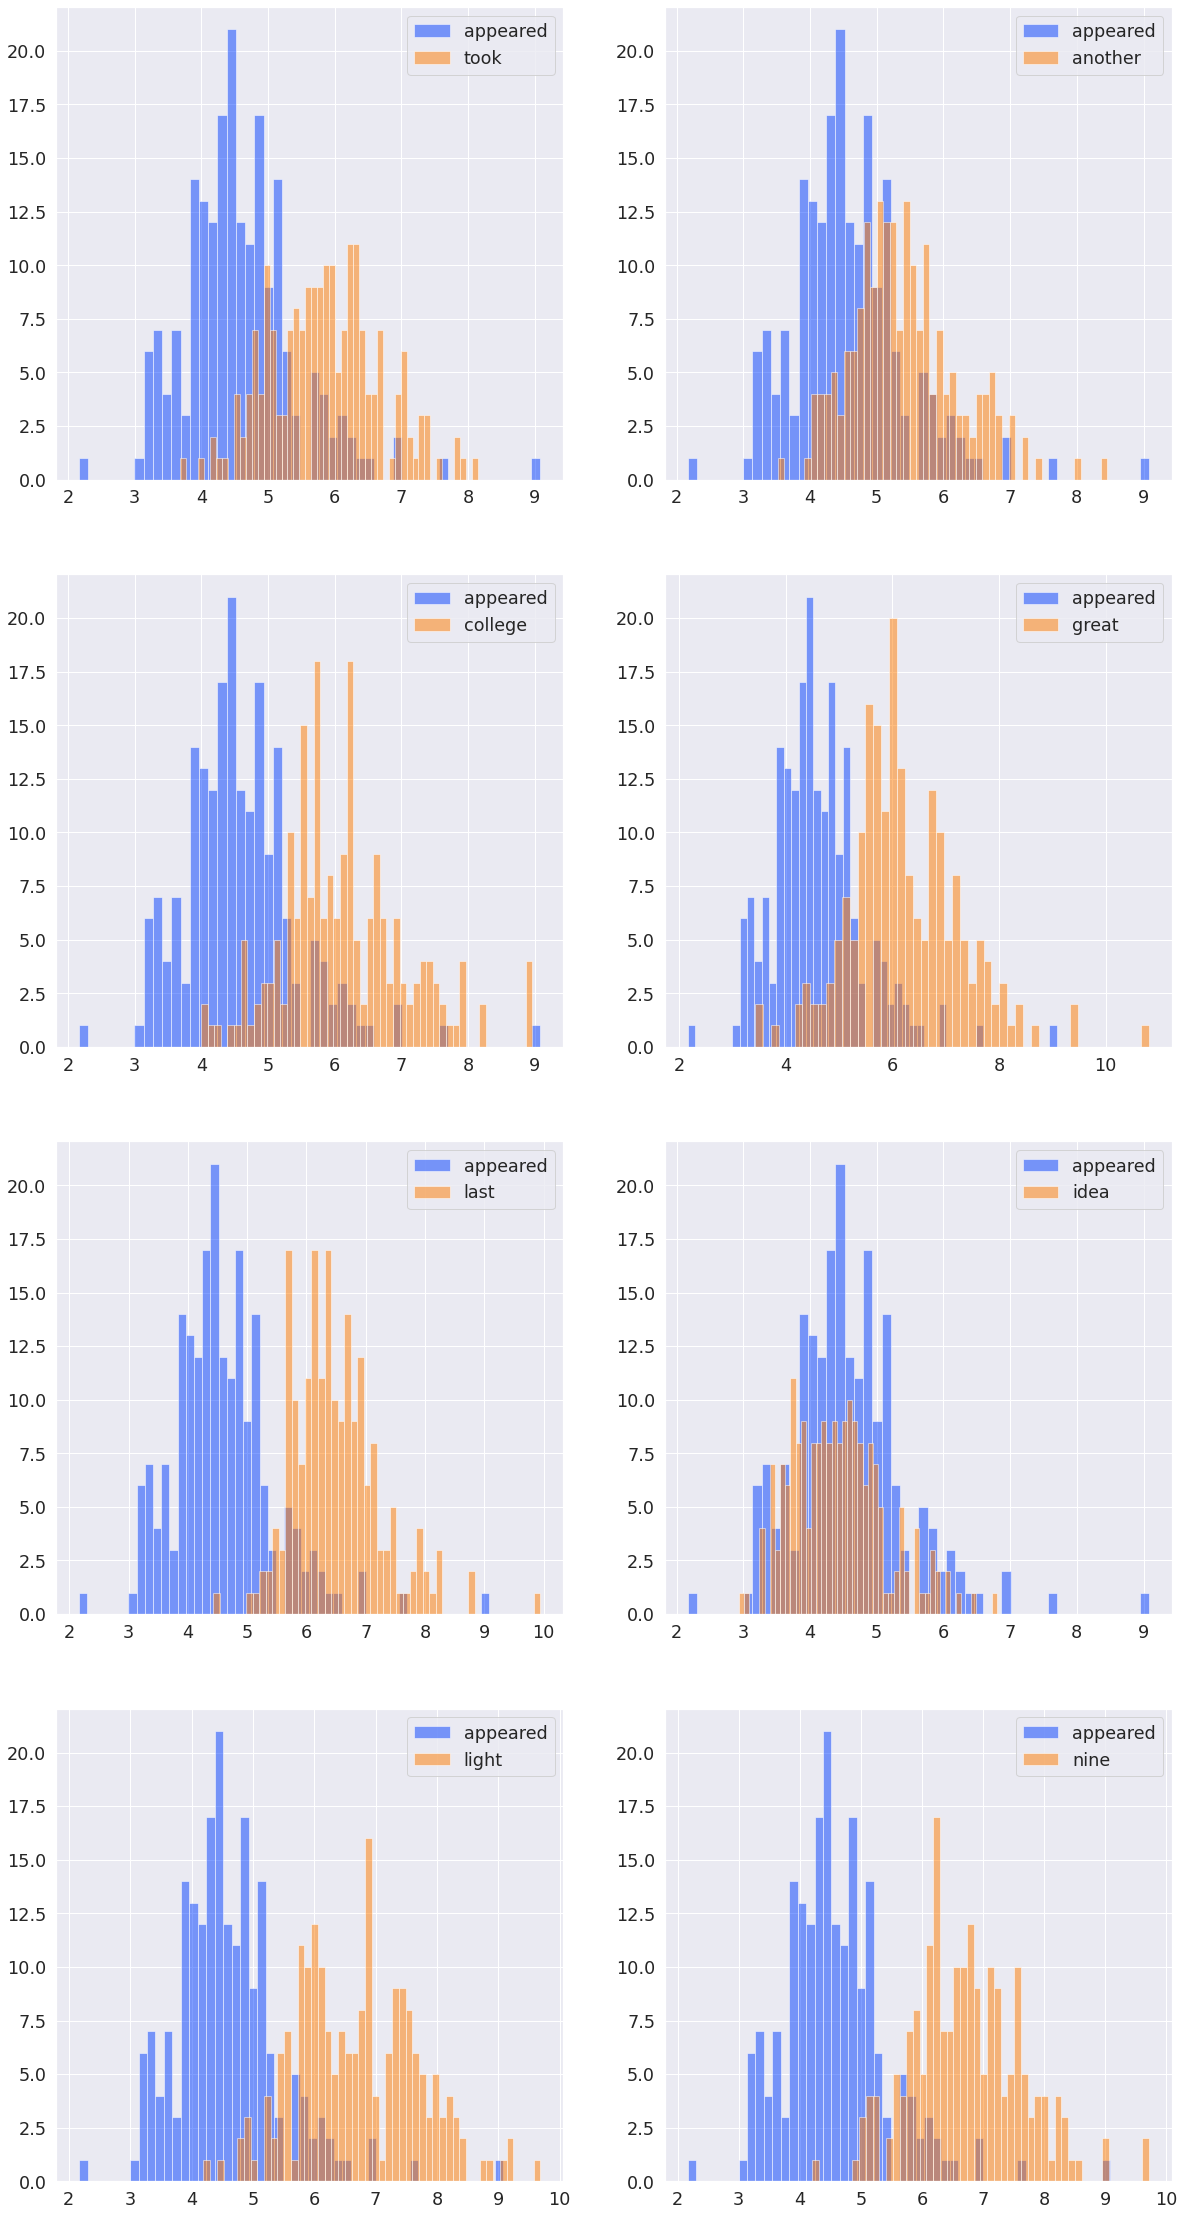

In [134]:
vsrelu = ["took", "another", "college", "great", "last", "idea", "light", "nine",]
fig,axes = plt.subplots(nrows=4,ncols=2)
for ix,another_word in enumerate(vsrelu):
    
    another_wavs = glob.glob(f"{data_dir}{another_word}/*.wav")
    another_samples = np.random.choice(another_wavs, NUM_SAMPLES, replace=False)

    distances_to_another = []
    for w in another_samples:
        d = min_distance_to_pcas(w)
        distances_to_another.append(d)
    
    axc = ix % 2
    axr = ix // 2
    ax = axes[axr][axc]
    ax.hist(distances_to_target,bins=50, alpha=0.5, label=candidate_word, color=sns.color_palette("bright")[0]);    
    ax.hist(distances_to_another,bins=50, alpha=0.5, label=another_word, color=sns.color_palette("bright")[1]);
    ax.legend(loc='upper right');
fig.set_size_inches(20,40);

# augmentation

In [15]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"

a = input_data.AudioDataset(model_settings, commands, bg_datadir, [], unknown_percentage=0)
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_subset = np.random.choice(train_files,8)

In [16]:
train_subset

array(['/home/mark/tinyspeech_harvard/frequent_words/en/clips/college/common_voice_en_20064114__3.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/called/common_voice_en_20238867.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/go/common_voice_en_218594.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/began/common_voice_en_11351887.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/local/common_voice_en_19701866.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/city/common_voice_en_628758__3.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/find/common_voice_en_640479.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/heard/common_voice_en_664485.wav'],
      dtype='<U96')

In [17]:
train_subset_ds = a.init(AUTOTUNE, train_subset, is_training=True)

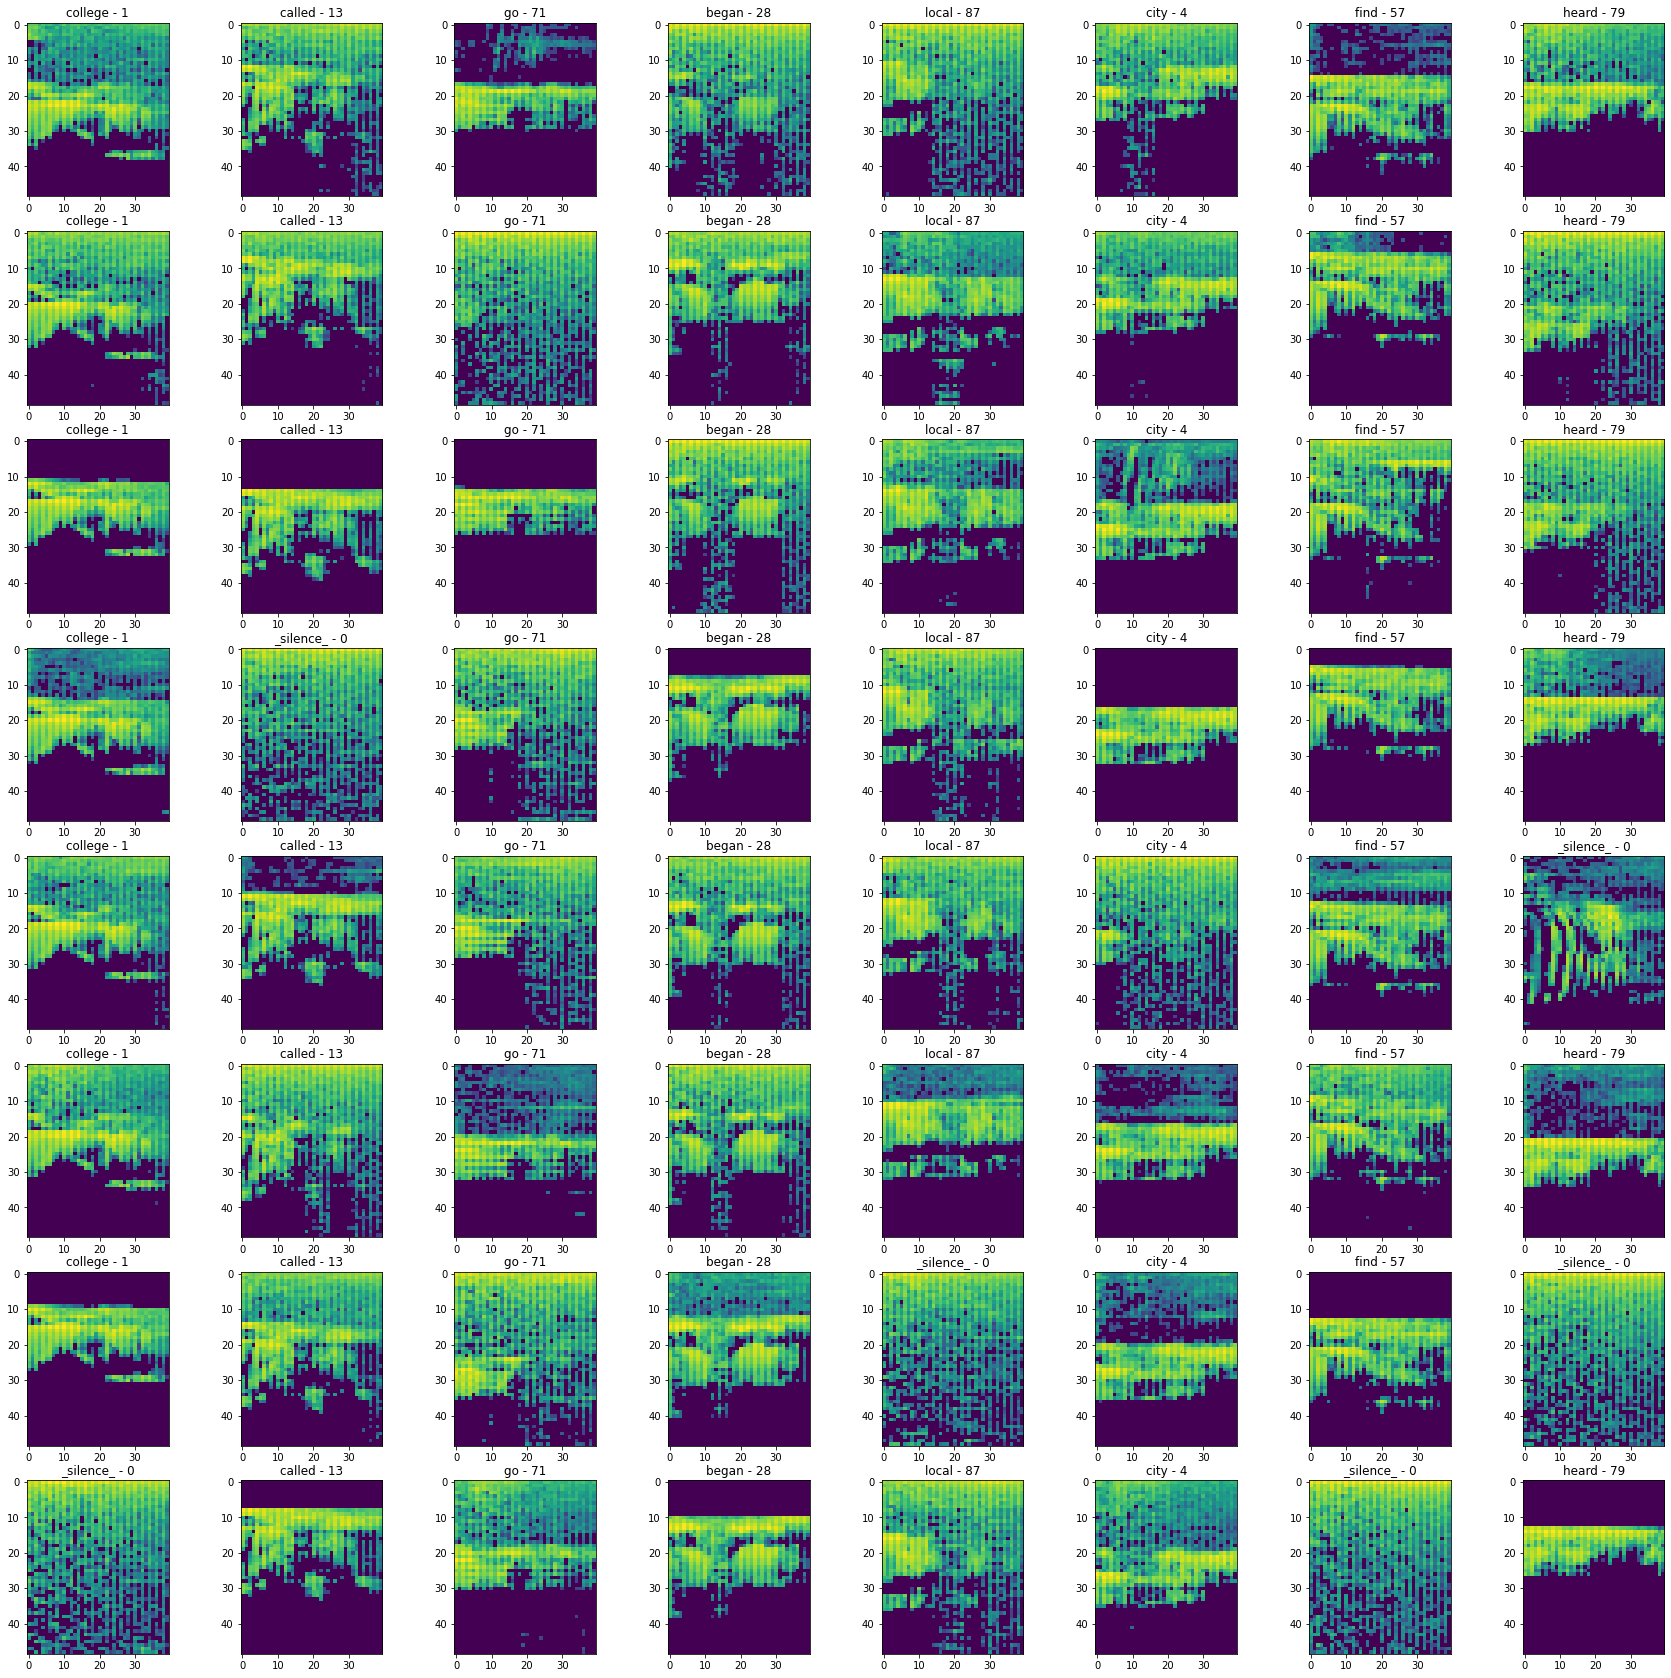

In [25]:
rows = 8
cols = 8
n = rows * cols
#ds = train_subset_ds.shuffle(buffer_size=100).repeat().take(n)
ds = train_subset_ds.repeat().take(n)

specs=[]
fig,axes=plt.subplots(rows, cols)
for ix,d in enumerate(ds):
    
    r = ix // cols
    c = ix % cols
    ax = axes[r][c]
    spec = np.squeeze(d[0])
    ax.imshow(spec)
    #cmd = commands[d[1] - 1] # account for "_silence_"
    cmd = a.commands[d[1]].numpy().decode('utf8') # this is modified to include _silence_ and _unknown_
    ax.set_title(f"{cmd} - {d[1]}") 
    specs.append(spec)
fig.set_size_inches(30,30)

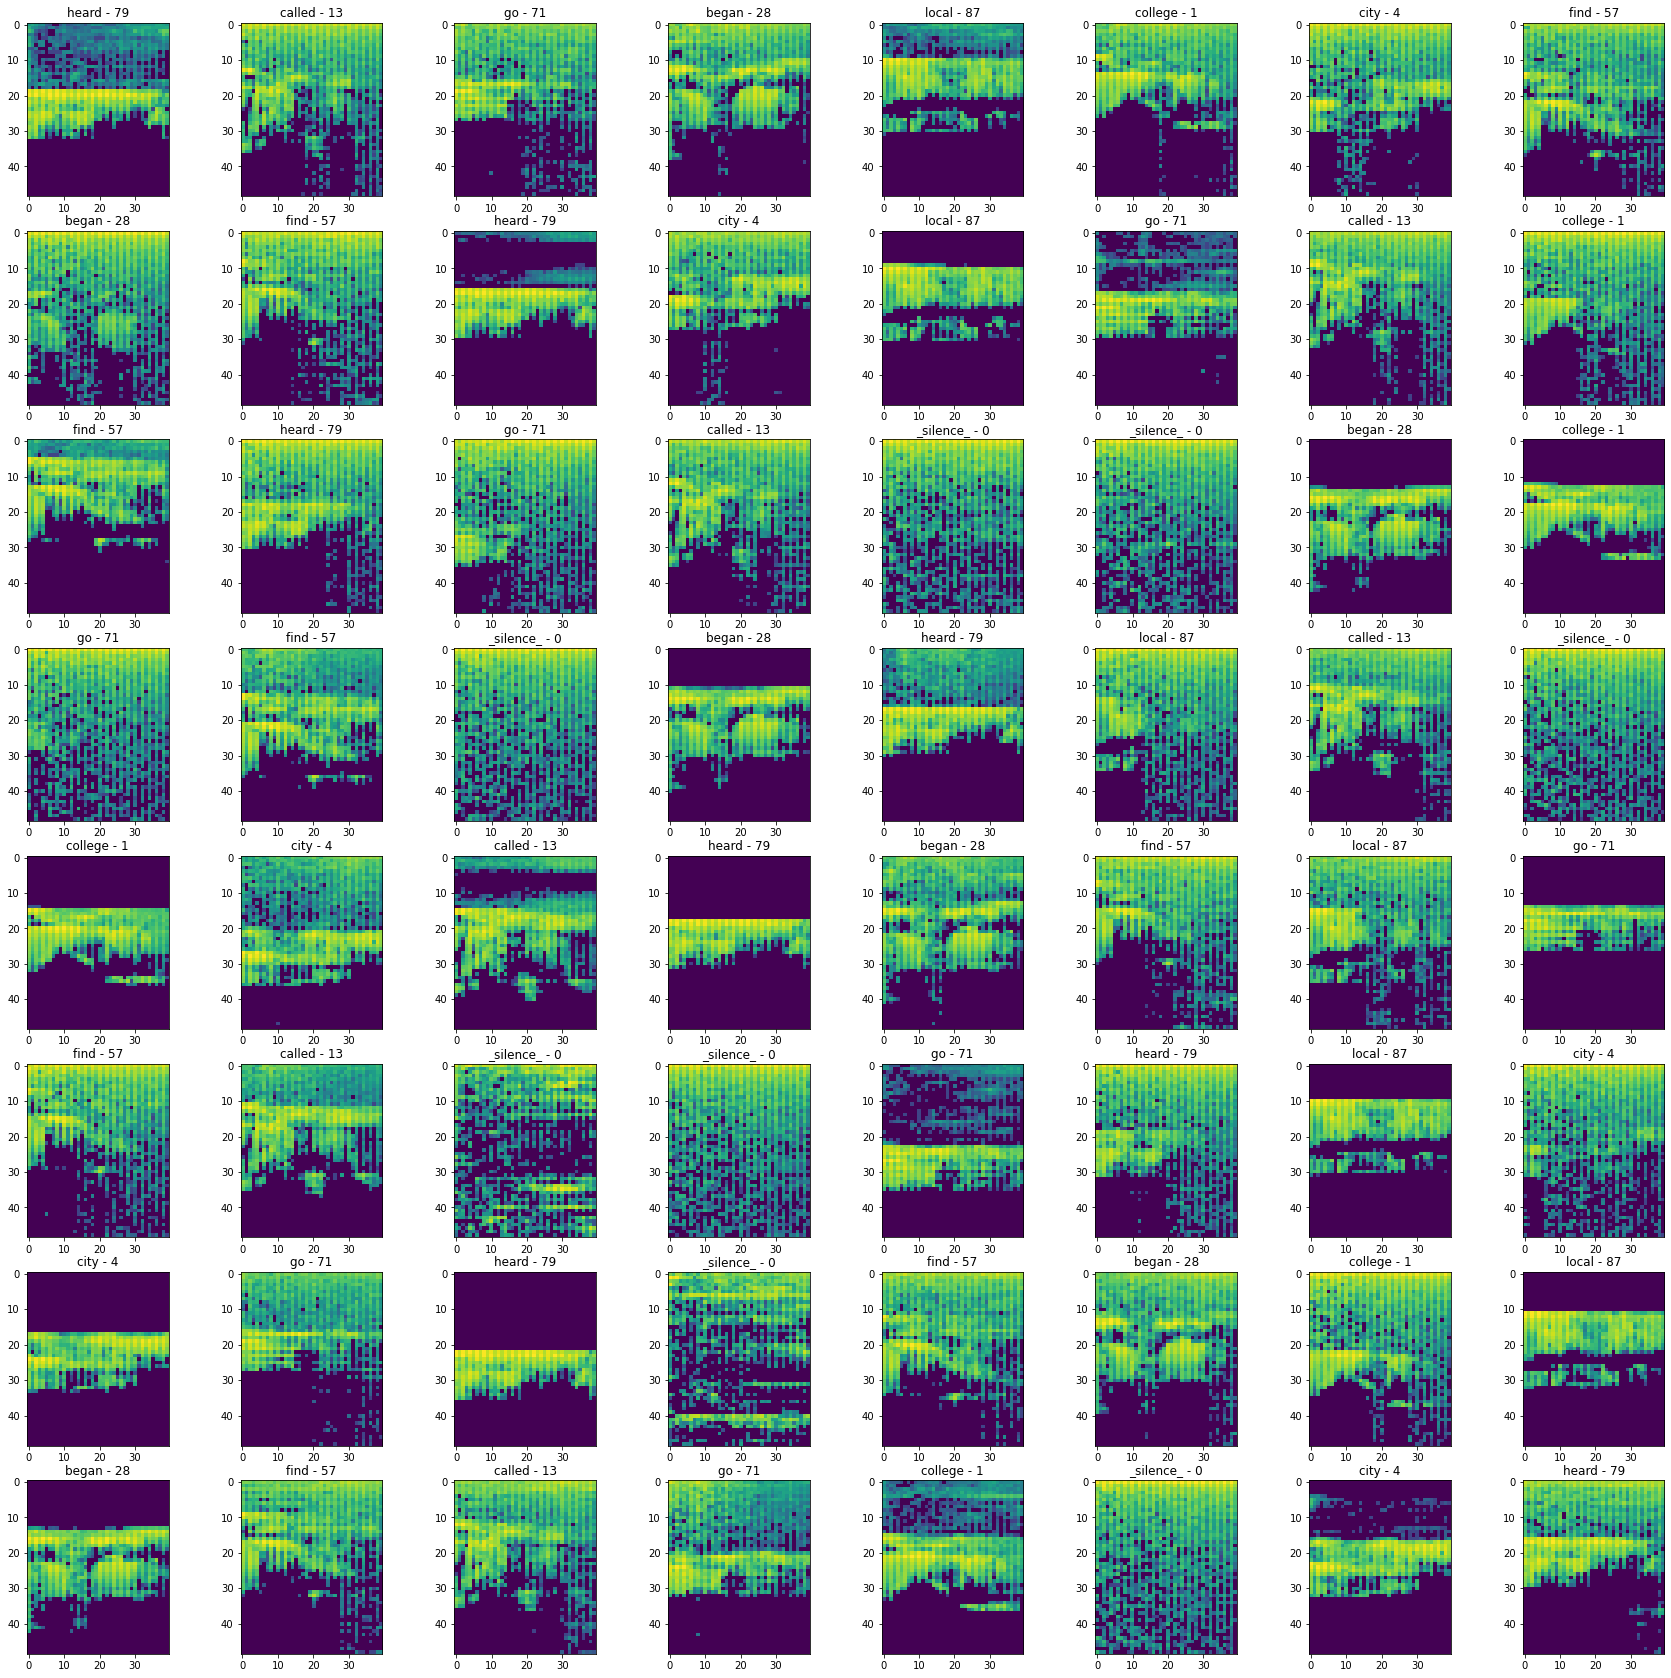

In [26]:
rows = 8
cols = 8
n = rows * cols
ds = train_subset_ds.shuffle(buffer_size=100).repeat().take(n)

specs=[]
fig,axes=plt.subplots(rows, cols)
for ix,d in enumerate(ds):
    
    r = ix // cols
    c = ix % cols
    ax = axes[r][c]
    spec = np.squeeze(d[0])
    ax.imshow(spec)
    #cmd = commands[d[1] - 1] # account for "_silence_"
    cmd = a.commands[d[1]].numpy().decode('utf8') # this is modified to include _silence_ and _unknown_
    ax.set_title(f"{cmd} - {d[1]}") 
    specs.append(spec)
fig.set_size_inches(30,30)

In [8]:
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)
test_ds = a.init(AUTOTUNE, test_files, is_training=False)

In [39]:
input_shape = (49,40,1)
num_labels=len(a.commands) # will include silence/unknown
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    #layers.Dense(1200, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 47, 38, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 45, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 18, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 22, 18, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 25344)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               12976640  
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)              

In [9]:
batch_size = 64
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size)
val_ds = val_ds.batch(batch_size)
#train_ds = train_ds.cache().prefetch(AUTOTUNE)
#val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
EPOCHS = 6
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    # callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
    #            tf.keras.callbacks.LearningRateScheduler(scheduler)],
)

In [42]:
model.save("hundred_word_augmented_6epochs")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: hundred_word_augmented_6epochs/assets


In [10]:
model = tf.keras.models.load_model("hundred_word_augmented_6epochs")

In [13]:
t = test_ds.take(10).batch(1)
for spec,lbl in t:
    #tf.expand_dims(spec, -1)
    p = model.predict(spec)
    print(tf.argmax(np.squeeze(p)))
    print(lbl)
    print("--")

tf.Tensor(17, shape=(), dtype=int64)
tf.Tensor([49], shape=(1,), dtype=int64)
--
tf.Tensor(64, shape=(), dtype=int64)
tf.Tensor([64], shape=(1,), dtype=int64)
--
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor([24], shape=(1,), dtype=int64)
--
tf.Tensor(88, shape=(), dtype=int64)
tf.Tensor([11], shape=(1,), dtype=int64)
--
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor([28], shape=(1,), dtype=int64)
--
tf.Tensor(33, shape=(), dtype=int64)
tf.Tensor([80], shape=(1,), dtype=int64)
--
tf.Tensor(25, shape=(), dtype=int64)
tf.Tensor([46], shape=(1,), dtype=int64)
--
tf.Tensor(75, shape=(), dtype=int64)
tf.Tensor([71], shape=(1,), dtype=int64)
--
tf.Tensor(57, shape=(), dtype=int64)
tf.Tensor([19], shape=(1,), dtype=int64)
--
tf.Tensor(84, shape=(), dtype=int64)
tf.Tensor([2], shape=(1,), dtype=int64)
--


In [23]:
train_audio = []
train_labels = []

for ix,(audio, label) in enumerate(train_ds.unbatch()):
    train_audio.append(audio.numpy())
    train_labels.append(label.numpy())
    if ix % 2000 == 0:
        print(ix)
    if ix > 8000:
        break

train_audio = np.array(test_audio)
train_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(train_audio), axis=1)
y_true = train_labels

train_acc = sum(y_pred == y_true) / len(y_true)
print(f'Train set accuracy: {train_acc:.0%}')

0
2000
4000
6000
8000
Train set accuracy: 11%


In [19]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    if ix % 2000 == 0:
        print(ix)
    if ix > 8000:
        break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

0
2000
4000
6000
8000
Test set accuracy: 32%


In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.gcf().set_size_inches(45,45)

In [16]:
counts = {c:0 for c in commands}
for f in train_files:
    word = f.split(os.path.sep)[-2]
    counts[word] += 1   

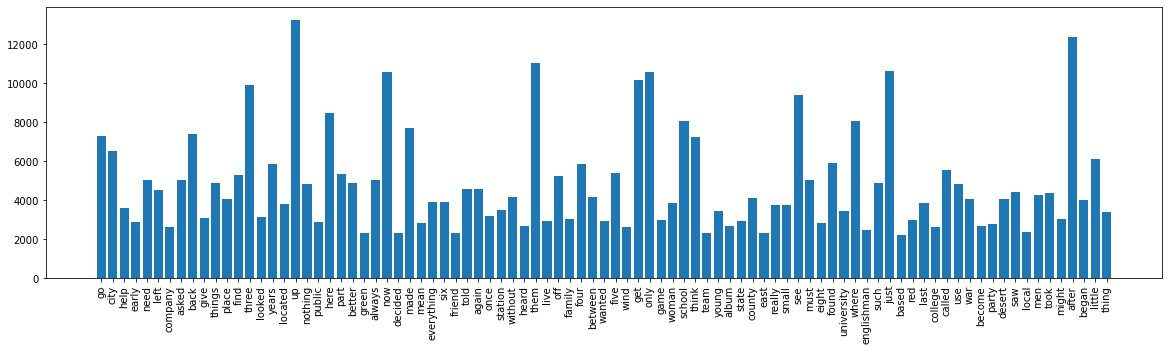

In [21]:
plt.bar(list(counts.keys()), counts.values())
plt.xticks(rotation=90);
plt.gcf().set_size_inches(20,5)

In [22]:
cset = set(commands)
all_words = os.listdir(data_dir)
other_words = []
for w in all_words:
    if w not in cset and w != "_background_noise_":
        other_words.append(w)
print(len(other_words))
",".join(other_words)

176


'went,love,those,every,still,man,house,light,first,group,heart,through,other,used,sheep,looking,good,blue,point,main,both,night,long,father,written,going,under,mind,people,children,during,second,served,would,something,next,put,please,sound,very,continued,river,day,old,set,boy,park,large,son,should,ever,want,away,who,few,also,girl,include,different,around,some,never,named,time,these,read,than,north,gold,then,sun,air,times,answered,everyone,being,became,will,number,hand,today,office,seen,born,before,area,well,anything,known,lot,own,film,building,many,book,earth,west,does,way,show,take,high,morning,look,several,district,even,end,because,one,nine,much,later,could,year,united,more,name,since,street,great,most,days,done,alchemist,life,say,eyes,over,black,road,work,same,know,each,best,how,language,water,music,built,often,system,appeared,about,right,been,money,played,when,knew,make,tell,idea,playing,thought,south,play,down,like,near,fire,however,town,into,matter,king,which,already,seven,anothe

In [24]:
len(model.layers)

8

In [25]:
model.pop()

In [39]:
enroll=[]
for w in other_words:
    wavs = glob.glob(data_dir + w + "/*.wav")
    enroll.extend(np.random.choice(wavs, 20, replace=False).tolist())

In [44]:
offset= 6 * 20
testvecs = enroll[offset:offset+20]
for i in testvecs:
    print(i)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_697738.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_162843.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_16048067.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_217702.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_554185.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_20505674.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_19618031.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_15750274.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_80835.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_118967.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/house/common_voice_en_21860161__4.wav
/home/mark/tinyspeech_harvard/f

In [27]:
candidate = enroll[0]
print(candidate)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/went/common_voice_en_631511.wav


In [28]:
remainder = enroll[1:]

In [36]:
len(remainder)

17599

In [45]:
a = input_data.AudioDataset(model_settings, ["house"], bg_datadir, [], silence_percentage=0, unknown_percentage=0)

In [46]:
ds= a.init(AUTOTUNE, [testvecs[0]], is_training=False)

In [47]:
for d in ds.batch(1).take(1):
    spectrogram = d[0]

In [48]:
candidate_vec = model.predict(spectrogram)

In [49]:
distances = []
for ix,d in enumerate( a.init(AUTOTUNE, testvecs, is_training=False).batch(1)):
    spectrogram = d[0]
    pred = model.predict(spectrogram)
    distances.append(np.linalg.norm(pred - candidate_vec))

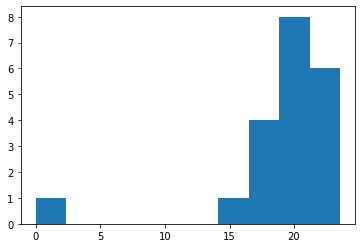

In [51]:
plt.hist(distances);

In [53]:
offset= 9 * 20
differentword = enroll[offset:offset+20]
for i in differentword:
    print(i)

/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_167835.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_197383.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_111789.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_680075.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_22435864.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_217856.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_39028.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_105170.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_670262.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_167186.wav
/home/mark/tinyspeech_harvard/frequent_words/en/clips/group/common_voice_en_19252745.wav
/home/mark/tinyspeech_harvard/frequent_w

In [54]:
distances = []
for ix,d in enumerate( a.init(AUTOTUNE, differentword, is_training=False).batch(1)):
    spectrogram = d[0]
    pred = model.predict(spectrogram)
    distances.append(np.linalg.norm(pred - candidate_vec))

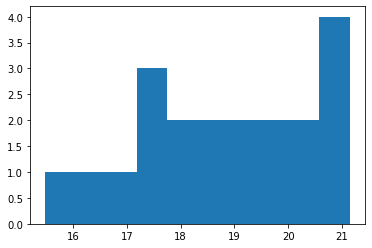

In [55]:
plt.hist(distances);

In [33]:
ds_others = a.init(AUTOTUNE, remainder[100:], is_training=False)

In [34]:
distances = []
for ix,d in enumerate(ds_others.batch(1)):
    if np.random.uniform(0,1) < 0.05:
        if ix % 100 == 0:
            print(ix)
        spectrogram = d[0]
        pred = model.predict(spectrogram)
        distances.append(np.linalg.norm(pred - candidate_vec))

400
500
4800
7800
8800
12300
13500
13600
14100
14200
14800
15000
15600
16500


(array([ 58., 268., 392., 422., 306., 162.,  56.,  27.,   7.,   2.]),
 array([ 9.868032, 12.109407, 14.350782, 16.592157, 18.833532, 21.07491 ,
        23.316284, 25.55766 , 27.799034, 30.04041 , 32.281784],
       dtype=float32),
 <BarContainer object of 10 artists>)

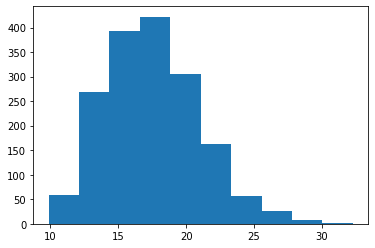

In [35]:
plt.hist(distances)

In [37]:
ds_others = a.init(AUTOTUNE, remainder[:100], is_training=False)
distances = []
for ix,d in enumerate(ds_others.batch(1)):
    spectrogram = d[0]
    pred = model.predict(spectrogram)
    distances.append(np.linalg.norm(pred - candidate_vec))

(array([ 3.,  9., 15., 18., 21., 15., 10.,  6.,  2.,  1.]),
 array([10.6823015, 11.760391 , 12.838481 , 13.916571 , 14.99466  ,
        16.07275  , 17.150839 , 18.22893  , 19.307018 , 20.385109 ,
        21.463198 ], dtype=float32),
 <BarContainer object of 10 artists>)

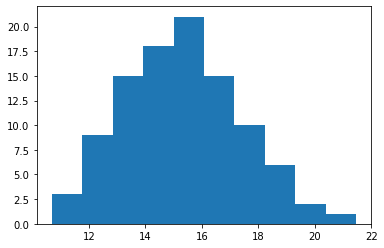

In [38]:
plt.hist(distances)

# rejection sampling

In [4]:
# include silence @ 10 percent
target_dist=[0.1] + [.9/(len(commands)) for c in commands]
print(sum(target_dist))
assert(np.isclose(sum(target_dist), 1.))

1.0000000000000007


In [5]:
def class_id(audio, label):
    return label
resampler = tf.data.experimental.rejection_resample(class_id, target_dist=target_dist)
train_ds = train_ds.apply(resampler)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



# experiments

In [54]:
background_dir="/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"
#background_data = tf.ragged.constant([[]])
#background_data = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
background_data = []
sizes = []
for wav_path in gfile.Glob(os.path.join(background_dir, "*.wav")):
    wav_binary = tf.io.read_file(wav_path)
    audio, _ = tf.audio.decode_wav(wav_binary, desired_channels=1)
    sizes.append(audio.shape[0])
    # TODO(mmaz) this crashes if it is not converted to numpy first
    background_data.append(tf.squeeze(audio, axis=-1))
    #background_data = tf.concat([background_data, [tf.squeeze(audio, axis=-1)]],axis=0)
bgdata = np.zeros((len(sizes), max(sizes)), dtype=np.float32)
for i in range(bgdata.shape[0]):
    wav = background_data[i].numpy()
    length = wav.shape[0]
    bgdata[i,0:length] = wav
sizes = tf.convert_to_tensor(sizes)
bgdata = tf.convert_to_tensor(bgdata)


In [57]:
def map_fn(elem):
    x = tf.random.uniform([], 0,sizes.shape[0],tf.dtypes.int32)
    wav_length = sizes[x]
    wav = bgdata[x,0:wav_length]
    #y = np.random.randint(500,900)
    #y = tf.random.uniform([], 500,1900)
    #print("rand", x)
    #return elem + z
    return wav

ds = tf.data.Dataset.from_tensor_slices([1.,2.])
#ds = ds.map(map_fn).shuffle(5, seed=42, reshuffle_each_iteration=True).batch(5)
ds = ds.map(map_fn)#.repeat(3)

for elem in ds:
  print(elem.numpy())

[-0.05389404 -0.49334717 -0.5333557  ... -0.23934937  0.36676025
 -0.15600586]
[ 0.          0.          0.         ...  0.00289917  0.00338745
 -0.00033569]


In [2]:
# Set seed for experiment reproducibility
#seed = 42
#tf.random.set_seed(seed)
#np.random.seed(seed)


Number of total examples: 178000
Example file tensor: tf.Tensor(b'/home/mark/tinyspeech_harvard/frequent_words/en/clips/better/common_voice_en_16396949.wav', shape=(), dtype=string)


# TFv1 - fix background noise

In [3]:
import sys
sys.path.append("../tensorflow/tensorflow/examples/speech_commands/")
import input_data_fix_bg as input_data
import models as scmodels

In [7]:
import importlib
importlib.reload(input_data_fix_bg)

<module 'input_data' from '/home/mark/tinyspeech_harvard/tinyspeech/input_data.py'>

In [4]:
model_settings = scmodels.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )

In [360]:
data_dir = "/home/mark/tinyspeech_harvard/speech_commands/"

audio_processor = input_data.AudioProcessor(data_dir=data_dir, 
                                            data_url=None,
                                                 silence_percentage=8, unknown_percentage=0, 
                                                 wanted_words=["yes", "no"],
                                                 validation_percentage=10, testing_percentage=10,
                                                 model_settings=model_settings,summaries_dir="./tmp")

In [358]:
time_shift_samples = int((100.0 * 16000) / 1000)

In [ ]:
audio_processor.get_data(1, 0, model_settings, 
                         background_frequency=0.99, 
                         background_volume_range=0.1,  
                         time_shift=time_shift_samples, 
                         mode='training', sess=tf.compat.v1.keras.backend.get_session())

tf.Tensor(0, shape=(), dtype=int32)


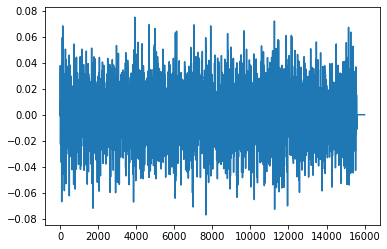

In [24]:
x = a.random_background_sample()
x = a.random_timeshift(x)
x = x.numpy()
plt.plot(np.arange(16000), x)

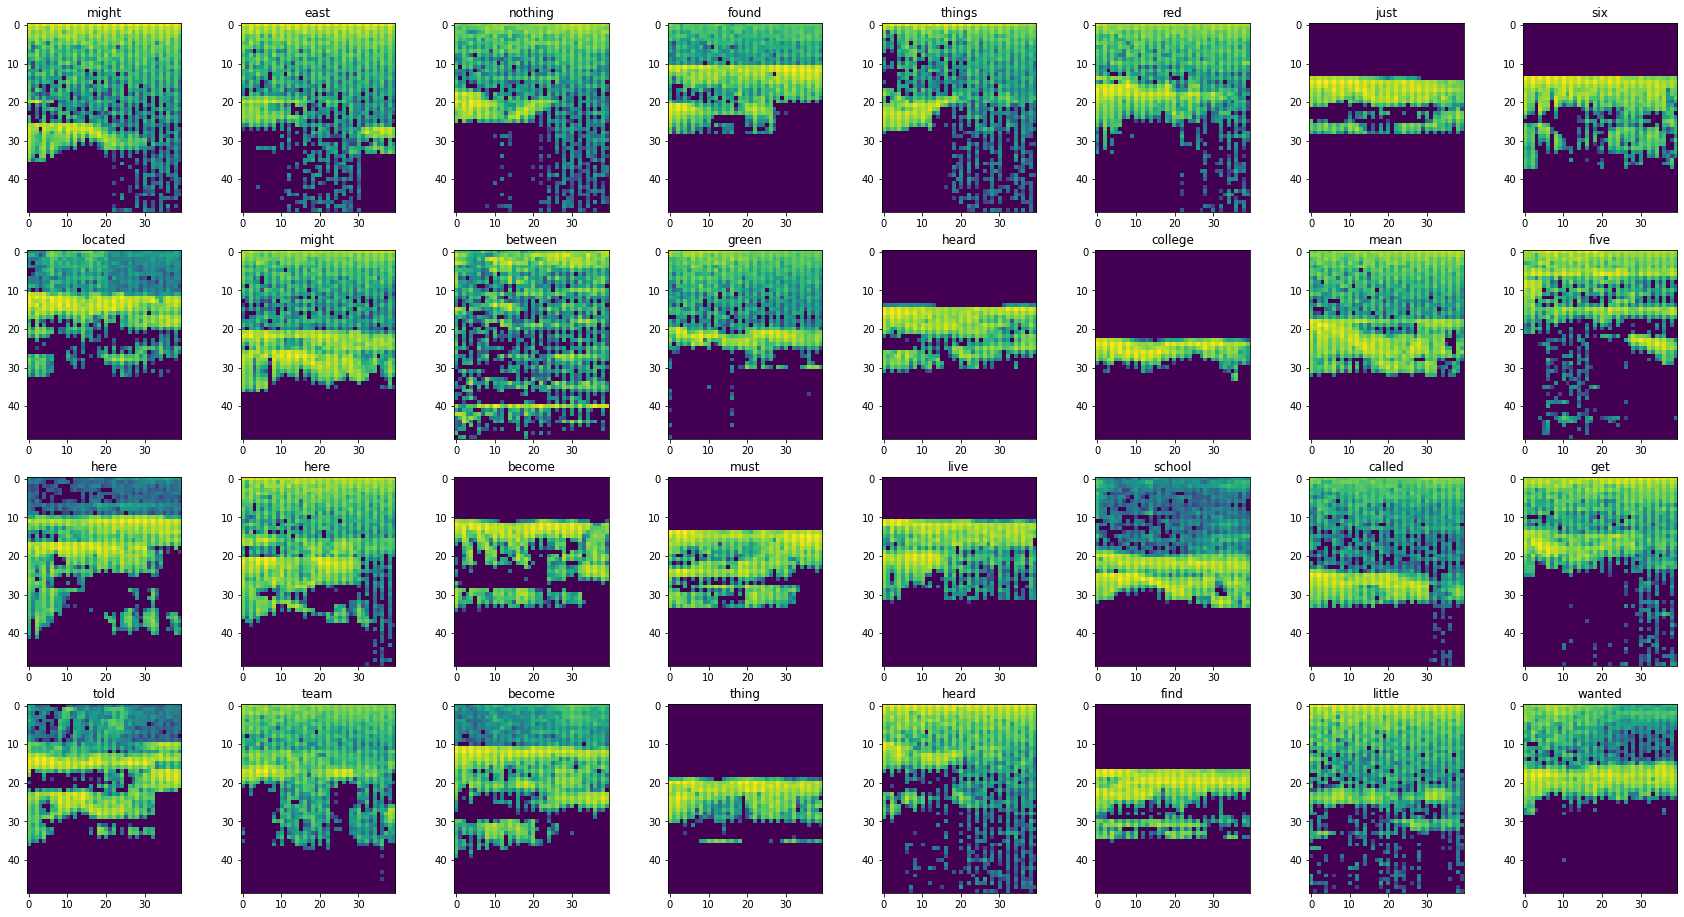

In [21]:
# f_ds = a.init(AUTOTUNE, [f], is_training=True)
# rs = f_ds.batch(1).repeat(5)
rows = 4
cols = 8
n = rows * cols
ds = train_ds.take(n)

specs=[]
fig,axes=plt.subplots(rows, cols)
for ix,d in enumerate(ds):
    
    r = ix // cols
    c = ix % cols
    ax = axes[r][c]
    spec = np.squeeze(d[0])
    ax.imshow(spec)
    ax.set_title(commands[d[1]])
    specs.append(spec)
fig.set_size_inches(30,16)

In [5]:
np.all(specs[0] == specs[1])


True

In [24]:
# https://github.com/tensorflow/tensorflow/issues/35682

def map_fn(elem):
    x = np.random.uniform(0,10)
    print("rand", x)
    return tf.cast(elem, tf.float32) + x

ds = tf.data.Dataset.range(2)
#ds = ds.map(map_fn).shuffle(5, seed=42, reshuffle_each_iteration=True).batch(5)
ds = ds.map(map_fn).batch(2).repeat(3)

for elem in ds:
  print(elem.numpy())
for elem in ds:
  print(elem.numpy())

rand 5.469237641891112
[5.469238 6.469238]
[5.469238 6.469238]
[5.469238 6.469238]
[5.469238 6.469238]
[5.469238 6.469238]
[5.469238 6.469238]


In [30]:
# https://github.com/tensorflow/tensorflow/issues/35682

def map_fn(elem):
    x = tf.random.uniform([], 0,10)
    #y = np.random.randint(500,900)
    y = tf.random.uniform([], 500,1900)
    print("rand", x)
    return elem + x + y

ds = tf.data.Dataset.from_tensor_slices([1.,2.])
#ds = ds.map(map_fn).shuffle(5, seed=42, reshuffle_each_iteration=True).batch(5)
ds = ds.map(map_fn)#.repeat(3)

for elem in ds:
  print(elem.numpy())
for elem in ds:
  print(elem.numpy())

rand Tensor("random_uniform/Mul:0", shape=(), dtype=float32)
613.7305
1671.9319
751.4437
1764.584


In [33]:
# https://www.tensorflow.org/guide/random_numbers
g  = tf.random.Generator.from_non_deterministic_state()
qs = list(map(float,[10,100,1000,1000,20,200,2000,3,30,300,3000]))
def map_fn(elem):
    #x = g.uniform([], 0.,10.)
    #y = g.uniform([], 500,1900, dtype=tf.dtypes.float32)
    #print("rand", x)
    if g.uniform([], 0, 1) > 0.5:
        v = 1000.
    else:
        v = -1000.
    x = g.uniform([], 0, len(qs), dtype=tf.int32)
    #return elem + tf.gather(qs,x)
    #return elem + qs[x]
    return elem + v

ds = tf.data.Dataset.from_tensor_slices([1.,2.])
#ds = ds.map(map_fn).shuffle(5, seed=42, reshuffle_each_iteration=True).batch(5)
ds = ds.map(map_fn)#.repeat(3)

for elem in ds:
  print(elem.numpy())
for elem in ds:
  print(elem.numpy())

-999.0
-998.0
-999.0
-998.0


In [49]:
# https://www.tensorflow.org/guide/random_numbers
g  = tf.random.Generator.from_non_deterministic_state()
qs = [[100,200,300],
      [5,6],
      [10,20,30,40,50,60] ]
qs = tf.ragged.constant(qs)
def map_fn(elem):
    print(qs.shape)
    x = g.uniform([], 0, qs.shape[0], dtype=tf.dtypes.int32)
    y = tf.gather(qs,x)
    #y = qs[x]
    return y[0:2]
    
ds = tf.data.Dataset.from_tensor_slices([1.,2.])
#ds = ds.map(map_fn).shuffle(5, seed=42, reshuffle_each_iteration=True).batch(5)
ds = ds.map(map_fn)#.repeat(3)

for elem in ds:
  print(elem.numpy())
for elem in ds:
  print(elem.numpy())

(3, None)
[5 6]
[100 200]
[100 200]
[5 6]


In [48]:
qs = [[100,200,300],
      [5,6],
      [10,20,30,40,50,60] ]
qs = tf.ragged.constant(qs)
qs.shape

TensorShape([3, None])

In [44]:
tf.constant([100,200,300])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([100, 200, 300], dtype=int32)>

In [55]:
a =tf.constant(1)
b=tf.constant(2)
print(tf.stack([a,b],axis=0))
tf.expand_dims(tf.stack([a,-b],axis=0),axis=0)

tf.Tensor([1 2], shape=(2,), dtype=int32)


<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[ 1, -2]], dtype=int32)>

In [11]:
#https://keras.io/api/callbacks/learning_rate_scheduler/
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        #return lr * tf.math.exp(-0.1)
        return lr * tf.math.exp(-0.075)

In [ ]:
xs = np.arange(0, 300, 10)
lrs = []
#lr = 0.001
lr = 0.0008
for x in xs:
    lr = scheduler(epoch=x, lr=lr)
    lrs.append(lr)
plt.plot(xs, lrs);

In [13]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
# data_dir = pathlib.Path('data/mini_speech_commands')
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [4]:
data_dir = "/home/mark/tinyspeech_harvard/frequent_words/en/clips/"

In [11]:
#commands = np.array(tf.io.gfile.listdir(str(data_dir)))
#commands = commands[commands != 'README.md']
print('Commands:', commands)

NameError: name 'commands' is not defined

In [9]:
cs = np.random.choice(commands, 100)
print(cs)

['between' 'began' 'eight' 'thing' 'university' 'made' 'need' 'always'
 'public' 'small' 'decided' 'told' 'now' 'based' 'again' 'six' 'team'
 'back' 'album' 'see' 'found' 'live' 'without' 'family' 'here' 'nothing'
 'heard' 'wanted' 'mean' 'called' 'things' 'made' 'saw' 'local' 'just'
 'green' 'after' 'little' 'state' 'go' 'give' 'get' 'green' 'up' 'county'
 'after' 'state' 'friend' 'looked' 'college' 'use' 'school' 'only' 'them'
 'four' 'help' 'took' 'war' 'city' 'must' 'east' 'desert' 'decided' 'last'
 'party' 'early' 'red' 'called' 'once' 'think' 'without' 'company' 'find'
 'might' 'better' 'nothing' 'part' 'place' 'school' 'three' 'things'
 'where' 'wind' 'men' 'such' 'them' 'woman' 'game' 'asked' 'off' 'years'
 'five' 'everything' 'located' 'really' 'englishman' 'become' 'left'
 'station' 'young']


In [6]:
os.chdir("/home/mark/tinyspeech_harvard/train_100_moreepochs/")

In [5]:
raise ValueError("caution: overwrites current training list")
with open("wordlist.txt", 'w') as fh:
    for c in cs:
        fh.write(f"{c}\n")

ValueError: caution: overwrites current training list

In [7]:
with open("wordlist.txt", "r") as fh:
    wordlist = fh.read().splitlines()

In [8]:
len(wordlist)

100

In [18]:
" ".join(wordlist)

'between began eight thing university made need always public small decided told now based again six team back album see found live without family here nothing heard wanted mean called things made saw local just green after little state go give get green up county after state friend looked college use school only them four help took war city must east desert decided last party early red called once think without company find might better nothing part place school three things where wind men such them woman game asked off years five everything located really englishman become left station young'

In [9]:
commands = np.array(wordlist)

In [102]:
np.argmax("young" == commands)

99

In [10]:
data_dir="/home/mark/tinyspeech_harvard/frequent_words/en/clips/"

In [ ]:
raise ValueError("caution: overwrites current training list")
dataset = {}
for c in cs:
    wavs = glob.glob(data_dir + c + "/*.wav")
    dataset[c] = np.random.choice(wavs, 2000, replace=False)
with open('dataset.pkl', 'wb') as fh:
    pickle.dump(dataset, fh, pickle.HIGHEST_PROTOCOL)

In [11]:
with open('dataset.pkl', 'rb') as fh:
    dataset = pickle.load(fh)

In [23]:
dataset['party'][:10]

array(['/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_20791358.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_686391.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_17885108.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_20827593.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_17883618.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_19093350.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_21380127.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_20725173__2.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_18944402.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/party/common_voice_en_21622544.wav'],
      dt

In [14]:
for k, vs in dataset.items():
    if len(vs) != 2000:
        raise ValueError("ruh roh")

In [13]:
filenames = []
for _, vs in dataset.items():
    #filenames.extend(vs)
    filenames.extend(map(str,vs))
    #filenames.extend(list(map(tf.io.gfile.GFile,vs)))

Extract the audio files into a list and shuffle the list.

In [14]:
#filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = filenames.shape[0]
print('Number of total examples:', num_samples)
#print('Number of examples per label:',
#      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 178000
Example file tensor: Tensor("strided_slice:0", shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio respectively.

In [41]:
178000*.8

142400.0

In [59]:
142400 + 17800 + 17800

178000

In [3]:
train_files = filenames[:142400]
val_files = filenames[142400: 142400 + 17800]
test_files = filenames[-17800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 142400
Validation set size 17800
Test set size 17800


In [18]:
vfs = set([v.numpy() for v in val_files])
zfs = set([v.numpy() for v in test_files])
tfs = set([v.numpy() for v in train_files])

In [76]:
izn = tfs.intersection(vfs)
len(izn)
#print(list(izn)[0])

0

## Reading audio files and their labels

In [28]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for the wav file is its parent directory.

In [29]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the wav file and output an audio, label tuple for supervised training.

In [30]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build our training set to extract audio, label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(90, shape=(), dtype=int64)
tf.Tensor(94, shape=(), dtype=int64)
tf.Tensor(91, shape=(), dtype=int64)
tf.Tensor(25, shape=(), dtype=int64)
tf.Tensor(73, shape=(), dtype=int64)
tf.Tensor(35, shape=(), dtype=int64)
tf.Tensor(28, shape=(), dtype=int64)
tf.Tensor(22, shape=(), dtype=int64)


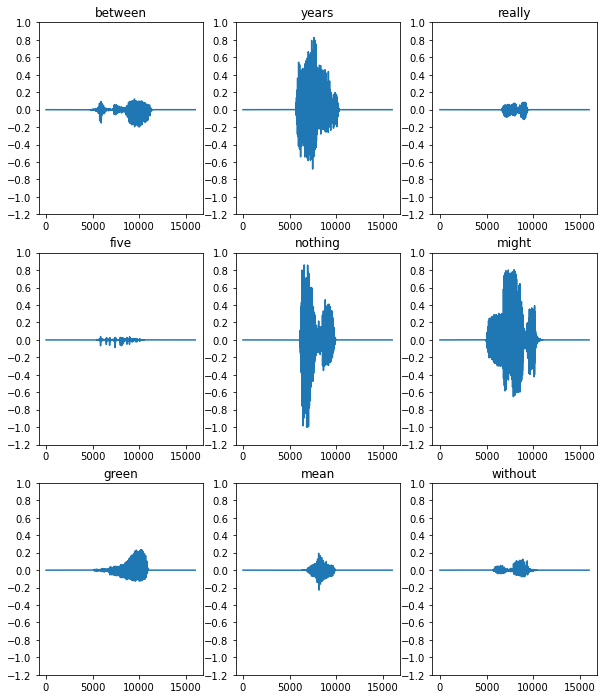

In [32]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  lc = label == commands
  print(tf.argmax(tf.dtypes.cast(lc, tf.int32)))
  label = label.numpy().decode('utf-8')
  
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying short time fourier transform (STFT) to convert the audio into the time-frequency domain.

A fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but looses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more info on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe). 

You also want to waveforms to have the same length so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.



In [33]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [34]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: between
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


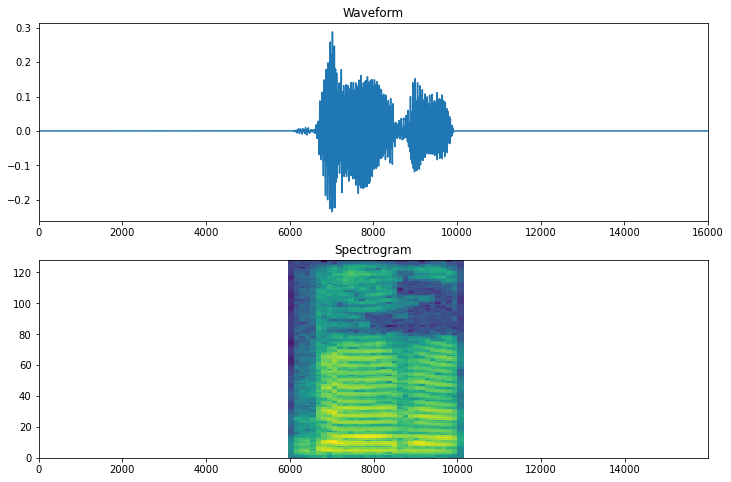

In [46]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [35]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  lc = label == commands
  lc = tf.dtypes.cast(lc, tf.int32) #https://github.com/tensorflow/tensorflow/issues/33685
  label_id = tf.argmax(lc)
  return spectrogram, label_id

In [36]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

In [4]:
import input


In [13]:
import importlib
importlib.reload(input)

<module 'input' from '/home/mark/tinyspeech_harvard/tinyspeech/input.py'>

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [17]:
train_ds = input.to_dataset(model_settings, commands, AUTOTUNE, train_files)
val_ds = input.to_dataset(model_settings, commands, AUTOTUNE, val_files)
test_ds = input.to_dataset(model_settings, commands, AUTOTUNE, test_files)

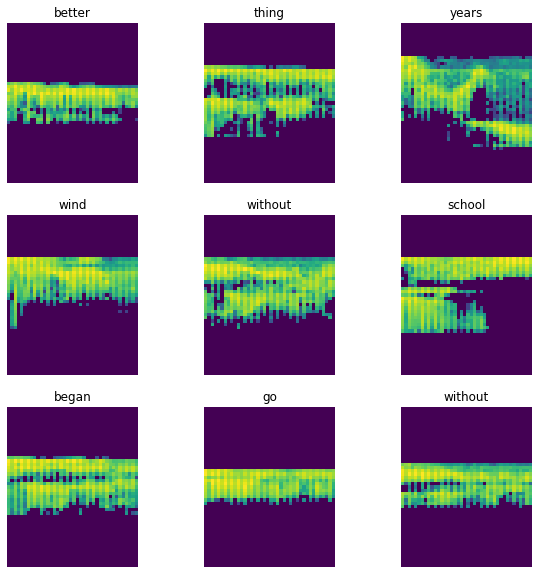

In [15]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.imshow(np.squeeze(spectrogram.numpy()))
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
#plt.show()

/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mark/miniconda3/envs/tinyspeech/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


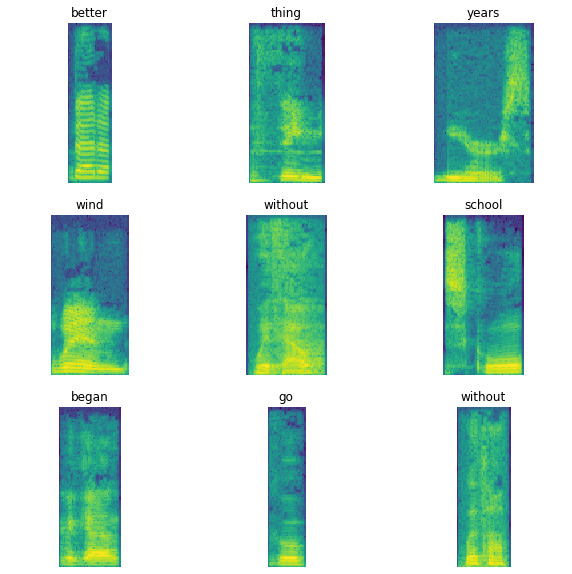

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Before you build and train our model, you would need apply the same data processing done on the training set with the validation and test sets.

In [37]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [16]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

NameError: name 'preprocess_dataset' is not defined

Batch the training and validation sets for model training.

In [39]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [40]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [41]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


In [42]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    #preprocessing.Resizing(32, 32), 
    preprocessing.Resizing(64,64), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    layers.Dense(512, activation='relu'),
    #layers.Dense(1200, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [34]:
# for spectrogram, _ in spectrogram_ds.take(1):
#     input_shape = spectrogram.shape
# print('Input shape:', input_shape)
# num_labels = len(commands)

# norm_layer = preprocessing.Normalization()
# norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

In [50]:
# # https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     preprocessing.Resizing(32, 32), 
#     #preprocessing.Resizing(64,64),
#     #preprocessing.Resizing(96,96),
#     norm_layer,
# ])
# # https://keras.io/api/applications/resnet/#resnet50v2-function
# # https://github.com/keras-team/keras-applications/issues/50 without pooling this will output the tensor block
# model.add(tf.keras.applications.ResNet50V2(include_top=False, weights=None, input_shape=(64, 64, 1), pooling='avg'))
# model.add(layers.Dense(num_labels))

# model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_9 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization multiple                  3         
_________________________________________________________________
resnet50v2 (Model)           (None, 2048)              23558528  
_________________________________________________________________
dense_6 (Dense)              (None, 100)               204900    
Total params: 23,763,431
Trainable params: 23,717,988
Non-trainable params: 45,443
_________________________________________________________________


In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# tfv1

In [7]:
time_shift_samples = int((100.0 * 16000) / 1000)
def batch_generator(audio_processor, dataset_name, batch_size, model_settings, background_frequency, background_volume_range, time_shift_samples, is_training):
    if not is_training:
        assert(dataset_name == "validation" or dataset_name == "testing")
        set_size = audio_processor.set_size(dataset_name)
        for i in range(0, set_size, batch_size):
            sess = tf.compat.v1.keras.backend.get_session()
            validation_fingerprints, validation_ground_truth = (
                        audio_processor.get_data(how_many=batch_size, offset=i, model_settings=model_settings, background_frequency=0.0,
                                     background_volume_range=0.0, time_shift=0, mode='validation', sess=sess))
            yield validation_fingerprints, validation_ground_truth
    else:
        sess = tf.compat.v1.keras.backend.get_session()
        while True:
            (train_fingerprints, train_ground_truth) = audio_processor.get_data(
                how_many=batch_size, offset=0, model_settings=model_settings, background_frequency=background_frequency,
                background_volume_range=background_volume_range, time_shift=time_shift_samples, mode='training', sess=sess)
            yield train_fingerprints, train_ground_truth
            
def get_steps_per_epoch(batch_size):
    # approximately how many samples do you need to cover the training set size
    set_size = audio_processor.set_size('training')
    return int(np.ceil(set_size / batch_size))


model_settings = tfscm.prepare_model_settings(label_count=len(commands), 
                                        sample_rate=16000, clip_duration_ms=1000, window_size_ms=30, window_stride_ms=20, feature_bin_count=40, preprocess='micro')

In [8]:
audio_processor = mmaz_input_data.AudioProcessor(data_dir=data_dir, 
                                                 silence_percentage=8, unknown_percentage=0, 
                                                 wanted_words=commands.tolist(), # from numpy
                                                 unknown_words=[], 
                                                 validation_percentage=10, testing_percentage=10,model_settings=model_settings,summaries_dir=None)

In [7]:
model_settings['fingerprint_size']

1960

In [8]:
model_settings

{'desired_samples': 16000,
 'window_size_samples': 480,
 'window_stride_samples': 320,
 'spectrogram_length': 49,
 'fingerprint_width': 40,
 'fingerprint_size': 1960,
 'label_count': 100,
 'sample_rate': 16000,
 'preprocess': 'micro',
 'average_window_width': -1}

In [9]:
steps_per_epoch = get_steps_per_epoch(100)

In [11]:
res = batch_generator(audio_processor, 
                           'training', 
                           batch_size=100, model_settings=model_settings, 
                           background_frequency=0.8, background_volume_range=0.1, 
                           time_shift_samples=time_shift_samples, is_training='True')
for tfp,tgt in res:
    print(tfp.shape)
    print(tfp.dtype)
    print(np.reshape(tfp, (-1, 49, 40, 1)).shape)
    print(tgt.shape)
    break

(100, 1960)
float64
(100, 49, 40, 1)
(100,)


Going from 100x1960 to spectrograms:
    
`tensorflow/tensorflow/examples/speech_commands/models.py`    
    
```python
    input_frequency_size = model_settings['fingerprint_width']
    # == 40 
    input_time_size = model_settings['spectrogram_length']
    # == 49
    fingerprint_4d = tf.reshape(fingerprint_input,
                              [-1, input_time_size, input_frequency_size, 1])
    # [-1, input_time_size, input_frequency_size, 1]
    #              49               40            1ch
```    

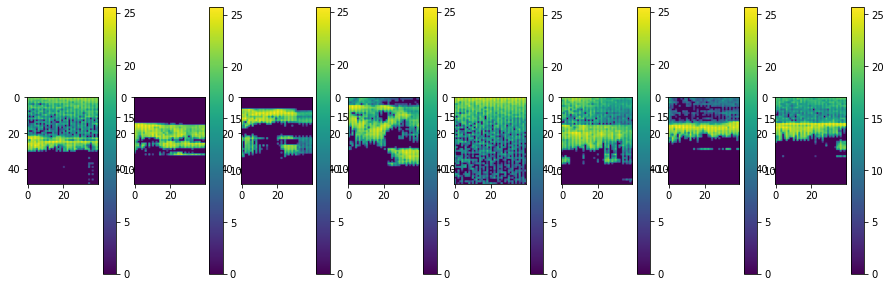

In [31]:
# https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot
# https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
#https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
n_img = 8
fig,ax=plt.subplots(ncols=n_img)
for i in range(n_img):
    im = tfp[i].reshape(49,40)
    im=ax[i].imshow(im)
#     ax[i].colorbar()
    fig.colorbar(im, ax=ax[i])
fig.set_size_inches(15,10)


In [47]:
r = np.random.rand(10,25)
print(r.shape)
r = r.reshape(10,5,5,1)
print(r.shape)
s = np.random.rand(10,25).reshape(-1,5,5,1)
print(s.shape)
print(np.concatenate([r,s]).shape)

(10, 25)
(10, 5, 5, 1)
(10, 5, 5, 1)
(20, 5, 5, 1)


In [55]:
norm_steps = 200 # * batch size
examples = []
res = batch_generator(audio_processor, 
                           'training', 
                           batch_size=100, model_settings=model_settings, 
                           background_frequency=0.8, background_volume_range=0.1, 
                           time_shift_samples=time_shift_samples, is_training='True')
for ix, (fingerprints,groundtruths) in enumerate(res):
    if ix % 20 == 0:
        print(ix)
    examples.append(fingerprints.reshape(100, 49,40,1))
    if ix > norm_steps:
        break
examples = np.concatenate(examples)
print(examples.shape)

0
20
40
60
80
100
120
140
160
180
200
(20200, 49, 40, 1)


In [31]:
model_settings = input_data.prepare_model_settings(
        label_count=100,
        sample_rate=16000,
        clip_duration_ms=1000,
        window_size_ms=30,
        window_stride_ms=20,
        feature_bin_count=40,
        preprocess="micro",
    )
bg_datadir = (
        "/home/mark/tinyspeech_harvard/frequent_words/en/clips/_background_noise_/"
)

a = input_data.AudioDataset(model_settings, commands, bg_datadir)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [30]:
train_files[23]

<tf.Tensor: shape=(), dtype=string, numpy=b'/home/mark/tinyspeech_harvard/frequent_words/en/clips/college/common_voice_en_21500464.wav'>

In [32]:
train_ds = a.init(AUTOTUNE, train_files, is_training=True)
val_ds = a.init(AUTOTUNE, val_files, is_training=False)

In [33]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [34]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

In [35]:
input_shape = (49,40,1)
num_labels=len(commands) + 1 #silence
model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    layers.Dense(512, activation='relu'),
    #layers.Dense(1200, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 49, 40, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 38, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 36, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25344)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    # callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
    #            tf.keras.callbacks.LearningRateScheduler(scheduler)],
)

Epoch 1/10
2225/2225 [==============================] - 24s 11ms/step - loss: 2.4648 - accuracy: 0.3792 - val_loss: 1.2600 - val_accuracy: 0.6551
Epoch 2/10
2225/2225 [==============================] - 23s 10ms/step - loss: 1.5919 - accuracy: 0.5648 - val_loss: 0.9989 - val_accuracy: 0.7242
Epoch 3/10
2225/2225 [==============================] - 23s 10ms/step - loss: 1.3514 - accuracy: 0.6248 - val_loss: 0.8934 - val_accuracy: 0.7498
Epoch 4/10
2225/2225 [==============================] - 23s 10ms/step - loss: 1.2090 - accuracy: 0.6607 - val_loss: 0.8348 - val_accuracy: 0.7635
Epoch 5/10
2225/2225 [==============================] - 23s 10ms/step - loss: 1.0979 - accuracy: 0.6880 - val_loss: 0.8038 - val_accuracy: 0.7715
Epoch 6/10
2225/2225 [==============================] - 23s 10ms/step - loss: 1.0127 - accuracy: 0.7076 - val_loss: 0.7610 - val_accuracy: 0.7862
Epoch 7/10
2225/2225 [==============================] - 23s 10ms/step - loss: 0.9407 - accuracy: 0.7282 - val_loss: 0.7412 -

In [65]:
EPOCHS = 10
history = model.fit(
    x=batch_generator(audio_processor, 
                           'training', 
                           batch_size=100, model_settings=model_settings, 
                           background_frequency=0.8, background_volume_range=0.1, 
                           time_shift_samples=time_shift_samples, is_training='True'), 
    steps_per_epoch=steps_per_epoch,
    validation_data=batch_generator(audio_processor, 
                           'validation', 
                           batch_size=100, model_settings=model_settings, 
                           background_frequency=0.0, background_volume_range=0.0, 
                           time_shift_samples=0, is_training='False'),  
    validation_steps=audio_processor.set_size('validation'),
    epochs=EPOCHS,
)

Epoch 1/10


RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [ ]:
x = audio_processor.get_data(
                how_many=batch_size, offset=0, model_settings=model_settings, background_frequency=background_frequency,
                background_volume_range=background_volume_range, time_shift=time_shift_samples, mode='training', sess=sess)

```python
time_shift_samples = int((FLAGS.time_shift_ms * FLAGS.sample_rate) / 1000)
    100.0ms
```

In [15]:
time_shift_samples = int((100.0 * 16000) / 1000)
time_shift_samples

1600

In [17]:
def get_steps_per_epoch(batch_size):
    # approximately how many samples do you need to cover the training set size
    set_size = audio_processor.set_size('training')
    return int(np.ceil(set_size / batch_size))

```python
  audio_processor = input_data.AudioProcessor(
      FLAGS.data_url, FLAGS.data_dir,
      FLAGS.silence_percentage, FLAGS.unknown_percentage,
      FLAGS.wanted_words.split(','), FLAGS.validation_percentage,
      FLAGS.testing_percentage, model_settings, FLAGS.summaries_dir)

   model_settings = models.prepare_model_settings(
      len(input_data.prepare_words_list(FLAGS.wanted_words.split(','))),
      FLAGS.sample_rate, FLAGS.clip_duration_ms, FLAGS.window_size_ms,
      FLAGS.window_stride_ms, FLAGS.feature_bin_count, FLAGS.preprocess)   
    
 ```
 
 
```
python tensorflow/tensorflow/examples/speech_commands/train.py --data_dir=./alignment_processing/de_extractions/ --wanted_words=auf,halt,ja,nein,richtig --silence_percentage=8 --unknown_percentage=8 --preprocess=micro --window_stride=20 --model_architecture=tiny_conv --how_many_training_steps=12000,3000 --learning_rate=0.001,0.0001 --train_dir=train/ --summaries_dir=logs/ --verbosity=DEBUG --eval_step_interval=1000 --save_step_interval=1000

```


```python
    train_fingerprints, train_ground_truth = audio_processor.get_data(
        FLAGS.batch_size, 0, model_settings, FLAGS.background_frequency,
        FLAGS.background_volume, time_shift_samples, 'training', sess)
```

https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/backend/get_session

In [18]:
len(commands)

100

In [19]:
model_settings = prepare_model_settings(label_count=len(commands), 
                                        sample_rate=16000, clip_duration_ms=1000, window_size_ms=30, window_stride_ms=20, feature_bin_count=40, preprocess='micro')

In [21]:
steps_per_epoch = get_steps_per_epoch(100)
print(steps_per_epoch)

4673


In [24]:
# import importlib
# importlib.reload(mmaz_input_data)

<module 'mmaz_input_data' from '../tensorflow/tensorflow/examples/speech_commands/mmaz_input_data.py'>

In [48]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
               tf.keras.callbacks.LearningRateScheduler(scheduler)],
)

Epoch 1/10
2225/2225 [==============================] - 59s 27ms/step - loss: 1.4821 - accuracy: 0.6123 - val_loss: 0.7363 - val_accuracy: 0.8032
Epoch 2/10
2225/2225 [==============================] - 49s 22ms/step - loss: 0.8361 - accuracy: 0.7642 - val_loss: 0.6022 - val_accuracy: 0.8361
Epoch 3/10
2225/2225 [==============================] - 49s 22ms/step - loss: 0.6664 - accuracy: 0.8070 - val_loss: 0.5633 - val_accuracy: 0.8475
Epoch 4/10
2225/2225 [==============================] - 50s 22ms/step - loss: 0.5716 - accuracy: 0.8311 - val_loss: 0.5414 - val_accuracy: 0.8554
Epoch 5/10
2225/2225 [==============================] - 50s 23ms/step - loss: 0.4998 - accuracy: 0.8512 - val_loss: 0.5427 - val_accuracy: 0.8588
Epoch 6/10
2225/2225 [==============================] - 50s 22ms/step - loss: 0.4459 - accuracy: 0.8648 - val_loss: 0.5285 - val_accuracy: 0.8612
Epoch 7/10
2225/2225 [==============================] - 50s 23ms/step - loss: 0.4074 - accuracy: 0.8759 - val_loss: 0.5398 -

Let's check the training and validation loss curves to see how our model has improved during training.

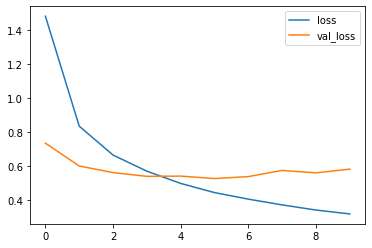

In [49]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [50]:
model.save("hundred_word_k24")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: hundred_word_k24/assets


In [51]:
model = tf.keras.models.load_model("hundred_word_k24")

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [ ]:
WHY DOES THIS CRASH???

test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
  if ix % 2000 == 0:
    print(ix)
  #if ix > 16000:
  #  break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [26]:
test_audio = []
test_labels = []

for ix,(audio, label) in enumerate(test_ds):
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())
  if ix % 2000 == 0:
    print(ix)
  if ix > 16000:
    break

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

0
2000
4000
6000
8000
10000
12000
14000
16000


In [29]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 10%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

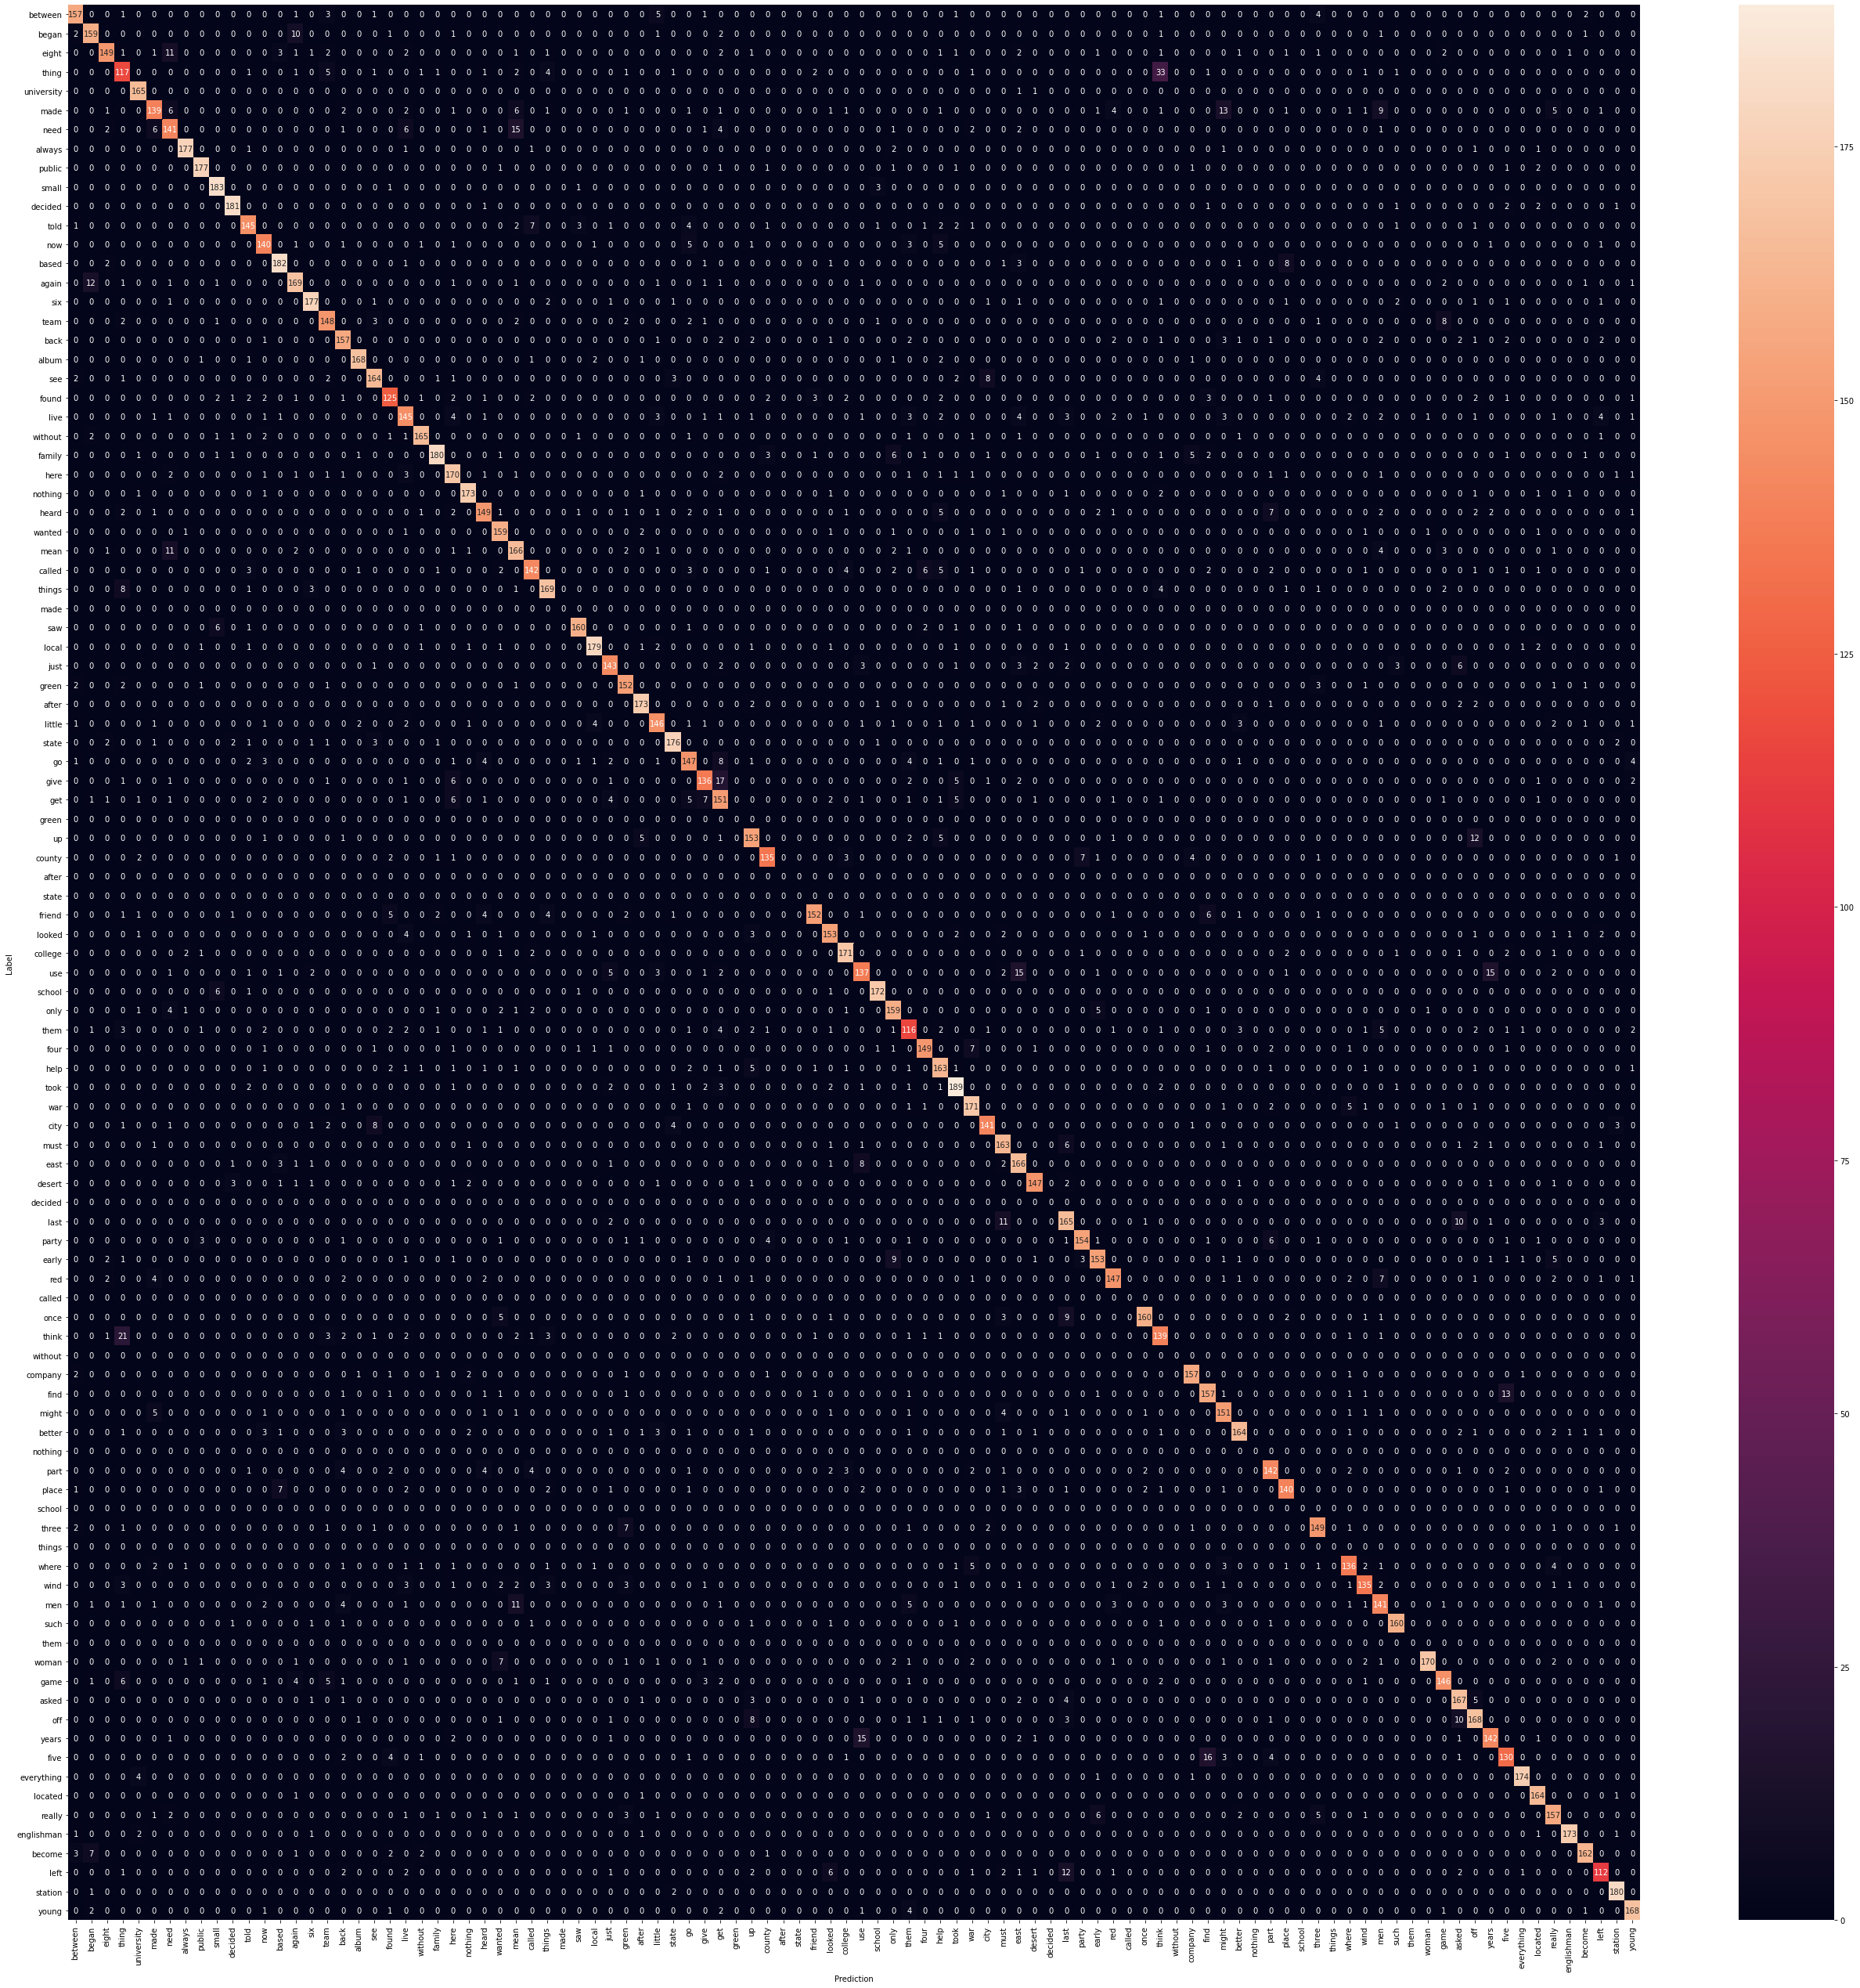

In [68]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.gcf().set_size_inches(45,45)

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does our model perform?

In [69]:
f = np.random.choice(filenames,1)[0]
print(f)

b'/home/mark/tinyspeech_harvard/frequent_words/en/clips/off/common_voice_en_575642.wav'


In [70]:
os.path.exists(f)

True

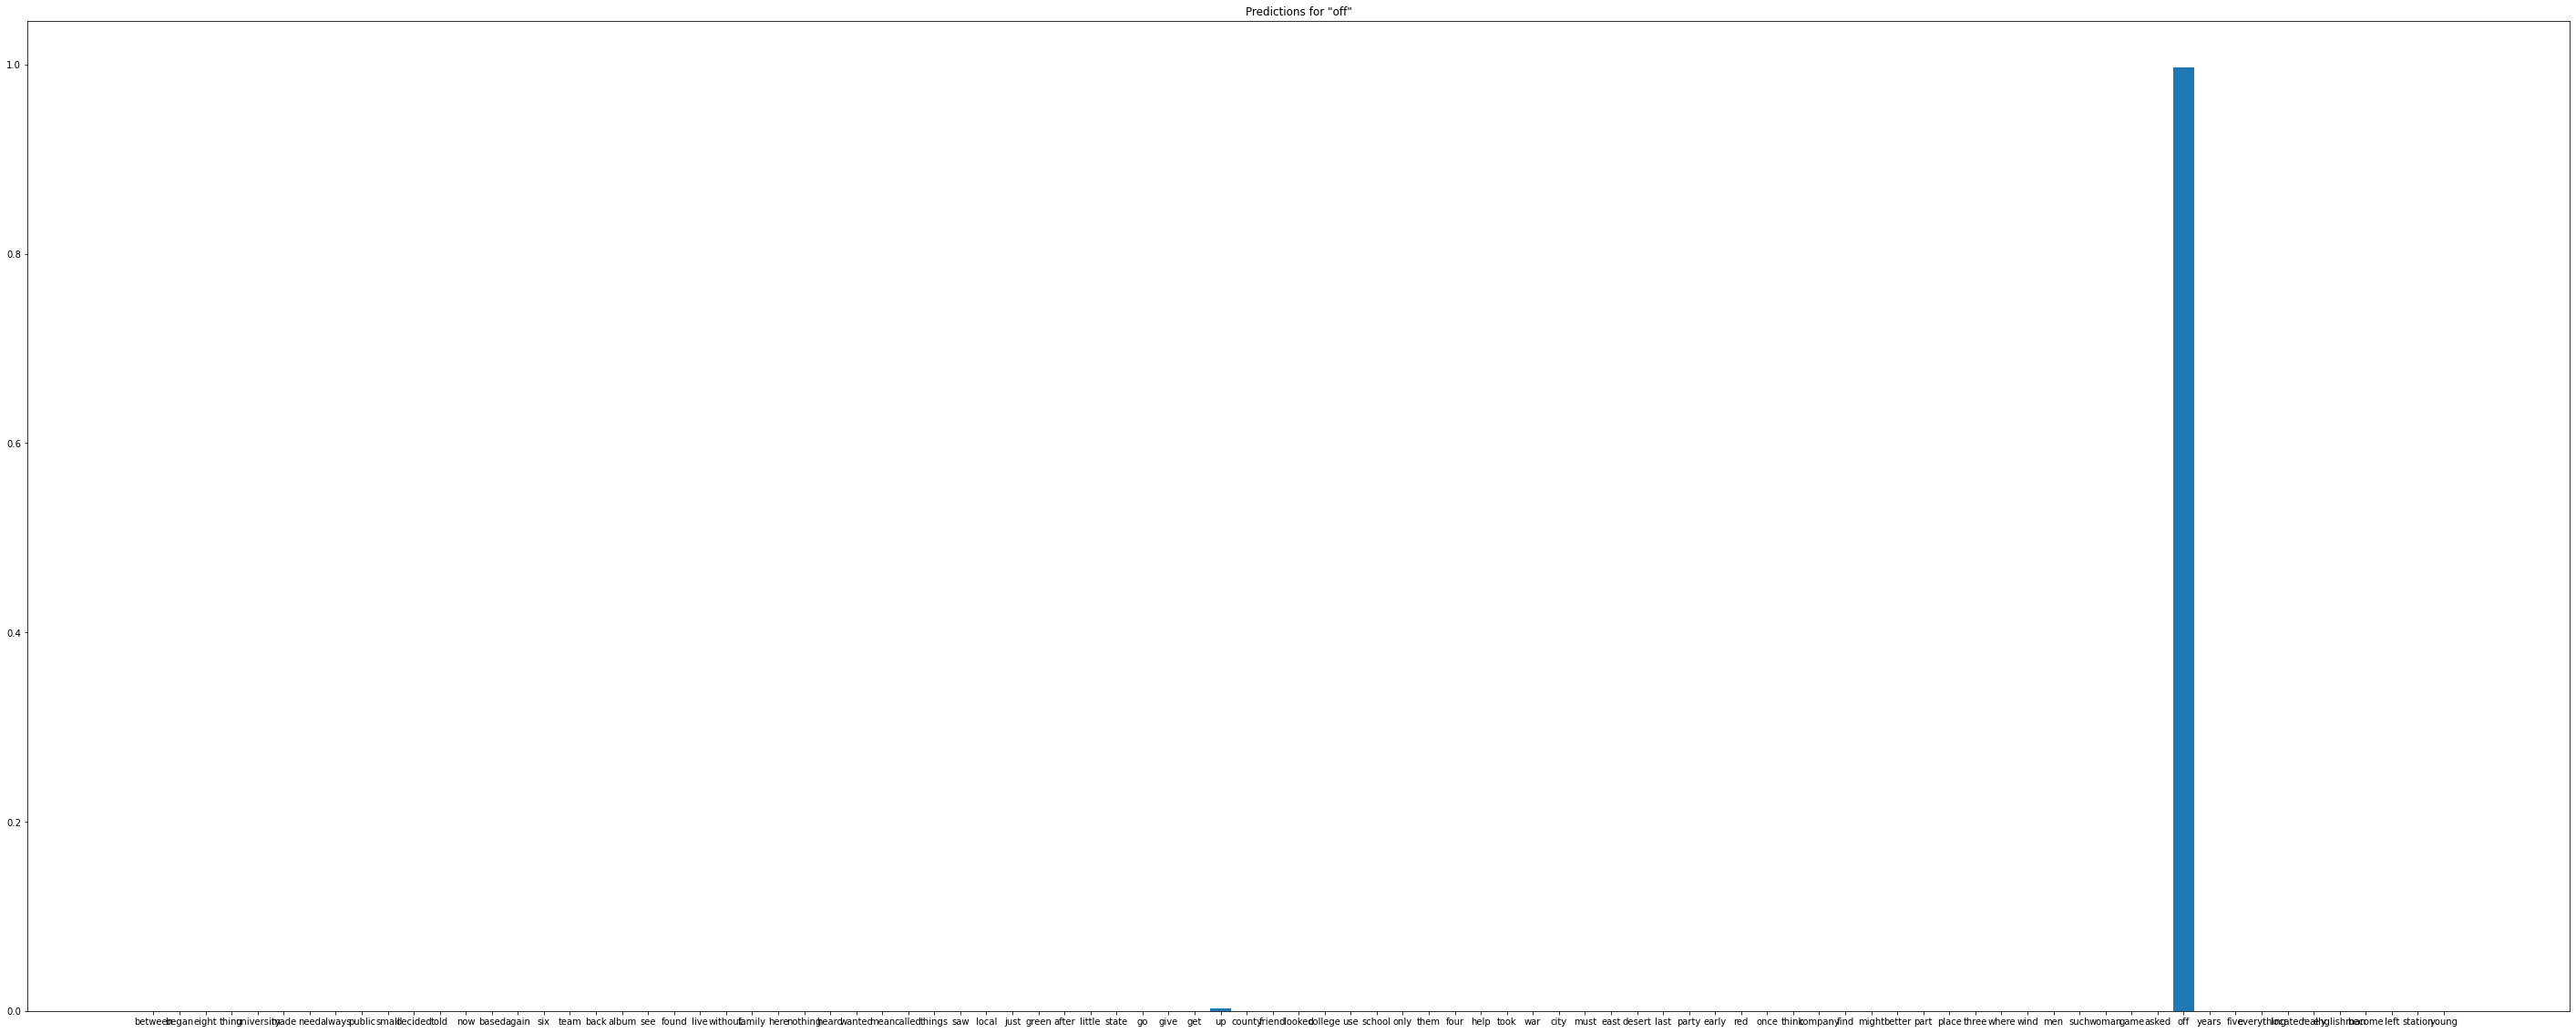

In [71]:
#sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([f])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.gcf().set_size_inches(50,20)

Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.



# Embeddings

In [72]:
# https://keras.io/guides/sequential_model/
print(len(model.layers))

10


In [73]:
model.pop()

In [74]:
print(len(model.layers))

9


In [75]:
commands

array(['between', 'began', 'eight', 'thing', 'university', 'made', 'need',
       'always', 'public', 'small', 'decided', 'told', 'now', 'based',
       'again', 'six', 'team', 'back', 'album', 'see', 'found', 'live',
       'without', 'family', 'here', 'nothing', 'heard', 'wanted', 'mean',
       'called', 'things', 'made', 'saw', 'local', 'just', 'green',
       'after', 'little', 'state', 'go', 'give', 'get', 'green', 'up',
       'county', 'after', 'state', 'friend', 'looked', 'college', 'use',
       'school', 'only', 'them', 'four', 'help', 'took', 'war', 'city',
       'must', 'east', 'desert', 'decided', 'last', 'party', 'early',
       'red', 'called', 'once', 'think', 'without', 'company', 'find',
       'might', 'better', 'nothing', 'part', 'place', 'school', 'three',
       'things', 'where', 'wind', 'men', 'such', 'them', 'woman', 'game',
       'asked', 'off', 'years', 'five', 'everything', 'located', 'really',
       'englishman', 'become', 'left', 'station', 'young'], d

In [12]:
cset = set(commands)
all_words = os.listdir(data_dir)
other_words = []
for w in all_words:
    if w not in cset and w != "_background_noise_":
        other_words.append(w)
print(len(other_words))

176


In [54]:
" ".join(other_words)

'went love those every still man house light first group heart through other used sheep looking good blue point main both night long father written going under mind people children during second served would something next put please sound very continued river day old set boy park large son should ever want away who few also girl include different around some never named time these read than north gold then sun air times answered everyone being became will number hand today office seen born before area well anything known lot own film building many book earth west does way show take high morning look several district even end because one nine much later could year united more name since street great most days done alchemist life say eyes over black road work same know each best how language water music built often system appeared about right been money played when knew make tell idea playing thought south play down like near fire however town into matter king which already seven anothe

In [78]:
NUM_EXAMPLES = 150
otherword_examples = {}
for w in other_words:
    wavs = glob.glob(data_dir + w + "/*.wav")
    otherword_examples[w] = np.random.choice(wavs, NUM_EXAMPLES, replace=False)
#print(otherword_examples)

In [95]:
otherword_examples["language"][:5]

array(['/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_22341510__2.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_601016.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_644323.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_158331.wav',
       '/home/mark/tinyspeech_harvard/frequent_words/en/clips/language/common_voice_en_504501.wav'],
      dtype='<U94')

In [79]:
def get_spectrogram_and_label(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram, label
def preprocess_nondataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label, num_parallel_calls=AUTOTUNE)
  return output_ds

In [80]:
otherword_files = [file for files in otherword_examples.values() for file in files]

In [81]:
for k, v in embeddings.items():
    print(k, len(v))

NameError: name 'embeddings' is not defined

In [82]:
sample_ds = preprocess_nondataset(otherword_files)

embeddings = {w:[] for w in other_words}

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    label = label[0].numpy().decode("utf8")
    embeddings[label].append(prediction[0].numpy())

In [106]:
good_embeddings = {}
for k,v in embeddings.items():
    if len(v) == 150:
        good_embeddings[k] = v

In [123]:
len(good_embeddings.keys())

149

In [124]:
" ".join(good_embeddings.keys())

'went love those every still man house light first group heart through other used sheep looking good blue point main both night long father written going under mind people children during second served would something next put please sound very continued river day old set boy park large son should ever want away who few also girl include different around some never named time these read than north gold then sun air times answered everyone being became will number hand today office seen born before area well anything known lot own film building many book earth west does way show take high morning look several district even end because one nine much later could year united more name since street great most days done alchemist life say eyes over black road work same know each best how language water music built often system appeared about right been money played'

In [83]:
rawdata = [embedding for key, embeddings in embeddings.items() for embedding in embeddings]
len(rawdata)

26400

In [84]:
rawdata = np.array(rawdata)

In [85]:
rawdata.shape

(26400, 512)

In [86]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

In [87]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30., n_iter=1000)

In [88]:
# htgood_embeddingsowardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
fit = tsne.fit_transform(rawdata)
fit.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26400 samples in 2.968s...
[t-SNE] Computed neighbors for 26400 samples in 477.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26400
[t-SNE] Computed conditional probabilities for sample 2000 / 26400
[t-SNE] Computed conditional probabilities for sample 3000 / 26400
[t-SNE] Computed conditional probabilities for sample 4000 / 26400
[t-SNE] Computed conditional probabilities for sample 5000 / 26400
[t-SNE] Computed conditional probabilities for sample 6000 / 26400
[t-SNE] Computed conditional probabilities for sample 7000 / 26400
[t-SNE] Computed conditional probabilities for sample 8000 / 26400
[t-SNE] Computed conditional probabilities for sample 9000 / 26400
[t-SNE] Computed conditional probabilities for sample 10000 / 26400
[t-SNE] Computed conditional probabilities for sample 11000 / 26400
[t-SNE] Computed conditional probabilities for sample 12000 / 26400
[t-SNE] Computed conditional probabilities for s

(26400, 2)

In [89]:
# ground-truth label for each embedding vector
matched_keys = [key for key, embeddings in embeddings.items() for embedding in embeddings]
print(len(matched_keys))
matched_keys[0:5]

26400


['went', 'went', 'went', 'went', 'went']

In [90]:
df = pd.DataFrame({"x":fit[:,0], "y":fit[:,1],"keyword":matched_keys})

In [91]:
os.getcwd()

'/home/mark/tinyspeech_harvard/train_100_moreepochs'

In [92]:
df.to_csv("tsne.csv", index=False)

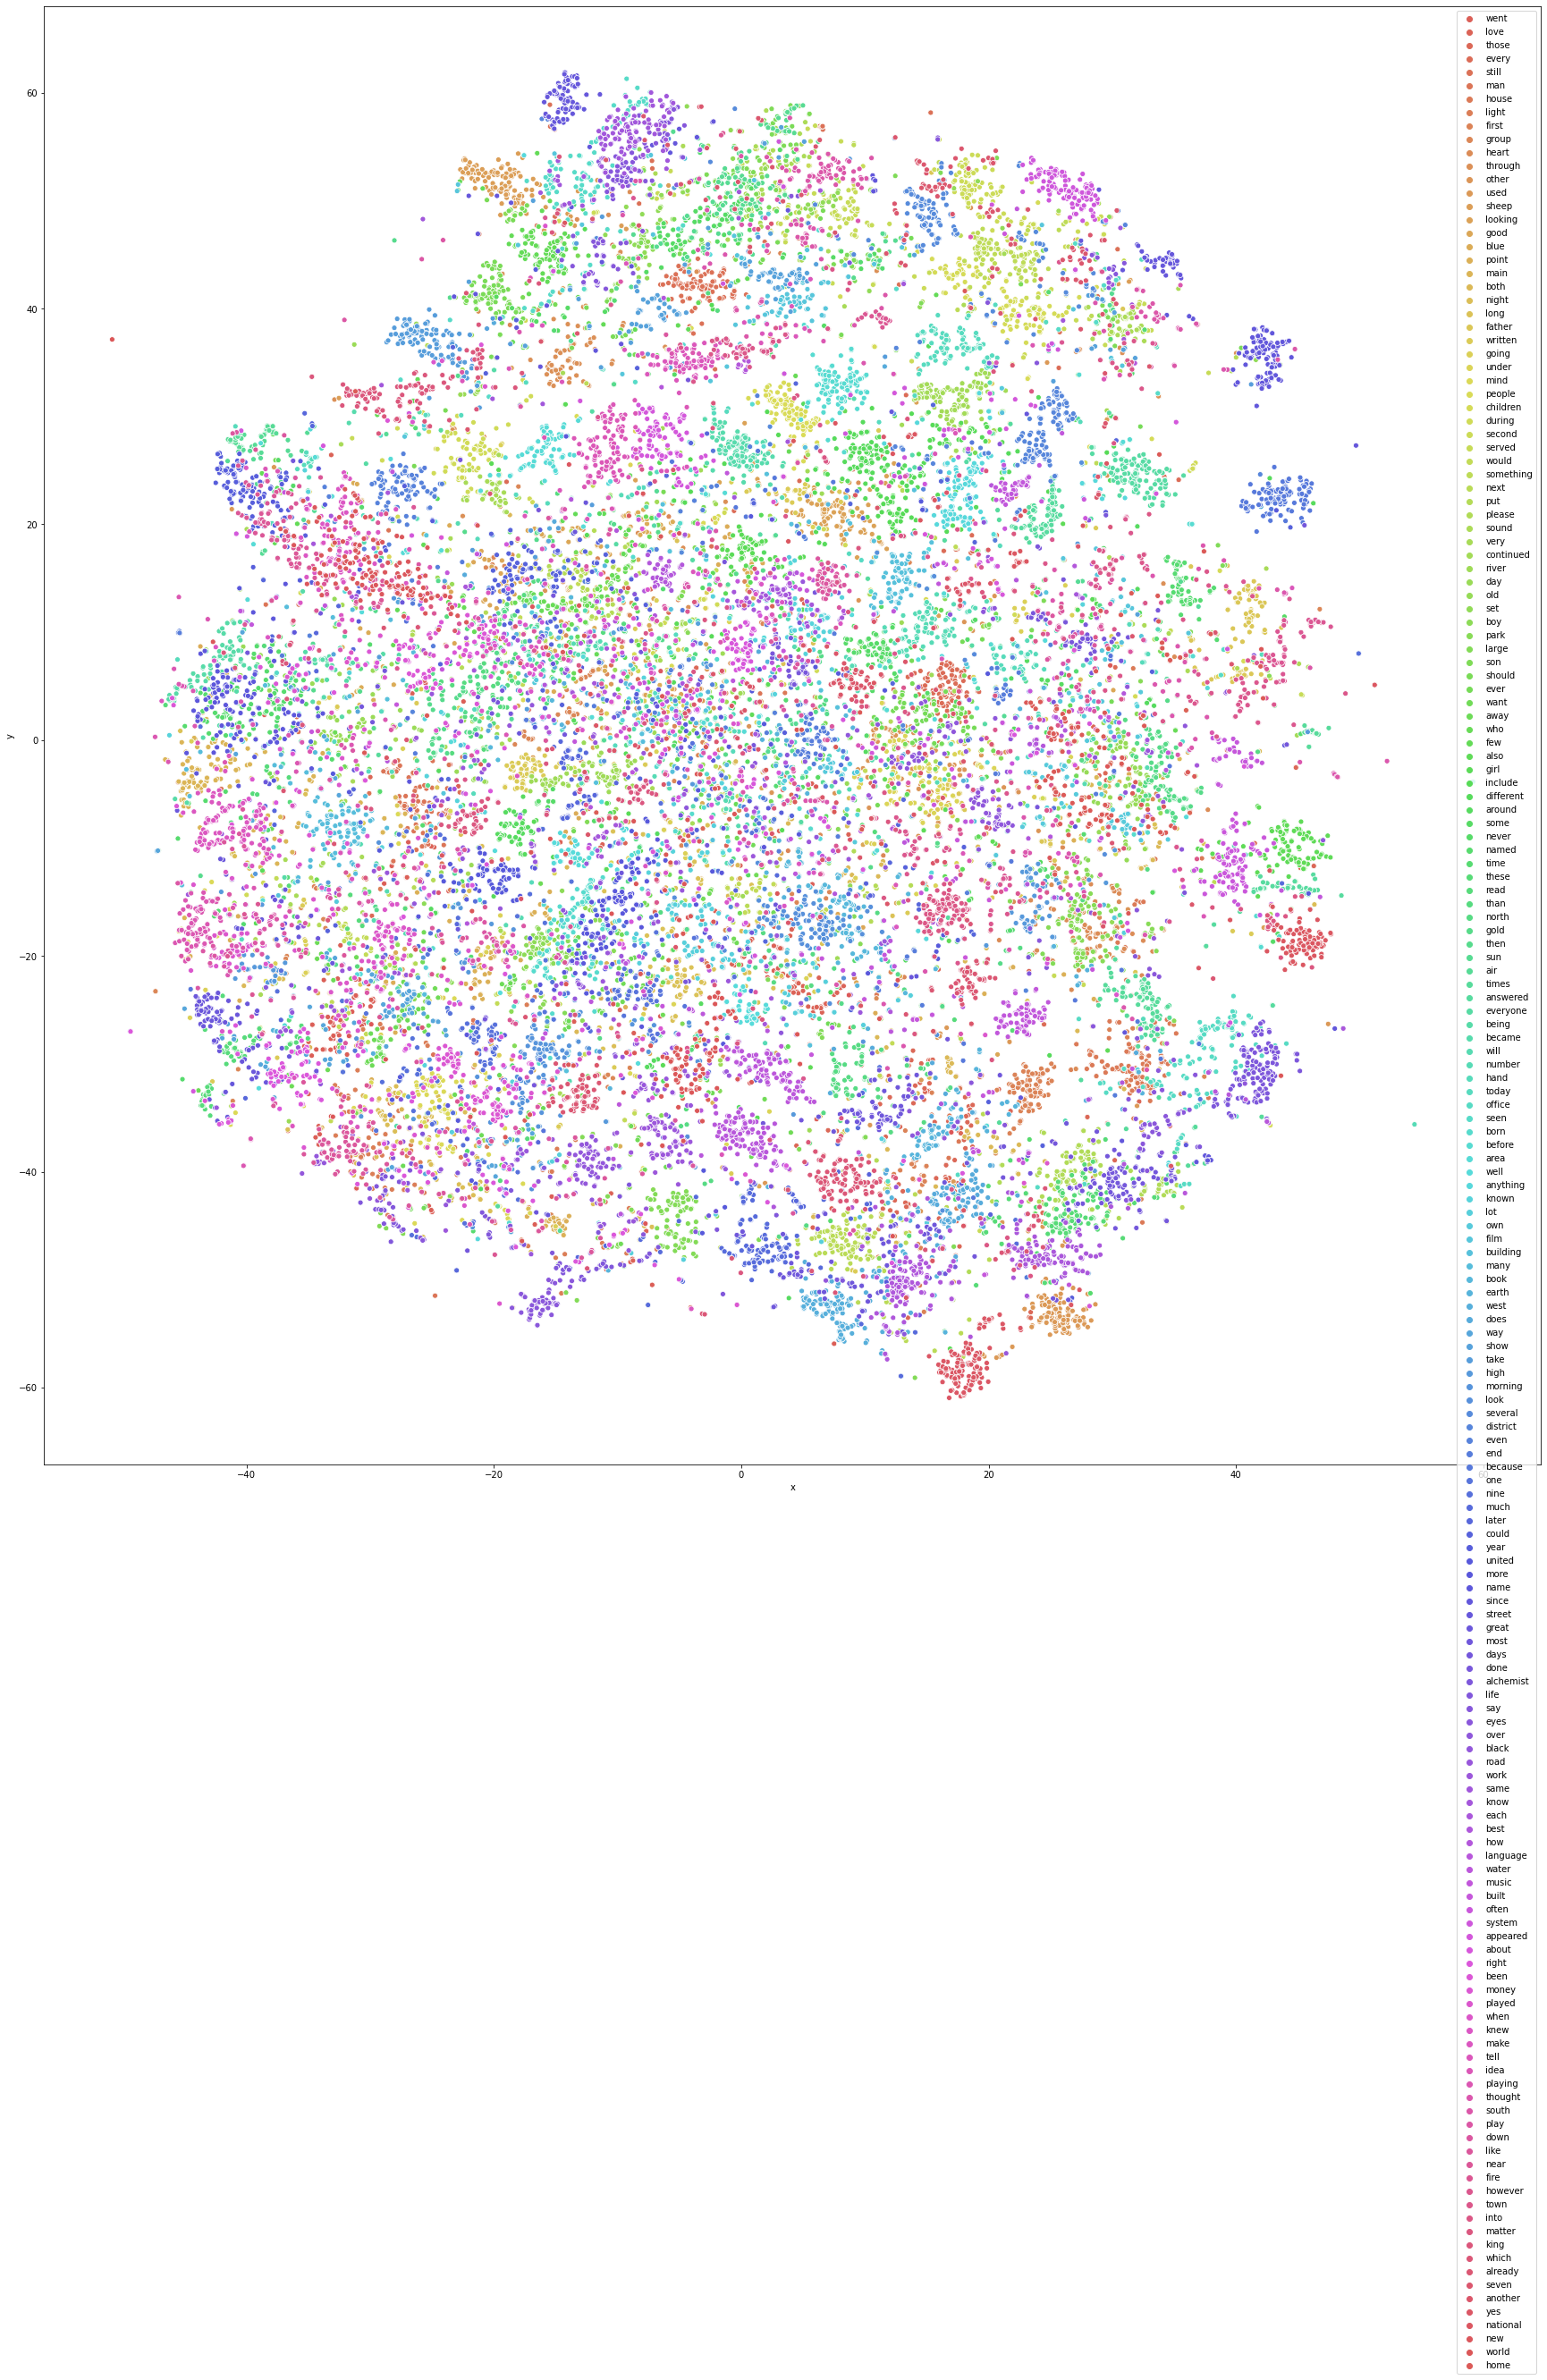

In [94]:
sns.scatterplot(x="x", 
                y="y", 
                hue=df.keyword.tolist(), 
                data=df,
                palette=sns.color_palette("hls", len(embeddings.keys())) 
               );
plt.gcf().set_size_inches(30,30);

In [86]:
mydata = [[0,1, "hi"],[0,2, "hi"],[5,6,"bye"],[5,7,"bye"]]
df = pd.DataFrame(mydata, columns=["x", "y", "lbl"])
df

x  y  lbl
0  0  1   hi
1  0  2   hi
2  5  6  bye
3  5  7  bye

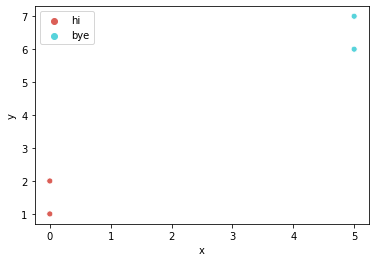

In [92]:
# https://stackoverflow.com/a/63640434
sns.scatterplot(x="x", y="y", hue=df.lbl.tolist(), data=df,palette=sns.color_palette("hls", 2), );

# XFer

In [98]:
",".join(wordlist)

'between,began,eight,thing,university,made,need,always,public,small,decided,told,now,based,again,six,team,back,album,see,found,live,without,family,here,nothing,heard,wanted,mean,called,things,made,saw,local,just,green,after,little,state,go,give,get,green,up,county,after,state,friend,looked,college,use,school,only,them,four,help,took,war,city,must,east,desert,decided,last,party,early,red,called,once,think,without,company,find,might,better,nothing,part,place,school,three,things,where,wind,men,such,them,woman,game,asked,off,years,five,everything,located,really,englishman,become,left,station,young'

In [99]:
",".join(other_words)

'went,love,those,every,still,man,house,light,first,group,heart,through,other,used,sheep,looking,good,blue,point,main,both,night,long,father,written,going,under,mind,people,children,during,second,served,would,something,next,put,please,sound,very,continued,river,day,old,set,boy,park,large,son,should,ever,want,away,who,few,also,girl,include,different,around,some,never,named,time,these,read,than,north,gold,then,sun,air,times,answered,everyone,being,became,will,number,hand,today,office,seen,born,before,area,well,anything,known,lot,own,film,building,many,book,earth,west,does,way,show,take,high,morning,look,several,district,even,end,because,one,nine,much,later,could,year,united,more,name,since,street,great,most,days,done,alchemist,life,say,eyes,over,black,road,work,same,know,each,best,how,language,water,music,built,often,system,appeared,about,right,been,money,played,when,knew,make,tell,idea,playing,thought,south,play,down,like,near,fire,however,town,into,matter,king,which,already,seven,anothe

In [13]:
np.random.choice(other_words, 5, replace=False)

array(['main', 'boy', 'music', 'during', 'north'], dtype='<U9')

In [14]:
fiveword_xfer = ['under', 'look', 'which', 'well', 'include']

In [15]:
for w in fiveword_xfer:
    print(w in wordlist)

False
False
False
False
False


In [54]:
os.chdir("/home/mark/tinyspeech_harvard/train_100_moreepochs/mini_dataset/")

In [16]:
for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    print(len(wavs))

4485
5139
7189
10743
3251


In [83]:
mini_dataset = {}
mini_val = {}
for w in fiveword_xfer:
    wavs = glob.glob(data_dir + w + "/*.wav")
    selected = np.random.choice(wavs, 400, replace=False)
    
    mini_dataset[w] = selected[:50]
    mini_val[w] = selected[50:]

In [74]:
raise ValueError("caution: overwrites dataset")
with open('mini_dataset.pkl', 'wb') as fh:
    pickle.dump(mini_dataset, fh, pickle.HIGHEST_PROTOCOL)
with open('mini_val.pkl', 'wb') as fh:
    pickle.dump(mini_val, fh, pickle.HIGHEST_PROTOCOL)    

In [17]:
with open('mini_dataset.pkl', 'rb') as fh:
    mini_dataset = pickle.load(fh)
with open('mini_val.pkl', 'rb') as fh:
    mini_val = pickle.load(fh)

In [18]:
mini_dataset["under"][0]

'/home/mark/tinyspeech_harvard/frequent_words/en/clips/under/common_voice_en_22175727.wav'

In [19]:
mini_val["under"][0]

'/home/mark/tinyspeech_harvard/frequent_words/en/clips/under/common_voice_en_559626.wav'

In [55]:
base_model = tf.keras.models.load_model("../hundred_word_k24")

In [56]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [84]:
# https://github.com/tensorflow/tfjs-models/blob/master/speech-commands/training/browser-fft/training_custom_audio_model_in_python.ipynb
model = tf.keras.Sequential(name="TransferLearnedModel")
for layer in base_model.layers[:-1]:
    model.add(layer)

In [85]:
model.add(tf.keras.layers.Dense(units=5, activation="softmax"))
#model.add(layers.Dense(5))

In [86]:
# Freeze all but the last layer of the model. The last layer will be fine-tuned
# during transfer learning.
for layer in model.layers[:-1]:
    layer.trainable = False

In [87]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [61]:
input_shape

TensorShape([124, 129, 1])

In [88]:
model.build(input_shape=(None, 124, 129, 1))

In [89]:
model.summary()

Model: "TransferLearnedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 64, 64, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 64, 64, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)    

In [2]:
tf.keras.__version__

'2.4.0'

In [90]:
filenames = [v for _,vs in mini_dataset.items() for v in vs]
print(len(filenames))

250


In [91]:
val_filenames = [v for _,vs in mini_val.items() for v in vs]
print(len(val_filenames))

1750


In [92]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [93]:
train_ds = preprocess_dataset(filenames)
val_ds = preprocess_dataset(val_filenames)

In [94]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [95]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [82]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=[],
)

Epoch 1/10
4/4 [==============================] - 0s 87ms/step - loss: 1.6389 - accuracy: 0.2000 - val_loss: 1.5325 - val_accuracy: 0.3920
Epoch 2/10
4/4 [==============================] - 0s 17ms/step - loss: 1.5292 - accuracy: 0.3400 - val_loss: 1.3847 - val_accuracy: 0.6240
Epoch 3/10
4/4 [==============================] - 0s 16ms/step - loss: 1.3669 - accuracy: 0.6080 - val_loss: 1.2414 - val_accuracy: 0.8080
Epoch 4/10
4/4 [==============================] - 0s 16ms/step - loss: 1.2507 - accuracy: 0.7400 - val_loss: 1.1304 - val_accuracy: 0.8880
Epoch 5/10
4/4 [==============================] - 0s 16ms/step - loss: 1.1555 - accuracy: 0.8320 - val_loss: 1.0548 - val_accuracy: 0.9600
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 1.0782 - accuracy: 0.9080 - val_loss: 1.0049 - val_accuracy: 0.9760
Epoch 7/10
4/4 [==============================] - 0s 17ms/step - loss: 1.0073 - accuracy: 0.9720 - val_loss: 0.9736 - val_accuracy: 1.0000
Epoch 8/10
4/4 [===========

In [96]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=[],
)

Epoch 1/10
4/4 [==============================] - 1s 197ms/step - loss: 1.6424 - accuracy: 0.1720 - val_loss: 1.5723 - val_accuracy: 0.2829
Epoch 2/10
4/4 [==============================] - 0s 52ms/step - loss: 1.5264 - accuracy: 0.3400 - val_loss: 1.4226 - val_accuracy: 0.5840
Epoch 3/10
4/4 [==============================] - 0s 48ms/step - loss: 1.4035 - accuracy: 0.5520 - val_loss: 1.2678 - val_accuracy: 0.8234
Epoch 4/10
4/4 [==============================] - 0s 47ms/step - loss: 1.2605 - accuracy: 0.7280 - val_loss: 1.1406 - val_accuracy: 0.9423
Epoch 5/10
4/4 [==============================] - 0s 47ms/step - loss: 1.1396 - accuracy: 0.8760 - val_loss: 1.0528 - val_accuracy: 0.9811
Epoch 6/10
4/4 [==============================] - 0s 49ms/step - loss: 1.0612 - accuracy: 0.9320 - val_loss: 0.9994 - val_accuracy: 0.9977
Epoch 7/10
4/4 [==============================] - 0s 50ms/step - loss: 1.0208 - accuracy: 0.9600 - val_loss: 0.9674 - val_accuracy: 1.0000
Epoch 8/10
4/4 [==========

In [17]:
1-1/250

0.996

In [18]:
1-1749/1750

0.0005714285714285561